In [2]:
# import whatever needed 

import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import camb
import astropy.units as u
import astropy.constants as cu
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad
from scipy import integrate


import hmvec.ksz as ksz
import hmvec.hod as hod
import hmvec.hmvec as hm

from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import getdist
from getdist import plots, MCSamples
import IPython
# The plotting scripts also let you plot Gaussian (or Gaussian mixture) contours 
from getdist.gaussian_mixtures import GaussianND

print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
# matplotlib 2 may not work very well without usetex on, can uncomment
# plt.rcParams['text.usetex']=True

from matplotlib import pyplot as plt
palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#5f685f','#377eb8', '#ff7f00', '#4daf4a',
           '#f781bf', '#a65628', '#984ea3',
           '#999999', '#e41a1c', '#dede00']
# palette =  ['#377eb8', '#ff7f00', '#4daf4a',
#            '#f781bf', '#a65628', '#984ea3',
#            '#999999', '#e41a1c', '#dede00']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [6, 5]
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['axes.linewidth'] = 1.






plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"})

GetDist Version: 1.4.3, Matplotlib version: 3.7.1


In [3]:
cosmo_params = dict(
         f_NL=0, H0=67.67, cosmomc_theta=None,
         ombh2=0.022, omch2=0.12, omk=0.0, neutrino_hierarchy='degenerate',
         num_massive_neutrinos=3, mnu=0.06, nnu=3.046,
         YHe=None, meffsterile=0.0, standard_neutrino_neff=3.046,
         TCMB=2.7255, tau=0.06, deltazrei=None, bbn_predictor=None,
         theta_H0_range=[10, 100], w=-1.0, wa=0., cs2=1.0,
         dark_energy_model='ppf',As=2.2e-09,
         # !!! Planck 2018 eq. 16/17/18 arXiv:1807.06211
         ns=0.965, nrun=0.0, nrunrun=0.0,
         r=0.0, nt=None, ntrun=0.0,
         pivot_scalar=0.05, pivot_tensor=0.05,
         parameterization=2,halofit_version='mead')

zcosmo = np.linspace(0.,15.,101)
cosmo1 = cosmo_params.copy()
cosmo1.pop('f_NL')

0

### Adding CMB+BAO data

In [4]:
fisher_root = '/Users/user1/Desktop/School/Cosmology/kSZ+ML/Fisher matrices/'
F_planck_lowell = np.loadtxt(fisher_root+'Fisher_Planck_lowell')
F_bao = np.loadtxt(fisher_root+'Fisher_DESI_BAO')

import pickle


with open(fisher_root+'fisher_8p_varyDT_theta14.pkl', "rb") as f:
    F_CMB_DT = pickle.load(f)
    
F_CMB_DT


{'cmbNoiseSpectra': {0: {'l': array([   2,    3,    4, ..., 8498, 8499, 8500]),
   'cl_TT': array([8.46159651e-10, 8.46159803e-10, 8.46160006e-10, ...,
          7.33802907e-09, 7.34176054e-09, 7.34549436e-09]),
   'cl_EE': array([1.69231930e-09, 1.69231961e-09, 1.69232001e-09, ...,
          1.46760581e-08, 1.46835211e-08, 1.46909887e-08]),
   'cl_TE': array([0., 0., 0., ..., 0., 0., 0.]),
   'cl_BB': array([1.69231930e-09, 1.69231961e-09, 1.69232001e-09, ...,
          1.46760581e-08, 1.46835211e-08, 1.46909887e-08]),
   'dl_TT': array([8.08022947e-10, 1.61604618e-09, 2.69341095e-09, ...,
          8.43498113e-02, 8.44125660e-02, 8.44753701e-02]),
   'dl_EE': array([1.61604589e-09, 3.23209237e-09, 5.38682190e-09, ...,
          1.68699623e-01, 1.68825132e-01, 1.68950740e-01]),
   'dl_TE': array([0., 0., 0., ..., 0., 0., 0.]),
   'dl_BB': array([1.61604589e-09, 3.23209237e-09, 5.38682190e-09, ...,
          1.68699623e-01, 1.68825132e-01, 1.68950740e-01])},
  1: {'l': array([   2,    

In [6]:
Delta_Ts = np.logspace(-1,1, 8)
print('Delta_T for CMB-S4: %g'%np.round(Delta_Ts[4],1))

fsky=0.4
#F_S4 = F_CMB_DT['fisherNonGaussian_delensed'][4]*fsky
F_S4 = F_CMB_DT['fisherGaussian'][4]['lensed']*fsky
F_S4 = np.delete(F_S4, -1, axis=0)
F_S4 = np.delete(F_S4, -1, axis=1)
F_bao_CMB_S4 = F_bao + F_planck_lowell + F_S4#F_S4# + F_planck_highell

free_params2 = ['H0','ombh2','omch2','ns','As','tau','mnu']
cov, covp = covariance_mat(F_bao_CMB_S4, free_params2, [], {})#{'tau':0.01})
print_1_sigmas(cov,covp)


Delta_T for CMB-S4: 1.4


1-sigma of H0 is 0.23739174108881805
1-sigma of ombh2 is 2.968410495676187e-05
1-sigma of omch2 is 0.0006197914119473335
1-sigma of ns is 0.0021403579565732397
1-sigma of As is 4.2975759167736186e-11
1-sigma of tau is 0.010740754534574326
1-sigma of mnu is 0.03797450871621998


In [7]:
with open(fisher_root+'fisher_8p_vary_theta_DT14.pkl', "rb") as f:
    F_CMB_f = pickle.load(f)
    
fwhms = np.logspace(-1,1, 8)
print('Delta_T for CMB-S4: %g'%np.round(fwhms[4],1))


Delta_T for CMB-S4: 1.4


In [8]:
fisher_root = '/Users/user1/Desktop/School/Cosmology/SharedVM/Fisher matrices/'

import pickle


with open(fisher_root+'fisher_8p_original.pkl', "rb") as f:
    F_CMB_DT = pickle.load(f)
    
F_CMB_DT


{'cmbNoiseSpectra': {0: {'l': array([   2,    3,    4, ..., 8498, 8499, 8500]),
   'cl_TT': array([2.11539894e-08, 2.11539914e-08, 2.11539939e-08, ...,
          6.36837408e-08, 6.37002612e-08, 6.37167878e-08]),
   'cl_EE': array([4.23079788e-08, 4.23079827e-08, 4.23079879e-08, ...,
          1.27367482e-07, 1.27400522e-07, 1.27433576e-07]),
   'cl_TE': array([0., 0., 0., ..., 0., 0., 0.]),
   'cl_BB': array([4.23079788e-08, 4.23079827e-08, 4.23079879e-08, ...,
          1.27367482e-07, 1.27400522e-07, 1.27433576e-07]),
   'dl_TT': array([2.02005719e-08, 4.04011475e-08, 6.73352540e-08, ...,
          7.32037373e-01, 7.32399602e-01, 7.32762012e-01]),
   'dl_EE': array([4.04011438e-08, 8.08022950e-08, 1.34670508e-07, ...,
          1.46407475e+00, 1.46479920e+00, 1.46552402e+00]),
   'dl_TE': array([0., 0., 0., ..., 0., 0., 0.]),
   'dl_BB': array([4.04011438e-08, 8.08022950e-08, 1.34670508e-07, ...,
          1.46407475e+00, 1.46479920e+00, 1.46552402e+00])},
  1: {'l': array([   2,    

# Functions

In [24]:
#%% Calculate the reconstructed noise N_vv
def Rec_noise(Z, cosmo_params, k_large, mu_L, bg, ng, survey, Delta_T):
    if survey == 'VRO10':
        sigma_phot = lambda z: 0.03*(1+z)
    elif survey == 'DESI':
        sigma_phot = lambda z: 0*(1+z)
    else:
        raise KeyError(f"{survey} is not a valid galaxy survey for this code!")
    nkS = 300
    nz = 101
    nmu = len(mu_L)
    k_small = np.linspace(1,5,nkS) # Mpc^-1
    mu_S = -(k_large[np.newaxis,:,np.newaxis]*np.ones((nkS,nkL,nmu))/k_small[:,np.newaxis,np.newaxis]*np.ones((nkS,nkL,nmu))) * mu_L[np.newaxis,np.newaxis,:]*np.ones((nkS,nkL,nmu))
    Mh = np.logspace(8,15,200) # Msun
    zcosmo = np.linspace(0.,15.,nz)
    cosmo_1 = cosmo_params.copy()
    cosmo_1.pop('f_NL')
    camb_pars = camb.set_params(**cosmo_1)
    camb_pars.set_matter_power(redshifts=list(zcosmo))
    cosmo = camb.get_results(camb_pars)
    H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value # 1/Mpc    
    a = lambda z: 1/(1+z)
    T_CMB = ((camb_pars.TCMB* u.K).to(u.uK)).value # muK
    chi_star = lambda z: cosmo.comoving_radial_distance(z) # Mpc
    ell = lambda z,kS: chi_star(z) * kS
    gal_profile = hod.Leauthaud12_HOD
    elec_profile = 'electron'
    b1=None # linear biases, we add from the outside 
    b2=None # linear biases, we add from the outside 
    m_integrand=False # if False, the output is Pk integrated in Mh, otherwise you get the integrand in dMh
    rsd=False # RSD, we add from the outside
    fog=False # FoG, we add from the outside
    hcos_ksmall = hm.HaloModel([Z],k_small,Mh,params=cosmo_params)
    hcos_ksmall.add_hod("g",family=gal_profile,ngal=ng+np.asarray([Z])*0.,corr="max")
    hcos_ksmall.add_battaglia_profile("electron",family="AGN",xmax=20,nxs=5000)
    pgg_1h_ksmall = hcos_ksmall.get_power_1halo(name='g', name2=None, m_integrand=m_integrand,fog=fog)[0] # Mpc^3
    pgg_2h_ksmall = hcos_ksmall.get_power_2halo(name='g',name2=None,b1_in=b1,b2_in=b2,m_integrand=m_integrand,rsd=rsd,fog=fog)[0] # Mpc^3
    pge_1h_ksmall = hcos_ksmall.get_power_1halo(name='g', name2 = elec_profile, m_integrand=m_integrand,fog=fog)[0] # Mpc^3
    pge_2h_ksmall = hcos_ksmall.get_power_2halo(name='g',name2=elec_profile,b1_in=b1,b2_in=b2,m_integrand=m_integrand,rsd=rsd,fog=fog)[0] # Mpc^3
    fgrowth = hcos_ksmall.get_fgrowth(fog=False, vectorize_mu=True)[0]
    resize_ksmall = k_small[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pgg = (pgg_1h_ksmall+pgg_2h_ksmall)[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_ell_ksmall = chi_star(Z) * k_small[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pge = (pge_1h_ksmall+pge_2h_ksmall)[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    P_gg_ksmall = (1 + mu_S**2*fgrowth/bg)**2 * (resize_pgg) # Mpc^3
    W_phot_ksmall = np.exp(-mu_S**2*resize_ksmall**2*sigma_phot(Z)**2/2/H(Z)**2)
    P_gg_obs_ksmall = W_phot_ksmall**2 * P_gg_ksmall + 1/ng # Mpc^3
    P_ge_ksmall = W_phot_ksmall*(1 + mu_S**2*fgrowth/bg) * (resize_pge) 
#     TT_total_for_S4 = np.loadtxt('./tt_total_power_s4_new_12.txt') # From Selim
#     lvec = TT_total_for_S4[:,0]
#     Cl_TT = interp1d(lvec,TT_total_for_S4[:,1],bounds_error=False,fill_value=0.) # muK^2
#     Cltot_noise = Cl_TT(resize_ell_ksmall)
    s = Delta_T *u.arcmin.to(u.radian)
    fwhm = 1.4 *u.arcmin.to(u.radian) #1.4
    N_ell=CMB_noise(resize_ell_ksmall, s, fwhm)
    Cltot_noise=Cl_tot(resize_ell_ksmall)+N_ell
    # kSZ
    xe = 1 # ionization fraction
    gasfrac = 0.9 # fraction of baryons in gas form, use default
    Yp = camb_pars.YHe # primordial He abundance
    ne0 = ksz.ne0_shaw(ombh2=cosmo_params['ombh2'],gasfrac=gasfrac,Yp=Yp) # m^-3 # mean free electron density at z = 0
    Kstar = lambda z: -ksz.ksz_radial_function(z, camb_pars.ombh2, Yp) # muK / Mpc
    itgrnd = resize_ksmall * (P_ge_ksmall**2 / P_gg_obs_ksmall) / Cltot_noise # Mpc^-1 muK^-2
    mask = np.isinf(itgrnd)
    itgrnd[mask] = 0.
    integral = np.trapz(itgrnd, x=k_small, axis=0) # Mpc / muK^2
    Nvv_par = (chi_star(Z)/ Kstar(Z))**2 * 2*np.pi / integral # Mpc^3
    N_vv = (mu_L[np.newaxis,:]*np.ones((nkL,nmu)))**-2 * Nvv_par
    
    T_CMB=2.7260 #K
    T_CMB_uK=T_CMB*1e6 #uK
    # get potential Pk (non linearities included) - CAMB results is already multiplied by k^4
    interp_Pphiphi = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=zcosmo[-1], nz_step=150, zs=None, kmax=max(k_small), nonlinear=True,var1=camb.model.Transfer_Weyl, var2=camb.model.Transfer_Weyl, hubble_units=False, 
                                                        k_hunit=False, return_z_k=False, k_per_logint=None, log_interp=False,  extrap_kmax=True).P  # Mpc^3
    omegam = (camb_pars.ombh2 + camb_pars.omch2 + camb_pars.omnuh2) / (camb_pars.H0 / 100) ** 2
    rhoM0 = 3*omegam*H(0.)**2 # Mpc^-2
    # potential Pk , change of units
    use_Pphiphi_ksmall = (interp_Pphiphi(use_z,k_small)/k_small**4)[:,np.newaxis,np.newaxis]*np.ones((nkS,nkL,nmu)) # Mpc^3
    noise_pot = ((1+use_z)*rhoM0/2)**2/((resize_ksmall)**4 * bg**2*ng * W_phot_ksmall**2)  # Mpc^3
    # observed potential
    use_Ppot_ob = use_Pphiphi_ksmall + noise_pot # Mpc^3
    itgrnd_ML = (resize_ksmall)**3 * (use_Pphiphi_ksmall**2 / use_Ppot_ob) / Cltot_noise # muK^-2
    mask = np.isinf(itgrnd_ML)
    itgrnd_ML[mask] = 0
    integral_ML = np.trapz(itgrnd_ML, x=k_small, axis=0) # 1 / Mpc / muK^2
    new_resize_muL = mu_L[np.newaxis,:]*np.ones((nkL,nmu))
    new_resize_kL = k_large[:,np.newaxis]*np.ones((nkL,nmu))
    # noise on the transverse velocity potential (T_CMB factor to cancel the uK units from Cls)
    N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
    Nvv_perp = (new_resize_kL)**2 * N_perp_Vpot # v = grad pot so in Fourier you get v = k*pot
    N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3

    return Nvv_par, Nvv_perp
    
    

#%% Calculate power spectra
def get_powers(Z, cosmo_params, bias_params, k_large, mu):
    nmu = len(mu)
    nkL = len(k_large)
    nz = 101
    zcosmo = np.linspace(0.,15.,nz)
    cosmo_1 = cosmo_params.copy()
    cosmo_1.pop('f_NL')
    camb_pars = camb.set_params(**cosmo_1)
    camb_pars.set_matter_power(redshifts=list(zcosmo))
    cosmo = camb.get_results(camb_pars)
    H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value # 1/Mpc
    fgrowth = interp1d(zcosmo[::-1],cosmo.get_fsigma8()/cosmo.get_sigma8(),kind='cubic', bounds_error=False,fill_value='extrapolate')(Z)
    # get linear matter Pk
    interp_Pmm_linear = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=zcosmo[-1], nz_step=150,zs=None, kmax=max(k_large), nonlinear=False,var1=camb.model.Transfer_nonu, var2=camb.model.Transfer_nonu, hubble_units=False, 
    k_hunit=False, return_z_k=False, k_per_logint=None, log_interp=False,  extrap_kmax=False).P # Mpc^3

    resize_klarge = k_large[:,np.newaxis]*np.ones((nkL,nmu))
    resize_mu = mu[np.newaxis,:]*np.ones((nkL,nmu))
    resize_Pmm = interp_Pmm_linear(Z,k_large)[:,np.newaxis]*np.ones((nkL,nmu))
    RSD = bias_params['brsd']*fgrowth*resize_mu**2
    #bg2 = bias_params['bg']+bias_params['b2']*resize_klarge**2 # in case of DESI
    bg2 = (bias_params['m']*Z+bias_params['q'])+bias_params['b2']*resize_klarge**2 # in case of VRO10

    a = lambda z: 1/(1+z)
    b_v = fgrowth * a(Z) * H(Z) / resize_klarge
    b_vpar = bias_params['b_par'] * b_v * resize_mu
    b_vperp = bias_params['b_perp'] * b_v * np.sqrt(1-resize_mu**2)
    
    Pgg = (bg2 + RSD)**2 * resize_Pmm
    Pvv_par = b_vpar**2 * resize_Pmm
    Pvv_perp = b_vperp**2 * resize_Pmm
    Pgv_par = b_vpar * (bg2 + RSD) * resize_Pmm
    Pgv_perp = b_vperp * (bg2 + RSD) * resize_Pmm
    Pvv_par_perp = b_vpar * b_vperp * resize_Pmm
    
    return Pgg, Pgv_par, Pgv_perp, Pvv_par, Pvv_perp, Pvv_par_perp


#%% Calculate noise power spectra
def get_noises(Z, cosmo_params, k_large, mu_L, bg, ng, survey, Delta_T):
    nmu = len(mu_L)
    nkL = len(k_large)
    if survey == 'VRO10':
        sigma_phot = lambda z: 0.03*(1+z)
    elif survey == 'DESI':
        sigma_phot = lambda z: 0*(1+z)
    else:
        raise KeyError(f"{survey} is not a valid galaxy survey for this code!")
    nz = 101
    zcosmo = np.linspace(0.,15.,nz)
    cosmo_1 = cosmo_params.copy()
    cosmo_1.pop('f_NL')
    camb_pars = camb.set_params(**cosmo_1)
    camb_pars.set_matter_power(redshifts=list(zcosmo))
    cosmo = camb.get_results(camb_pars)
    H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value # 1/Mpc
    a = lambda z: 1/(1+z)
    fgrowth = interp1d(zcosmo[::-1],cosmo.get_fsigma8()/cosmo.get_sigma8(),kind='cubic', bounds_error=False,fill_value='extrapolate')(Z)

    resize_muL = mu_L[np.newaxis,:]*np.ones((nkL,nmu))
    resize_klarge = k_large[:,np.newaxis]*np.ones((nkL,nmu))
    W_phot_klarge = np.exp(-resize_muL**2*resize_klarge**2*sigma_phot(Z)**2/2/H(Z)**2)
    Ngg = 1/ W_phot_klarge**2 / ng
    
    Nvv_par, Nvv_perp = Rec_noise(Z, cosmo_params, k_large, mu_L, bg, ng, survey, Delta_T)
    
    N_vv = resize_muL**-2. * Nvv_par
    Nmm = k_large**2/(fgrowth*a(Z)*H(Z))**2 * N_vv[:,-1]
    
    return Ngg, Nvv_par, Nvv_perp#, Nmm


def SNR_calc(Z, cosmo_params, k_large, mu_L, bg, ng, survey, Delta_T, vol):
    if survey == 'VRO10':
        sigma_phot = lambda z: 0.03*(1+z)
    elif survey == 'DESI':
        sigma_phot = lambda z: 0*(1+z)
    else:
        raise KeyError(f"{survey} is not a valid galaxy survey for this code!")
    nz = 101
    k_small = np.linspace(1,5,300)
    zcosmo = np.linspace(0.,15.,nz)
    cosmo_1 = cosmo_params.copy()
    cosmo_1.pop('f_NL')
    camb_pars = camb.set_params(**cosmo_1)
    camb_pars.set_matter_power(redshifts=list(zcosmo))
    cosmo = camb.get_results(camb_pars)
    H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value # 1/Mpc
    a = lambda z: 1/(1+z)
    fgrowth = interp1d(zcosmo[::-1],cosmo.get_fsigma8()/cosmo.get_sigma8(),kind='cubic', bounds_error=False,fill_value='extrapolate')(Z)
    interp_Pmm_linear = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=zcosmo[-1], nz_step=150,zs=None, kmax=max(k_small), nonlinear=False,var1=camb.model.Transfer_nonu, var2=camb.model.Transfer_nonu, hubble_units=False, 
    k_hunit=False, return_z_k=False, k_per_logint=None, log_interp=False,  extrap_kmax=True).P # Mpc^3
    new_resize_muL = mu_L[np.newaxis,:]* np.ones((nkL, nmu))
    new_resize_klarge = k_large[:,np.newaxis]* np.ones((nkL, nmu))
    new_resize_pk = interp_Pmm_linear(Z,new_resize_klarge)  * u.Mpc**3
    bv = 1.
    P_gv = bg * bv * (fgrowth*a(Z)*H(Z)/new_resize_klarge) * new_resize_pk
    W_phot_klarge = np.exp(-new_resize_muL**2*new_resize_klarge**2*sigma_phot(Z)**2/2/H(Z)**2)
    Pgv_klarge = W_phot_klarge* (1 + (new_resize_muL)**2 * fgrowth/bg) * P_gv
    P_gg = (bg + new_resize_muL**2*fgrowth)**2 * new_resize_pk # Mpc^3
    P_gg_obs = W_phot_klarge**2 * P_gg + 1/(ng*u.Mpc**-3) # Mpc^3
    N_vv, N_vv_ML = Rec_noise(Z, cosmo_params, k_large, mu_L, bg, ng, survey, Delta_T)
    prefac = vol/ (2*np.pi)**3
    kL_integrand = Pgv_klarge**2/(P_gg_obs * N_vv)
    SNR = np.sqrt(prefac * 2*np.pi * np.trapz(k_large**2 * np.trapz(kL_integrand, x=mu_L, axis=1),x=k_large, axis=0))
    kL_integrand_ML = Pgv_klarge**2/(P_gg_obs * N_vv_ML)
    SNR_ML = np.sqrt(prefac * 2*np.pi * np.trapz(k_large**2 * np.trapz(kL_integrand_ML, x=mu_L, axis=1),x=k_large, axis=0))
    return SNR, SNR_ML


#%% Calculate derivatives of power spectra
def derivs(Z, cosmo0, bias0, free_params, deltas, k, mu):
    nmu = len(mu)
    nk = len(k)
    #bv = M.bv
    d_Pgg = np.zeros((len(free_params), nk, nmu))
    d_Pgv_par = np.zeros((len(free_params), nk, nmu))
    d_Pgv_perp = np.zeros((len(free_params), nk, nmu))
    d_Pvv_par = np.zeros((len(free_params), nk, nmu))
    d_Pvv_perp = np.zeros((len(free_params), nk, nmu))
    d_Pvv_par_perp = np.zeros((len(free_params), nk, nmu))
    param_values = np.zeros(len(free_params))
    for free_param_ind, free_param in enumerate(free_params):
        if free_param in cosmo0:
            param_values[free_param_ind] = cosmo0[free_param]
        elif free_param in bias0:
            param_values[free_param_ind] = bias0[free_param]
        else:
            raise KeyError(f"{free_param} is not a valid parameters for this code!")
          
    for i, param in enumerate(free_params):
        delta = deltas[i]
        param_value = param_values[i]
        if param in cosmo0:
            cosmo_p = cosmo0.copy()
            cosmo_n = cosmo0.copy()
            if not cosmo0[param] == 0.:
                cosmo_p[param] = cosmo0[param]*(1.+delta)
                cosmo_n[param] = cosmo0[param]*(1.-delta)
            else:
                cosmo_p[param] = delta
                cosmo_n[param] = -delta
            print('\n\nNow simulating for (1+delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            Pgg_p, Pgv_par_p, Pgv_perp_p, Pvv_par_p, Pvv_perp_p, Pvv_par_perp_p = get_powers(Z, cosmo_p, bias0, k_large, mu_L)
            print('\n\nNow simulating for (1-delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            Pgg_n, Pgv_par_n, Pgv_perp_n, Pvv_par_n, Pvv_perp_n, Pvv_par_perp_n = get_powers(Z, cosmo_n, bias0, k_large, mu_L)
        else:
            bias_p = bias0.copy()
            bias_n = bias0.copy()
            if not bias0[param] == 0.:
                bias_p[param] = bias0[param]*(1.+delta)
                bias_n[param] = bias0[param]*(1.-delta)
            else:
                bias_p[param] = delta
                bias_n[param] = -delta
            print('\n\nNow simulating for (1+delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            Pgg_p, Pgv_par_p, Pgv_perp_p, Pvv_par_p, Pvv_perp_p, Pvv_par_perp_p = get_powers(Z, cosmo0, bias_p, k_large, mu_L)
            print('\n\nNow simulating for (1-delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            Pgg_n, Pgv_par_n, Pgv_perp_n, Pvv_par_n, Pvv_perp_n, Pvv_par_perp_n = get_powers(Z, cosmo0, bias_n, k_large, mu_L)
        if not param_value == 0.:
            d_Pgg[i] = (Pgg_p - Pgg_n)/(2*param_value*delta)
            d_Pgv_par[i] = (Pgv_par_p - Pgv_par_n)/(2*param_value*delta)
            d_Pgv_perp[i] = (Pgv_perp_p - Pgv_perp_n)/(2*param_value*delta)
            d_Pvv_par[i] = (Pvv_par_p - Pvv_par_n)/(2*param_value*delta)
            d_Pvv_perp[i] = (Pvv_perp_p - Pvv_perp_n)/(2*param_value*delta)
            d_Pvv_par_perp[i] = (Pvv_par_perp_p - Pvv_par_perp_n)/(2*param_value*delta)
        else:
            d_Pgg[i] = (Pgg_p - Pgg_n)/(2*delta)
            d_Pgv_par[i] = (Pgv_par_p - Pgv_par_n)/(2*delta)
            d_Pgv_perp[i] = (Pgv_perp_p - Pgv_perp_n)/(2*delta)
            d_Pvv_par[i] = (Pvv_par_p - Pvv_par_n)/(2*delta)
            d_Pvv_perp[i] = (Pvv_perp_p - Pvv_perp_n)/(2*delta)
            d_Pvv_par_perp[i] = (Pvv_par_perp_p - Pvv_par_perp_n)/(2*delta)
    return d_Pgg, d_Pgv_par, d_Pgv_perp, d_Pvv_par, d_Pvv_perp, d_Pvv_par_perp
    
    
    
def Fisher_mat(Z, cosmo0, bias0, free_params, deltas, k, mu, ng, survey, Delta_T, vol):
    k_grid=np.meshgrid(mu, k)[1]
    if survey == 'VRO10':
        bg = bias0['m']*Z+bias0['q']
    elif survey == 'DESI':
        bg = bias0['bg']
    else:
        raise KeyError(f"{survey} is not a valid galaxy survey for this code!")
    Pgg, Pgv_par, Pgv_perp, Pvv_par, Pvv_perp, Pvv_par_perp = get_powers(Z, cosmo0, bias0, k, mu)
    Ngg, Nvv_par, Nvv_perp = get_noises(Z, cosmo0, k, mu, bg, ng, survey, Delta_T)
    d_Pgg, d_Pgv_par, d_Pgv_perp, d_Pvv_par, d_Pvv_perp, d_Pvv_par_perp = derivs(Z, cosmo0, bias0, free_params, deltas, k, mu)
    S=np.zeros((len(k),len(mu),4,4))
    S[:,:,0,0]=Pvv_par; S[:,:,0,1]=Pvv_par_perp; S[:,:,1,0]=Pvv_par_perp; S[:,:,1,1]=Pvv_perp;
    S[:,:,0,3]=Pgv_par; S[:,:,3,0]=Pgv_par; S[:,:,1,3]=Pgv_perp; S[:,:,3,1]=Pgv_perp; S[:,:,3,3]=Pgg;
    N=np.zeros((len(k),len(mu),4,4))
    N[:,:,0,0]=Nvv_par; N[:,:,1,1]=Nvv_perp; N[:,:,2,2]=Nvv_perp; N[:,:,3,3]=Ngg;
    C = S + N
    C_inv = np.linalg.inv(C)
    F_gg=np.zeros((len(free_params), len(free_params)))
    F_gv=np.zeros((len(free_params), len(free_params)))
    F_vv=np.zeros((len(free_params), len(free_params)))
    for a in range(len(free_params)):
        d_Pgg_a=d_Pgg[a,:,:]; d_Pgv_par_a=d_Pgv_par[a,:,:]; d_Pgv_perp_a=d_Pgv_perp[a,:,:]
        d_Pvv_par_a=d_Pvv_par[a,:,:]; d_Pvv_perp_a=d_Pvv_perp[a,:,:]; d_Pvv_par_perp_a=d_Pvv_par_perp[a,:,:]
        for b in range(len(free_params)):
            d_Pgg_b=d_Pgg[b,:,:]; d_Pgv_par_b=d_Pgv_par[b,:,:]; d_Pgv_perp_b=d_Pgv_perp[b,:,:]
            d_Pvv_par_b=d_Pvv_par[b,:,:]; d_Pvv_perp_b=d_Pvv_perp[b,:,:]; d_Pvv_par_perp_b=d_Pvv_par_perp[b,:,:]
            dC_a=np.zeros((len(k),len(mu),4,4))
            dC_a[:,:,0,0]=d_Pvv_par_a; dC_a[:,:,0,1]=d_Pvv_par_perp_a; dC_a[:,:,1,0]=d_Pvv_par_perp_a; dC_a[:,:,1,1]=d_Pvv_perp_a;
            dC_a[:,:,0,3]=d_Pgv_par_a; dC_a[:,:,3,0]=d_Pgv_par_a; dC_a[:,:,1,3]=d_Pgv_perp_a; dC_a[:,:,3,1]=d_Pgv_perp_a; dC_a[:,:,3,3]=d_Pgg_a;
            dC_b=np.zeros((len(k),len(mu),4,4))
            dC_b[:,:,0,0]=d_Pvv_par_b; dC_b[:,:,0,1]=d_Pvv_par_perp_b; dC_b[:,:,1,0]=d_Pvv_par_perp_b; dC_b[:,:,1,1]=d_Pvv_perp_b;
            dC_b[:,:,0,3]=d_Pgv_par_b; dC_b[:,:,3,0]=d_Pgv_par_b; dC_b[:,:,1,3]=d_Pgv_perp_b; dC_b[:,:,3,1]=d_Pgv_perp_b; dC_b[:,:,3,3]=d_Pgg_b;
    
               
            int_F_gv=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(np.trace(np.matmul(dC_a, np.matmul(C_inv, np.matmul(dC_b, C_inv))), axis1=2, axis2=3))
            F_gv[a,b]=integrate.simps(integrate.simps(int_F_gv, mu, axis=1), k)
            F_gv[b,a]=F_gv[a,b]
            
            int_F_gg=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(d_Pgg_a*d_Pgg_b)*((1./(Pgg+Ngg))**2)
            F_gg[a,b]=integrate.simps(integrate.simps(int_F_gg, mu, axis=1), k)
            F_gg[b,a]=F_gg[a,b]
            
    
    return F_gg, F_gv


#%% Calculate the covariance matrix, including fixing
def covariance_mat(F,
                   free_params,
                   fixed_params,
                   #marginalized_params,
                   priors):
    F1 = np.copy(F)
    # Add priors to the Fisher matrix
    sigma_priors = np.inf*np.ones(len(free_params))
    for prior in priors:
        sigma_priors[free_params.index(prior)] = priors[prior]
    F1 += np.diag(1./sigma_priors**2.)
    # Find the fixed parameters indices within the free parameters list
    fixed_inds = []
    if len(fixed_params)>0:
        for i in range(len(fixed_params)):
            for j in range(len(free_params)):
                if fixed_params[i] == free_params[j]:
                    fixed_inds.append(j)
    # Omit the fixed parameters from the Fisher matrix
    F1 = np.delete(F1,fixed_inds,0)
    F1 = np.delete(F1,fixed_inds,1)
    # Keep only the remaining free parameters (that weren't fixed)
    cov_inds = [ind for ind in np.arange(len(free_params)) if ind not in fixed_inds]
    cov_params = [free_params[i] for i in cov_inds]
    # Calculate the covariance matrix
    cov_mat = np.linalg.inv(F1)
    
#     # Find the marginalized parameters indices within the covariance parameters list
#     marginalized_inds = []
#     if len(marginalized_params)>0:
#         for i in range(len(marginalized_params)):
#             for j in range(len(cov_params)):
#                 if marginalized_params[i] == cov_params[j]:
#                     marginalized_inds.append(j)
#     # Omit the marginalized parameters indices from the covariance matrix
#     cov_mat = np.delete(cov_mat,marginalized_inds,0)
#     cov_mat = np.delete(cov_mat,marginalized_inds,1)
#     # Keep only the remaining free parameters (that weren't marginalized)
#     cov_inds = [ind for ind in np.arange(len(cov_params)) if ind not in marginalized_inds]
#     cov_params = [cov_params[i] for i in cov_inds]
    # Return covariance matrix and its corresponding parameters
    return cov_mat, cov_params


#%% Print the 1-sigmas of the parameters
def print_1_sigmas(cov_mat,
                   cov_params):
    print('\n')
    sigmas = {}
    for ind, param in enumerate(cov_params):
        sigmas[param] = np.sqrt(cov_mat[ind,ind])
        print('1-sigma of '+param+f' is {sigmas[param]}')
    
    
#%% Define latex names for Fisher plot
def latex_gen(parameters_list):
    names_list = []
    for element in parameters_list:
        if element == 'h':
            names_list.append('h')
        elif element == 'ombh2' :
            names_list.append('\Omega_b h^2')
        elif element == 'omch2':
            names_list.append('\Omega_c h^2')
        elif element == 'As':
            names_list.append('A_s')
        elif element == 'ns':
            names_list.append('n_s')
        elif element == 'tau':
            names_list.append('\tau')
        elif element == 'H0':
            names_list.append('H_0')
        elif element == 'bv':
            names_list.append('b_v')
        elif element == 'mnu':
            names_list.append('\Sigma m_\nu')
        elif element == 'bg':
            names_list.append('b_g')
        elif element == 'brsd':
            names_list.append('b_\mathrm{rsd}')
        elif element == 'b_par':
            names_list.append('b_\parallel')
        elif element == 'b_perp':
            names_list.append('b_\perp')
        elif element == 'b2':
            names_list.append('b_2')
    return(names_list)


# CMB power spectrum - late time kSZ + noise

In [9]:
#Primary CMB
T_CMB=2.7260 #K
T_CMB_uK=T_CMB*1e6
ell_max_CMB = 10000
# cosmo1 = cosmo_params.copy()
# cosmo1.pop('f_NL')
camb_pars = camb.set_params(**cosmo1)
camb_pars.set_matter_power(redshifts=list(zcosmo))
cosmo = camb.get_results(camb_pars)
camb_pars.set_for_lmax(ell_max_CMB, lens_potential_accuracy=0)
camb_pars.Reion.set_tau(0.056)
powers =cosmo.get_cmb_power_spectra(camb_pars, CMB_unit='muK', raw_cl=True)
cl_TT_camb=powers['unlensed_scalar'][:,0]
ls = np.arange(cl_TT_camb.shape[0])
cl_TT=interp1d(ls, cl_TT_camb, fill_value='extrapolate')

kSZ_outroot = '/Users/user1/Desktop/School/Cosmology/kSZ+ML/'
output = np.loadtxt(kSZ_outroot+'kSZ_PS_kSZ_Cells.txt')
ls_kSZ2 = output[:,0]
ClTT_kSZ = output[:,1] * T_CMB_uK**2

ls_kSZ=np.logspace(3, 6, 1000)
Cl_kSZ=interp1d(ls_kSZ2, ClTT_kSZ, fill_value='extrapolate')

ls_tot = np.arange(0, 1e6)
cl_TT_tot = np.zeros((len(ls_tot)))
cl_TT_tot[:len(ls)] = cl_TT(ls)

Cl_tot=interp1d(ls_tot, (cl_TT_tot+Cl_kSZ(ls_tot)), fill_value='extrapolate')

def CMB_noise(ell, s, th_FWHM):
    return s**2*np.exp((ell*(ell+1)*(th_FWHM**2))/(8*np.log(2)))

### First entry is for SO, second for CMB-S4
theta_FWHM = np.array([1.5, 1.5]) *u.arcmin.to(u.radian)
s = np.array([5.,  1.])*u.arcmin.to(u.radian) #in micro-Kelvin
#sigma_b = theta_FWHM*u.arcmin.to(u.radian)
N_exp = len(s)
noise_TT = np.zeros([N_exp,len(ls_tot)])
for j in range(N_exp):
    noise_TT[j] = CMB_noise(ls_tot, s[j], theta_FWHM[j])


Note: redshifts have been re-sorted (earliest first)


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_14903/3071637708.py:32: RuntimeWarning: overflow encountered in exp
  return s**2*np.exp((ell*(ell+1)*(th_FWHM**2))/(8*np.log(2)))


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_14903/3167565248.py:16: RuntimeWarning: overflow encountered in multiply
  plt.plot(ls_tot, noise_TT[0]*(ls_tot*(ls_tot+1))/(2.*np.pi), ':', label='Noise SO')
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_14903/3167565248.py:17: RuntimeWarning: overflow encountered in multiply
  plt.plot(ls_tot, noise_TT[1]*(ls_tot*(ls_tot+1))/(2.*np.pi), ':', label='Noise CMB-S4')


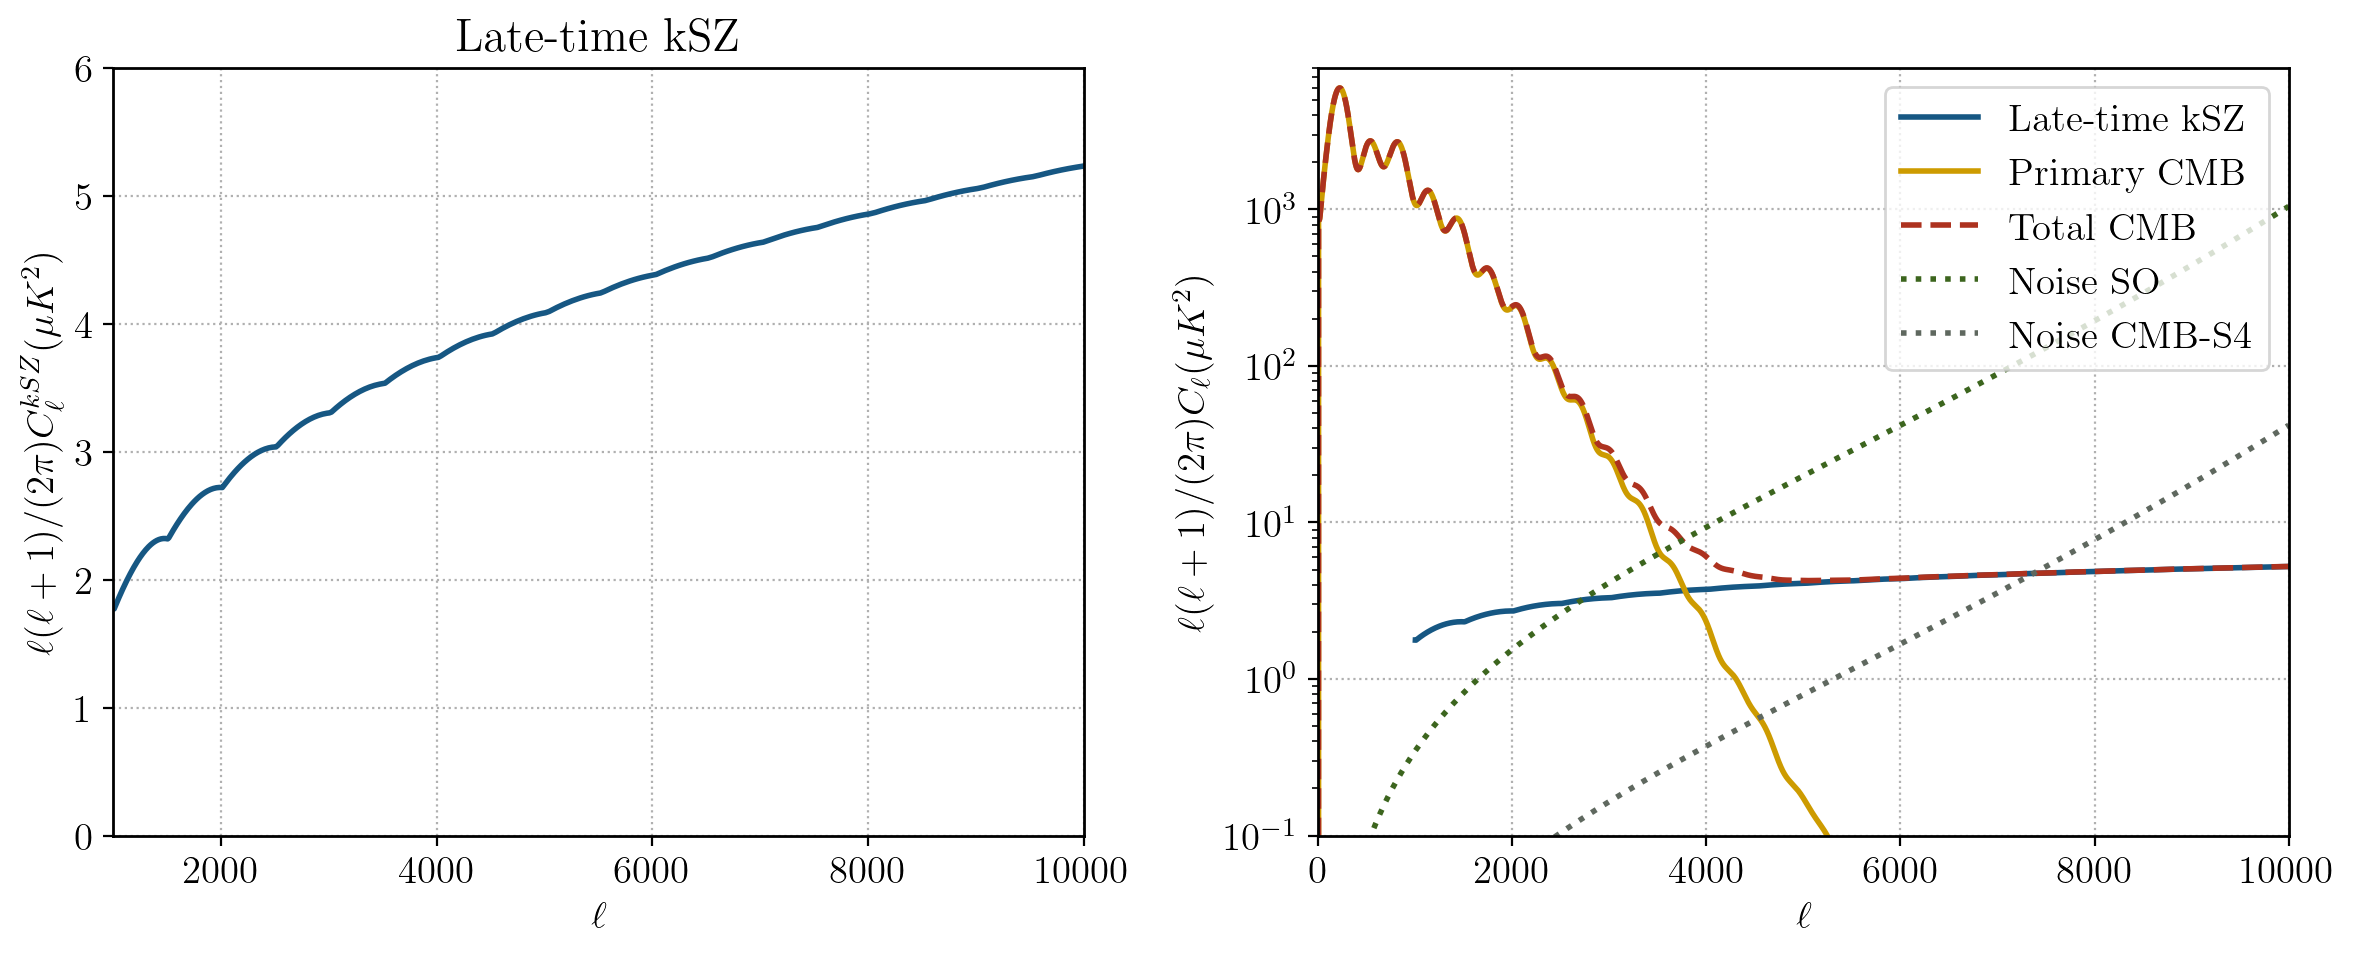

In [10]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(ls_kSZ, Cl_kSZ(ls_kSZ)*(ls_kSZ*(ls_kSZ+1))/(2.*np.pi))
plt.ylabel('$\ell(\ell +1)/(2\pi) C^{kSZ}_{\ell} (\mu K^2)$')
plt.xlabel('$\ell$')
plt.xlim(1000, 10000)
plt.ylim(0,6)
plt.title('Late-time kSZ')
plt.grid(linestyle='dotted')

plt.subplot(1,2,2)
plt.plot(ls_kSZ, Cl_kSZ(ls_kSZ)*(ls_kSZ*(ls_kSZ+1))/(2.*np.pi), label='Late-time kSZ')
plt.plot(ls[1:], cl_TT(ls[1:])*(ls[1:]*(ls[1:]+1))/(2*np.pi), label='Primary CMB')
plt.plot(ls_tot, Cl_tot(ls_tot)*(ls_tot*(ls_tot+1))/(2.*np.pi), '--', label='Total CMB')
plt.plot(ls_tot, noise_TT[0]*(ls_tot*(ls_tot+1))/(2.*np.pi), ':', label='Noise SO')
plt.plot(ls_tot, noise_TT[1]*(ls_tot*(ls_tot+1))/(2.*np.pi), ':', label='Noise CMB-S4')

plt.xlim(0, 10000)
plt.ylim(1e-1, 8e3)
plt.yscale('log')
plt.ylabel('$\ell(\ell +1)/(2\pi) C_{\ell} (\mu K^2)$')
plt.xlabel('$\ell$')
plt.legend(loc='upper right')
plt.grid(linestyle='dotted')
plt.tight_layout()

In [11]:
cosmo_params = dict(
         f_NL=0, H0=67.67, cosmomc_theta=None,
         ombh2=0.022, omch2=0.12, omk=0.0, neutrino_hierarchy='degenerate',
         num_massive_neutrinos=3, mnu=0.06, nnu=3.046,
         YHe=None, meffsterile=0.0, standard_neutrino_neff=3.046,
         TCMB=2.7255, tau=0.06, deltazrei=None, bbn_predictor=None,
         theta_H0_range=[10, 100], w=-1.0, wa=0., cs2=1.0,
         dark_energy_model='ppf',As=2.2e-09,
         # !!! Planck 2018 eq. 16/17/18 arXiv:1807.06211
         ns=0.965, nrun=0.0, nrunrun=0.0,
         r=0.0, nt=None, ntrun=0.0,
         pivot_scalar=0.05, pivot_tensor=0.05,
         parameterization=2,halofit_version='mead')

zcosmo = np.linspace(0.,15.,101)
cosmo1 = cosmo_params.copy()
cosmo1.pop('f_NL')

bias_params = dict(m=0.7, q=0.9, brsd=1., b_par=1., b_perp=1., b2=80., bv=1.) # bv parameter is added for future use of kSZ and ML seperately


nkL = 200
nmu = 100

k_large = np.logspace(np.log10(6e-4),-1,nkL) # Mpc^-1
mu_L = np.linspace(-1,1,nmu)

# halo masses
Mh = np.logspace(8,15,200) # Msun

use_z = 1.

# VROY10 properties (from 1810.13424)
vol_VRO10 = (180*u.Gpc**3).to(u.Mpc**3)
nsources_VRO10 = 1.2e-2 # Mpc^-3 # 
bg_VRO10 = 1.6

vol_DESI = (116*u.Gpc**3).to(u.Mpc**3)
nsources_DESI = 1.4e-4 # Mpc^-3 # 
bg_DESI = 1.5



Delta_T_S4 = 1.4
FWHM_S4 = 1.4

### Calculate $P_{vv}$, $N_{vv}$ and SNR for both kSZ and ML

In [288]:
_, Nvv_par_VRO10, Nvv_perp_VRO10 = get_noises(use_z, cosmo_params, k_large, mu_L, bg_VRO10, nsources_VRO10, 'VRO10', Delta_T_S4)
_, Nvv_par_DESI, Nvv_perp_DESI = get_noises(use_z, cosmo_params, k_large, mu_L, bg_DESI, nsources_DESI, 'DESI', Delta_T_S4)
_,_,_,Pvv_par,Pvv_perp,_ = get_powers(use_z, cosmo_params, bias_params, k_large, mu_L)
Pvv = Pvv_par + Pvv_perp

Nvv_VRO10_kSZ = mu_L**-2 * Nvv_par_VRO10
Nvv_DESI_kSZ = mu_L**-2 * Nvv_par_DESI

Nvv_VRO10_ML = (np.sqrt(1-mu_L**2))**-2 * Nvv_perp_VRO10
Nvv_DESI_ML = (np.sqrt(1-mu_L**2))**-2 * Nvv_perp_DESI

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  15  iterations.


/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:138: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 2.0 / Nc
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:166: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 3.0 / Nc ** 2.0
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:218: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 2.0 / Nc
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/fft.py:127: RuntimeWarning: invalid value encountered in divide
  uk = ukts / kts[None, None, :] / mnorm[..., None]
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/1920856202.py:89: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/1920856202.py:91: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_mu

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  16  iterations.
Note: redshifts have been re-sorted (earliest first)


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/3047439505.py:9: RuntimeWarning: divide by zero encountered in power
  Nvv_VRO10_ML = (np.sqrt(1-mu_L**2))**-2 * Nvv_perp_VRO10
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/3047439505.py:10: RuntimeWarning: divide by zero encountered in power
  Nvv_DESI_ML = (np.sqrt(1-mu_L**2))**-2 * Nvv_perp_DESI


Text(0.015, 0.04, '$\\mu=0.9$')

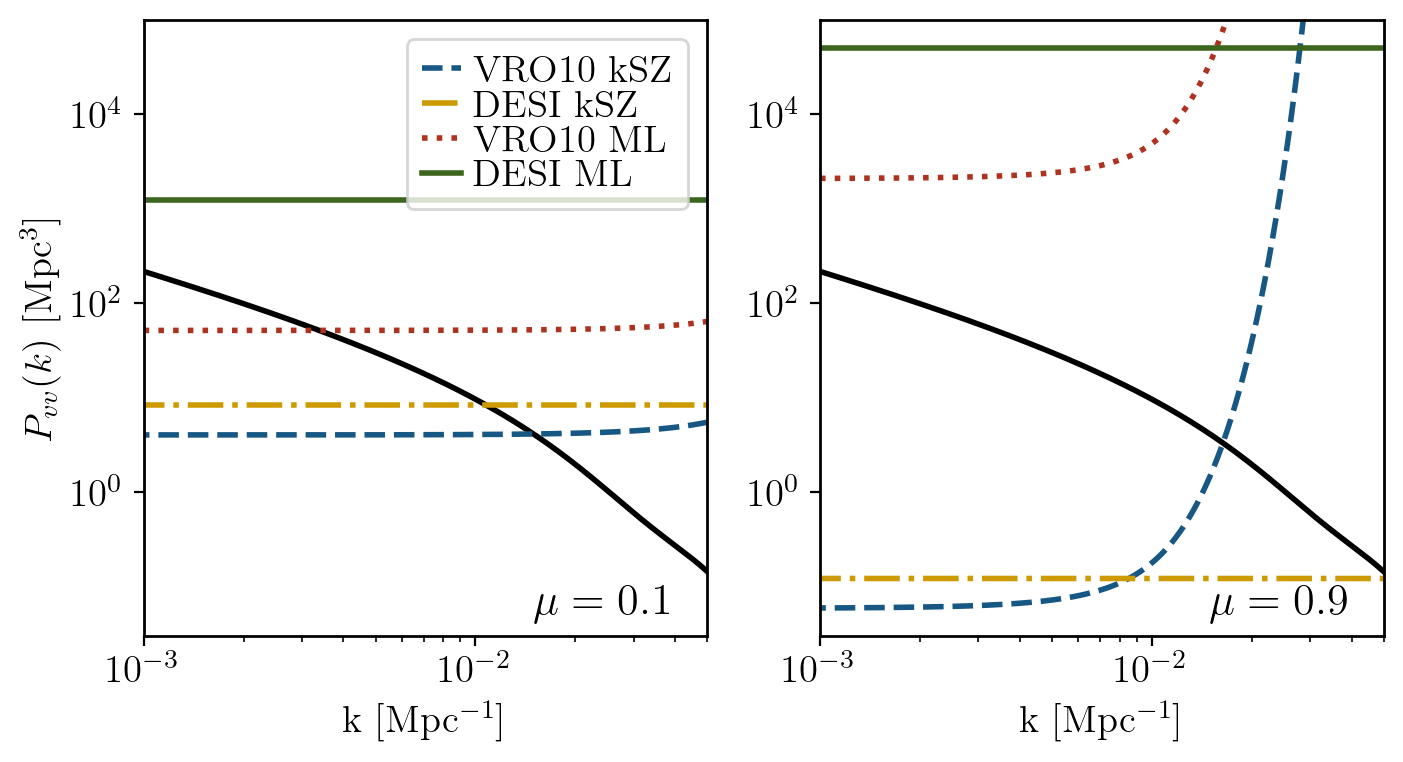

In [299]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_VRO10_kSZ[:,55], ls='--', color=palette[0], label='VRO10 kSZ')
plt.loglog(k_large, Nvv_DESI_kSZ[:,55], ls='-.', color=palette[1], label='DESI kSZ')
plt.loglog(k_large, Nvv_VRO10_ML[:,55], ls=':', color=palette[2], label='VRO10 ML')
plt.loglog(k_large, Nvv_DESI_ML[:,55], color=palette[3], label='DESI ML')
#plt.title(r'$\mu=0.1$')
plt.xlim(1e-3, 5e-2)
plt.ylim(3e-2,1e5)
plt.legend(ncol=1, handlelength=1, labelspacing=0,handletextpad=0.3, loc=1)
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'$P_{vv}(k)$ [Mpc$^3$]')
plt.text(1.5e-2, 4e-2, r'$\mu=%g$'%np.round(mu_L[55],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

plt.subplot(1,2,2)
plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_VRO10_kSZ[:,95], ls='--', color=palette[0])
plt.loglog(k_large, Nvv_DESI_kSZ[:,95], ls='-.', color=palette[1])
plt.loglog(k_large, Nvv_VRO10_ML[:,95], ls=':', color=palette[2])
plt.loglog(k_large, Nvv_DESI_ML[:,95], color=palette[3])
#plt.title(r'$\mu=0.9$')
plt.xlim(1e-3, 5e-2)
plt.ylim(3e-2,1e5)
plt.xlabel('k [Mpc$^{-1}$]')
plt.text(1.5e-2, 4e-2, r'$\mu=%g$'%np.round(mu_L[95],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/3931292122.py:18: RuntimeWarning: divide by zero encountered in divide
  noise_pot_VRO10 = ((1+zs[2])*rhoM0/2)**2/((bias_params['m']*zs[2]+bias_params['q'])**2 * ngs[2] * W_phot_VRO10**2)  # Mpc^-1
/Users/user1/anaconda3/lib/python3.10/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


Text(0, 0.5, '$k^4 P_{\\Phi \\Phi}(k)\\,[{\\rm Mpc^{-1}}]$')

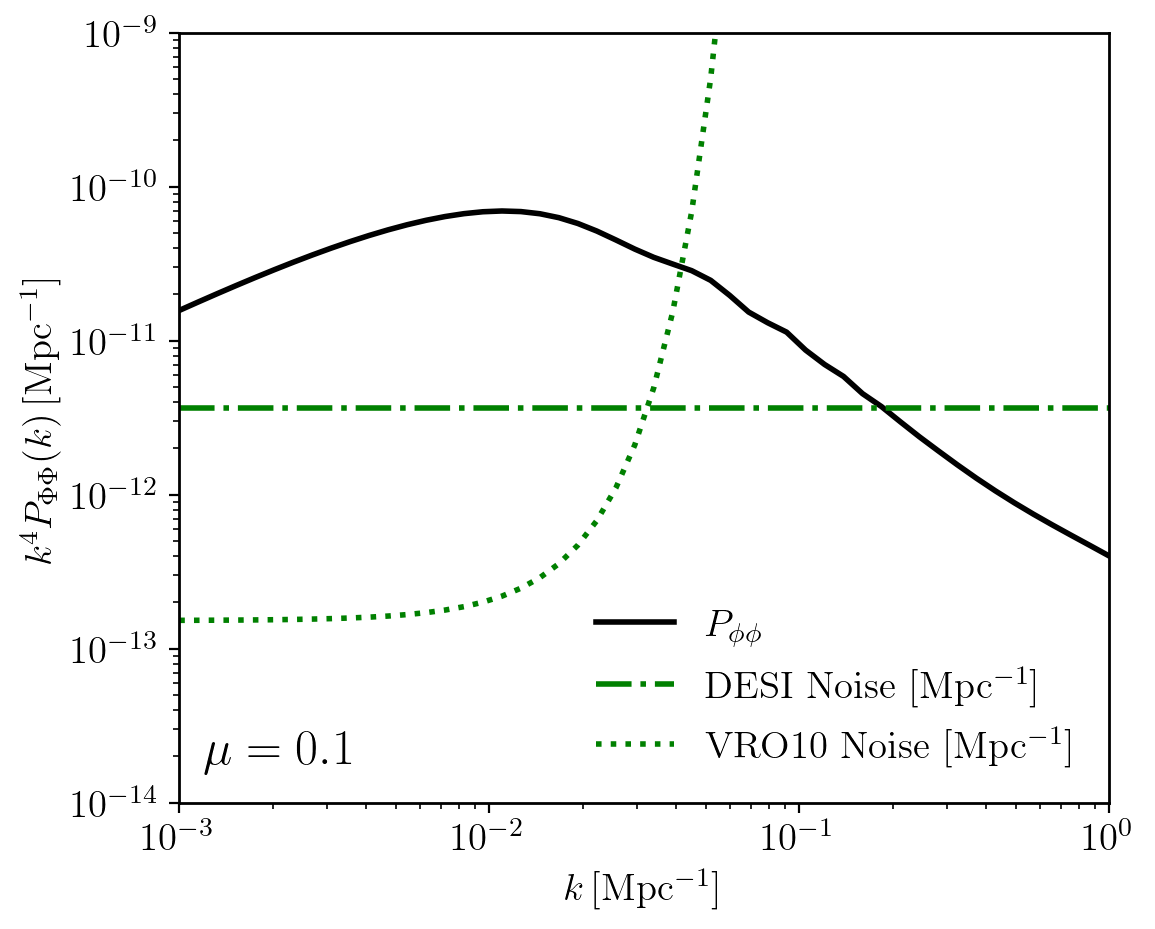

In [248]:
sigma_phot_DESI = lambda z: 0.*(1+z)
sigma_phot_VRO10 = lambda z: 0.03*(1+z)

interp_Pphiphi = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=zcosmo[-1], nz_step=150, zs=None, kmax=1e0, nonlinear=True,var1=camb.model.Transfer_Weyl, var2=camb.model.Transfer_Weyl, hubble_units=False, 
k_hunit=False, return_z_k=False, k_per_logint=None, log_interp=False,  extrap_kmax=True).P  # Mpc^3

# just for plot
k_vec = np.logspace(-3,0)
mu_use = 0.1#np.linspace(0,1)
#W_phot_kvec = np.exp(-mu_use**2*k_vec**2*sigma_phot(use_z)/2/Hz**2)
#noise_pot_vec = ((1+use_z)*rhoM0/2)**2/(bg**2 * nsources * W_phot_kvec**2)  # Mpc^-1

W_phot_DESI = np.exp(-mu_use**2*k_vec**2*sigma_phot_DESI(zs_DESI[3])/2/H(zs_DESI[3])**2)
noise_pot_DESI = ((1+zs_DESI[3])*rhoM0/2)**2/(bgs_DESI[3]**2 * ngs_DESI[3] * W_phot_DESI**2)  # Mpc^-1

W_phot_VRO10 = np.exp(-mu_use**2*k_vec**2*sigma_phot_VRO10(zs[2])/2/H(zs[2])**2)
noise_pot_VRO10 = ((1+zs[2])*rhoM0/2)**2/((bias_params['m']*zs[2]+bias_params['q'])**2 * ngs[2] * W_phot_VRO10**2)  # Mpc^-1

plt.loglog(k_vec, interp_Pphiphi(use_z,k_vec), 'k', label=r'$P_{\phi\phi}$')
plt.loglog(k_vec, noise_pot_DESI, color = 'green', ls='-.', label=r'DESI Noise $[{\rm Mpc^{-1}}]$')
plt.loglog(k_vec, noise_pot_VRO10, color = 'green', ls=':', label=r'VRO10 Noise $[{\rm Mpc^{-1}}]$')


plt.xlim(1e-3,1e0)
plt.ylim(1e-14,1e-9)
plt.legend(frameon=False)
plt.text(1.2e-3, 1.5e-14, r'$\mu=%g$'%mu_use, fontsize=18, ha='left', va='bottom', color='black', alpha=1)

plt.xlabel(r'$k\,[{\rm Mpc^{-1}}]$')
plt.ylabel(r'$k^4 P_{\Phi \Phi}(k)\,[{\rm Mpc^{-1}}]$')

# Fisher Calculations - VRO10

In [177]:

deltas = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 3e-1, 3e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
survey = 'VRO10'
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'm', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params=['b_par', 'b_perp']

xx,vx = Fisher_mat(use_z, cosmo_params, bias_params, free_params, deltas, k_large, mu_L, nsources_VRO10, survey, Delta_T_S4, vol_VRO10)

print('\n Galaxies:')
covmat_xx, cov_params = covariance_mat(xx, free_params, fixed_params+['brsd'], {})
print_1_sigmas(covmat_xx,cov_params)
print('\n Galaxies+kSZ:')
covmat_vx, cov_params = covariance_mat(vx, free_params, ['brsd'], {})
print_1_sigmas(covmat_vx,cov_params)


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  15  iterations.


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/100206092.py:89: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/100206092.py:91: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3




Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt

/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/100206092.py:375: RuntimeWarning: invalid value encountered in sqrt
  sigmas[param] = np.sqrt(cov_mat[ind,ind])


### With redsfhit binning (for VRO10)

In [23]:
deltas = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 3e-1, 3e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]

survey = 'VRO10'
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'm', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params=['b_par', 'b_perp']


zs = np.array([0.2,0.7,1.3,1.9,2.6])
bgs = np.array([1.05,1.37,1.79,2.22,2.74])
ngs = np.array([5e-2,2e-2,6e-3,15e-4,3e-4])
vs = (np.array([5.2,43.6,75.9,89.3,119.9])*u.Gpc**3).to(u.Mpc**3)
bias1 = bias_params.copy()

Fz_XX=np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vX=np.zeros((len(zs),len(free_params),len(free_params)))
for i in range(len(zs)):
    
    xx,vx = Fisher_mat(zs[i], cosmo_params, bias_params, free_params, deltas, k_large, mu_L, ngs[i], survey, Delta_T_S4, vs[i])
    Fz_XX[i,:,:]=xx
    Fz_vX[i,:,:]=vx


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_63659/3506432953.py:89: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_63659/3506432953.py:91: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3




Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_p

In [24]:
F_vX = np.sum(Fz_vX, axis=0)
F_XX = np.sum(Fz_XX, axis=0)


print('Galaxies:')
covmat_xx, cov_params = covariance_mat(F_XX, free_params, fixed_params+['brsd'], {})
print_1_sigmas(covmat_xx,cov_params)
print('\n Galaxies+kSZ:')
covmat_vx, cov_params = covariance_mat(F_vX, free_params, ['brsd'], {})
print_1_sigmas(covmat_vx,cov_params)

Galaxies:


1-sigma of H0 is 3.199634672177398
1-sigma of ombh2 is 0.0004156236792738453
1-sigma of omch2 is 0.0019277582244631082
1-sigma of ns is 0.01687183047940051
1-sigma of As is 3.267695996841781e-10
1-sigma of tau is 118.51522086283852
1-sigma of mnu is 0.3786527980971429
1-sigma of m is 0.025422647064080043
1-sigma of q is 0.04059696545720071
1-sigma of b2 is 3.1384664738670147

 Galaxies+kSZ:


1-sigma of H0 is 1.9493948108374148
1-sigma of ombh2 is 0.00041429617972327807
1-sigma of omch2 is 0.0019200323988872426
1-sigma of ns is 0.016435420103770686
1-sigma of As is 1.021559119879359e-10
1-sigma of tau is 63.74150409508276
1-sigma of mnu is 0.3466300073260367
1-sigma of m is 0.018562955117785804
1-sigma of q is 0.02081719516468429
1-sigma of b_par is 0.01999112145079456
1-sigma of b_perp is 0.03278573592037769
1-sigma of b2 is 2.335978393864416


Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu)$ [eV]')

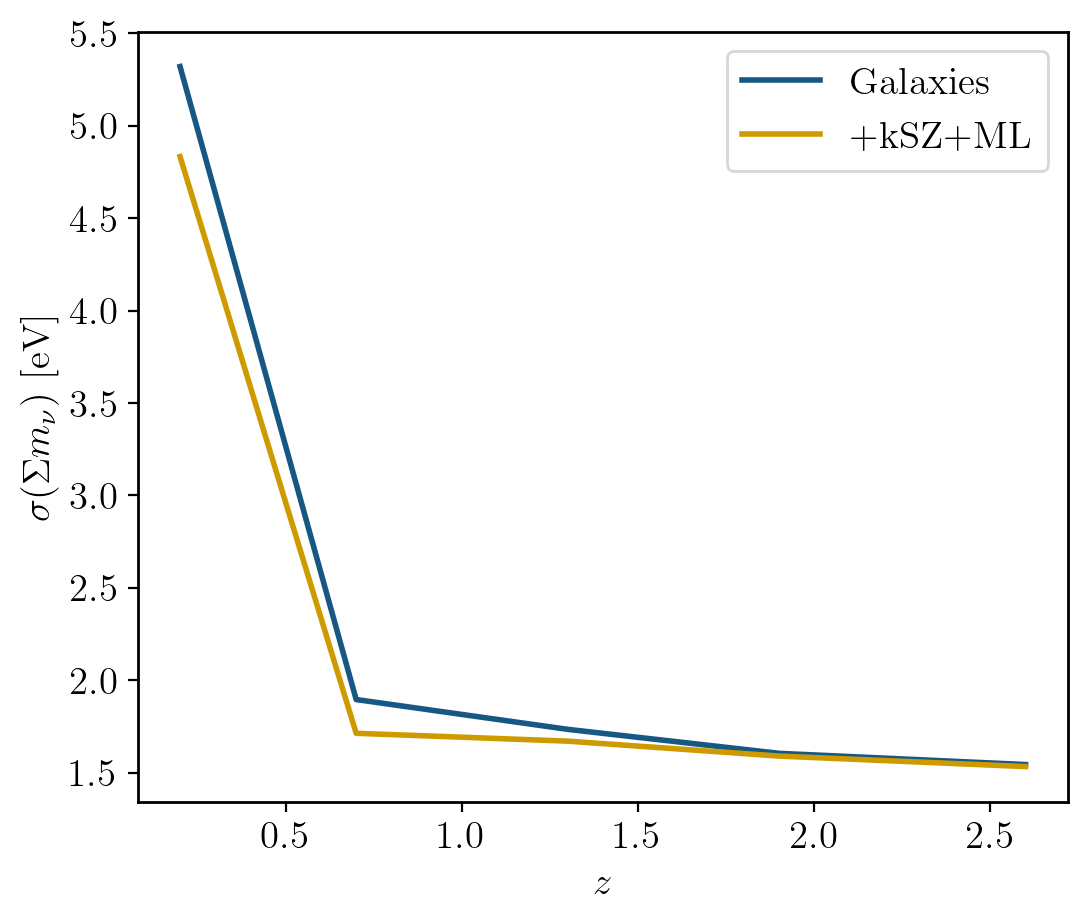

In [373]:

mnu_ind = free_params.index('mnu')
sig_mnu_VRO10_bins = np.zeros(len(zs))
sig_mnu_VRO10_kSZ_bins = np.zeros(len(zs))
for i in range(len(zs)):
    covmat_gal_z, cov_params = covariance_mat(Fz_XX[i], free_params, fixed_params, {})
    sig_mnu_VRO10_bins[i] = np.sqrt(covmat_gal_z[mnu_ind,mnu_ind])
    covmat_gal_kSZ_z, cov_params = covariance_mat(Fz_vX[i], free_params, [], {})
    sig_mnu_VRO10_kSZ_bins[i] = np.sqrt(covmat_gal_kSZ_z[mnu_ind,mnu_ind])

plt.plot(zs, sig_mnu_VRO10_bins, label='Galaxies')
plt.plot(zs, sig_mnu_VRO10_kSZ_bins, label='+kSZ+ML')
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$\sigma(\Sigma m_\nu)$ [eV]')

In [380]:
F_bao_CMB_S4_L = np.zeros((len(F_XX), len(F_XX)))
F_bao_CMB_S4_L[:7,:7] = F_bao_CMB_S4


print('CMB+Galaxies:')
covmat_xx, cov_params = covariance_mat(F_bao_CMB_S4_L+F_XX, free_params, fixed_params+['brsd'], {})
print_1_sigmas(covmat_xx,cov_params)
print('\n CMB+Galaxies+kSZ:')
covmat_vx, cov_params = covariance_mat(F_bao_CMB_S4_L+F_vX, free_params, ['brsd'], {})
print_1_sigmas(covmat_vx,cov_params)

CMB+Galaxies:


1-sigma of H0 is 0.22580962649346487
1-sigma of ombh2 is 3.0331436346996443e-05
1-sigma of omch2 is 0.0004894078205638786
1-sigma of ns is 0.0019301827072130137
1-sigma of As is 3.347923354032929e-11
1-sigma of tau is 0.008348784601315228
1-sigma of mnu is 0.030764372541274742
1-sigma of m is 0.0038614716096767032
1-sigma of q is 0.00552377998805603
1-sigma of b2 is 0.6439807122924485

 CMB+Galaxies+kSZ:


1-sigma of H0 is 0.22264489055142833
1-sigma of ombh2 is 3.0298103988287796e-05
1-sigma of omch2 is 0.00047865759468544895
1-sigma of ns is 0.0019127766559720377
1-sigma of As is 3.2307638789531315e-11
1-sigma of tau is 0.008065021878844732
1-sigma of mnu is 0.02977072307956791
1-sigma of m is 0.0036649718498947487
1-sigma of q is 0.005262427983059294
1-sigma of b_par is 0.0038787440953120525
1-sigma of b_perp is 0.025198094204045434
1-sigma of b2 is 0.6347942332387878


Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu)$ [meV]')

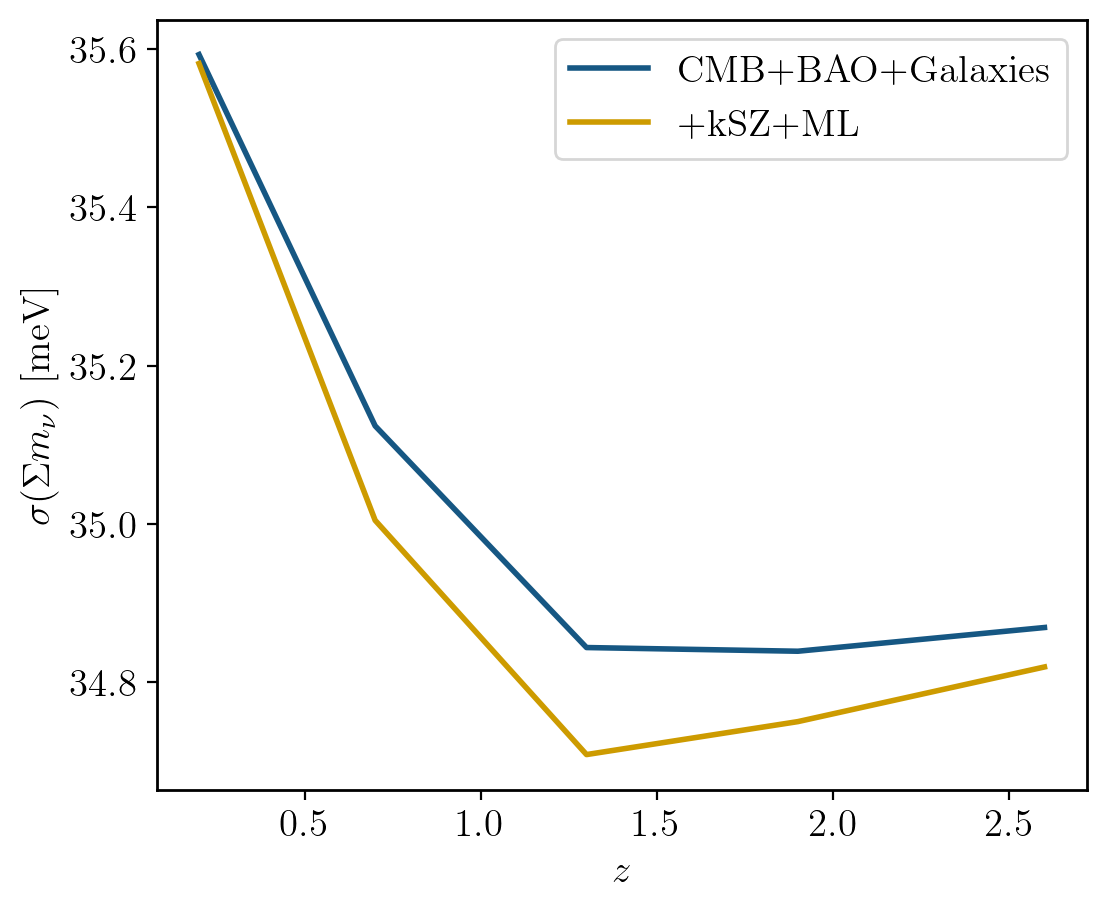

In [375]:
for i in range(len(zs)):
    covmat_gal_z, cov_params = covariance_mat(F_bao_CMB_L+Fz_XX[i], free_params, fixed_params, {})
    sig_mnu_VRO10_bins[i] = np.sqrt(covmat_gal_z[mnu_ind,mnu_ind])
    covmat_gal_kSZ_z, cov_params = covariance_mat(F_bao_CMB_L+Fz_vX[i], free_params, [], {})
    sig_mnu_VRO10_kSZ_bins[i] = np.sqrt(covmat_gal_kSZ_z[mnu_ind,mnu_ind])

plt.plot(zs, sig_mnu_VRO10_bins*1e3, label='CMB+BAO+Galaxies')
plt.plot(zs, sig_mnu_VRO10_kSZ_bins*1e3, label='+kSZ+ML')
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$\sigma(\Sigma m_\nu)$ [meV]')

A test of how adding $b_\parallel$ prior affect the neutrino masses error

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu)$')

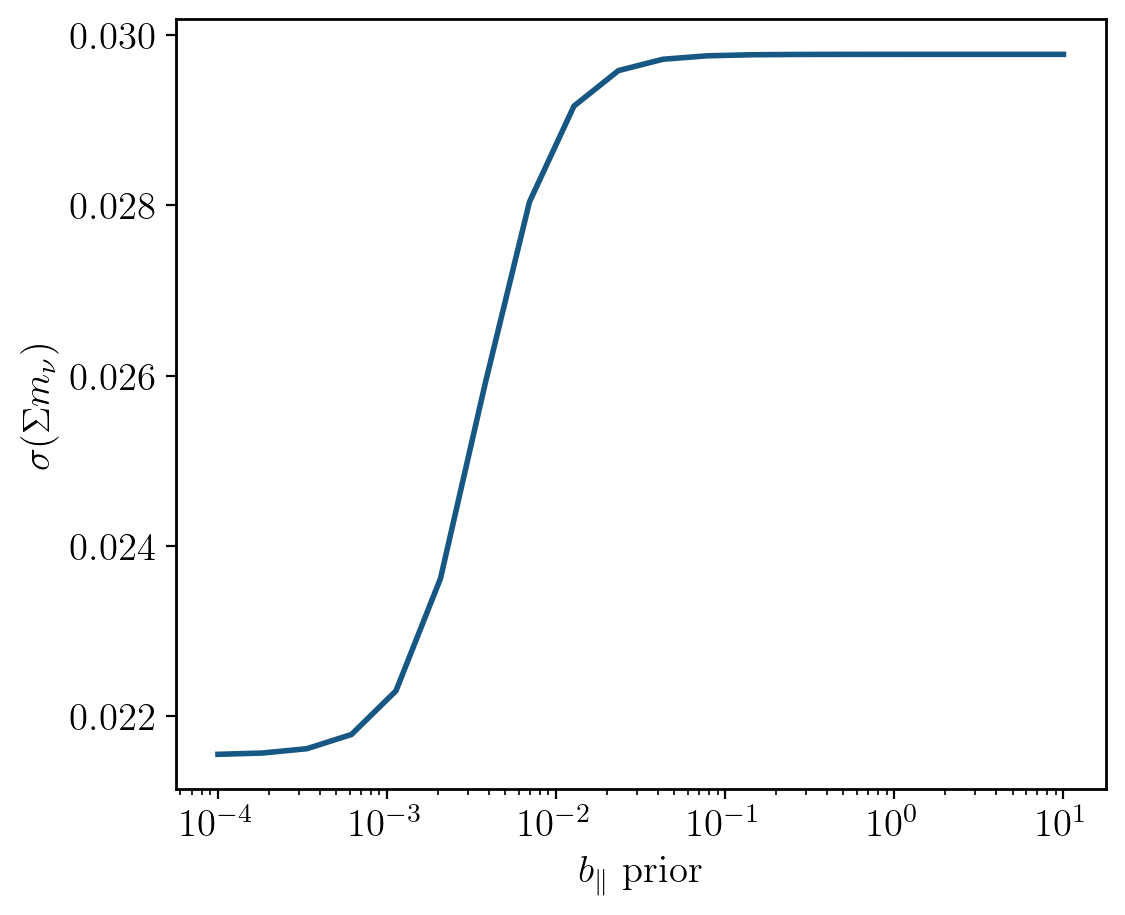

In [378]:
F_bao_CMB_S4_L = np.zeros((len(F_XX), len(F_XX)))
F_bao_CMB_S4_L[:7,:7] = F_bao_CMB_S4

priors = np.logspace(-4,1,20)
sig_mnu_prior_bpar = np.zeros(len(priors))

for i in range(len(priors)):
    #covmat_vx, cov_params = covariance_mat(F_bao_CMB_S4_L+F_vX_t[4], free_params, ['brsd'], {'b_par':priors[i]})#, 'm':0.07,'q':0.09,'b2':8,'b_perp':0.1})
    covmat_vx, cov_params = covariance_mat(F_bao_CMB_S4_L+F_vX, free_params, ['brsd'], {'b_par':priors[i]})#, 'm':0.07,'q':0.09,'b2':8,'b_perp':0.1})
    sig_mnu_prior_bpar[i] = np.sqrt(covmat_vx[mnu_ind,mnu_ind])

plt.semilogx(priors,sig_mnu_prior_bpar)
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu)$')


Text(0.5, 0.98, 'CMB-S4 noise parameters')

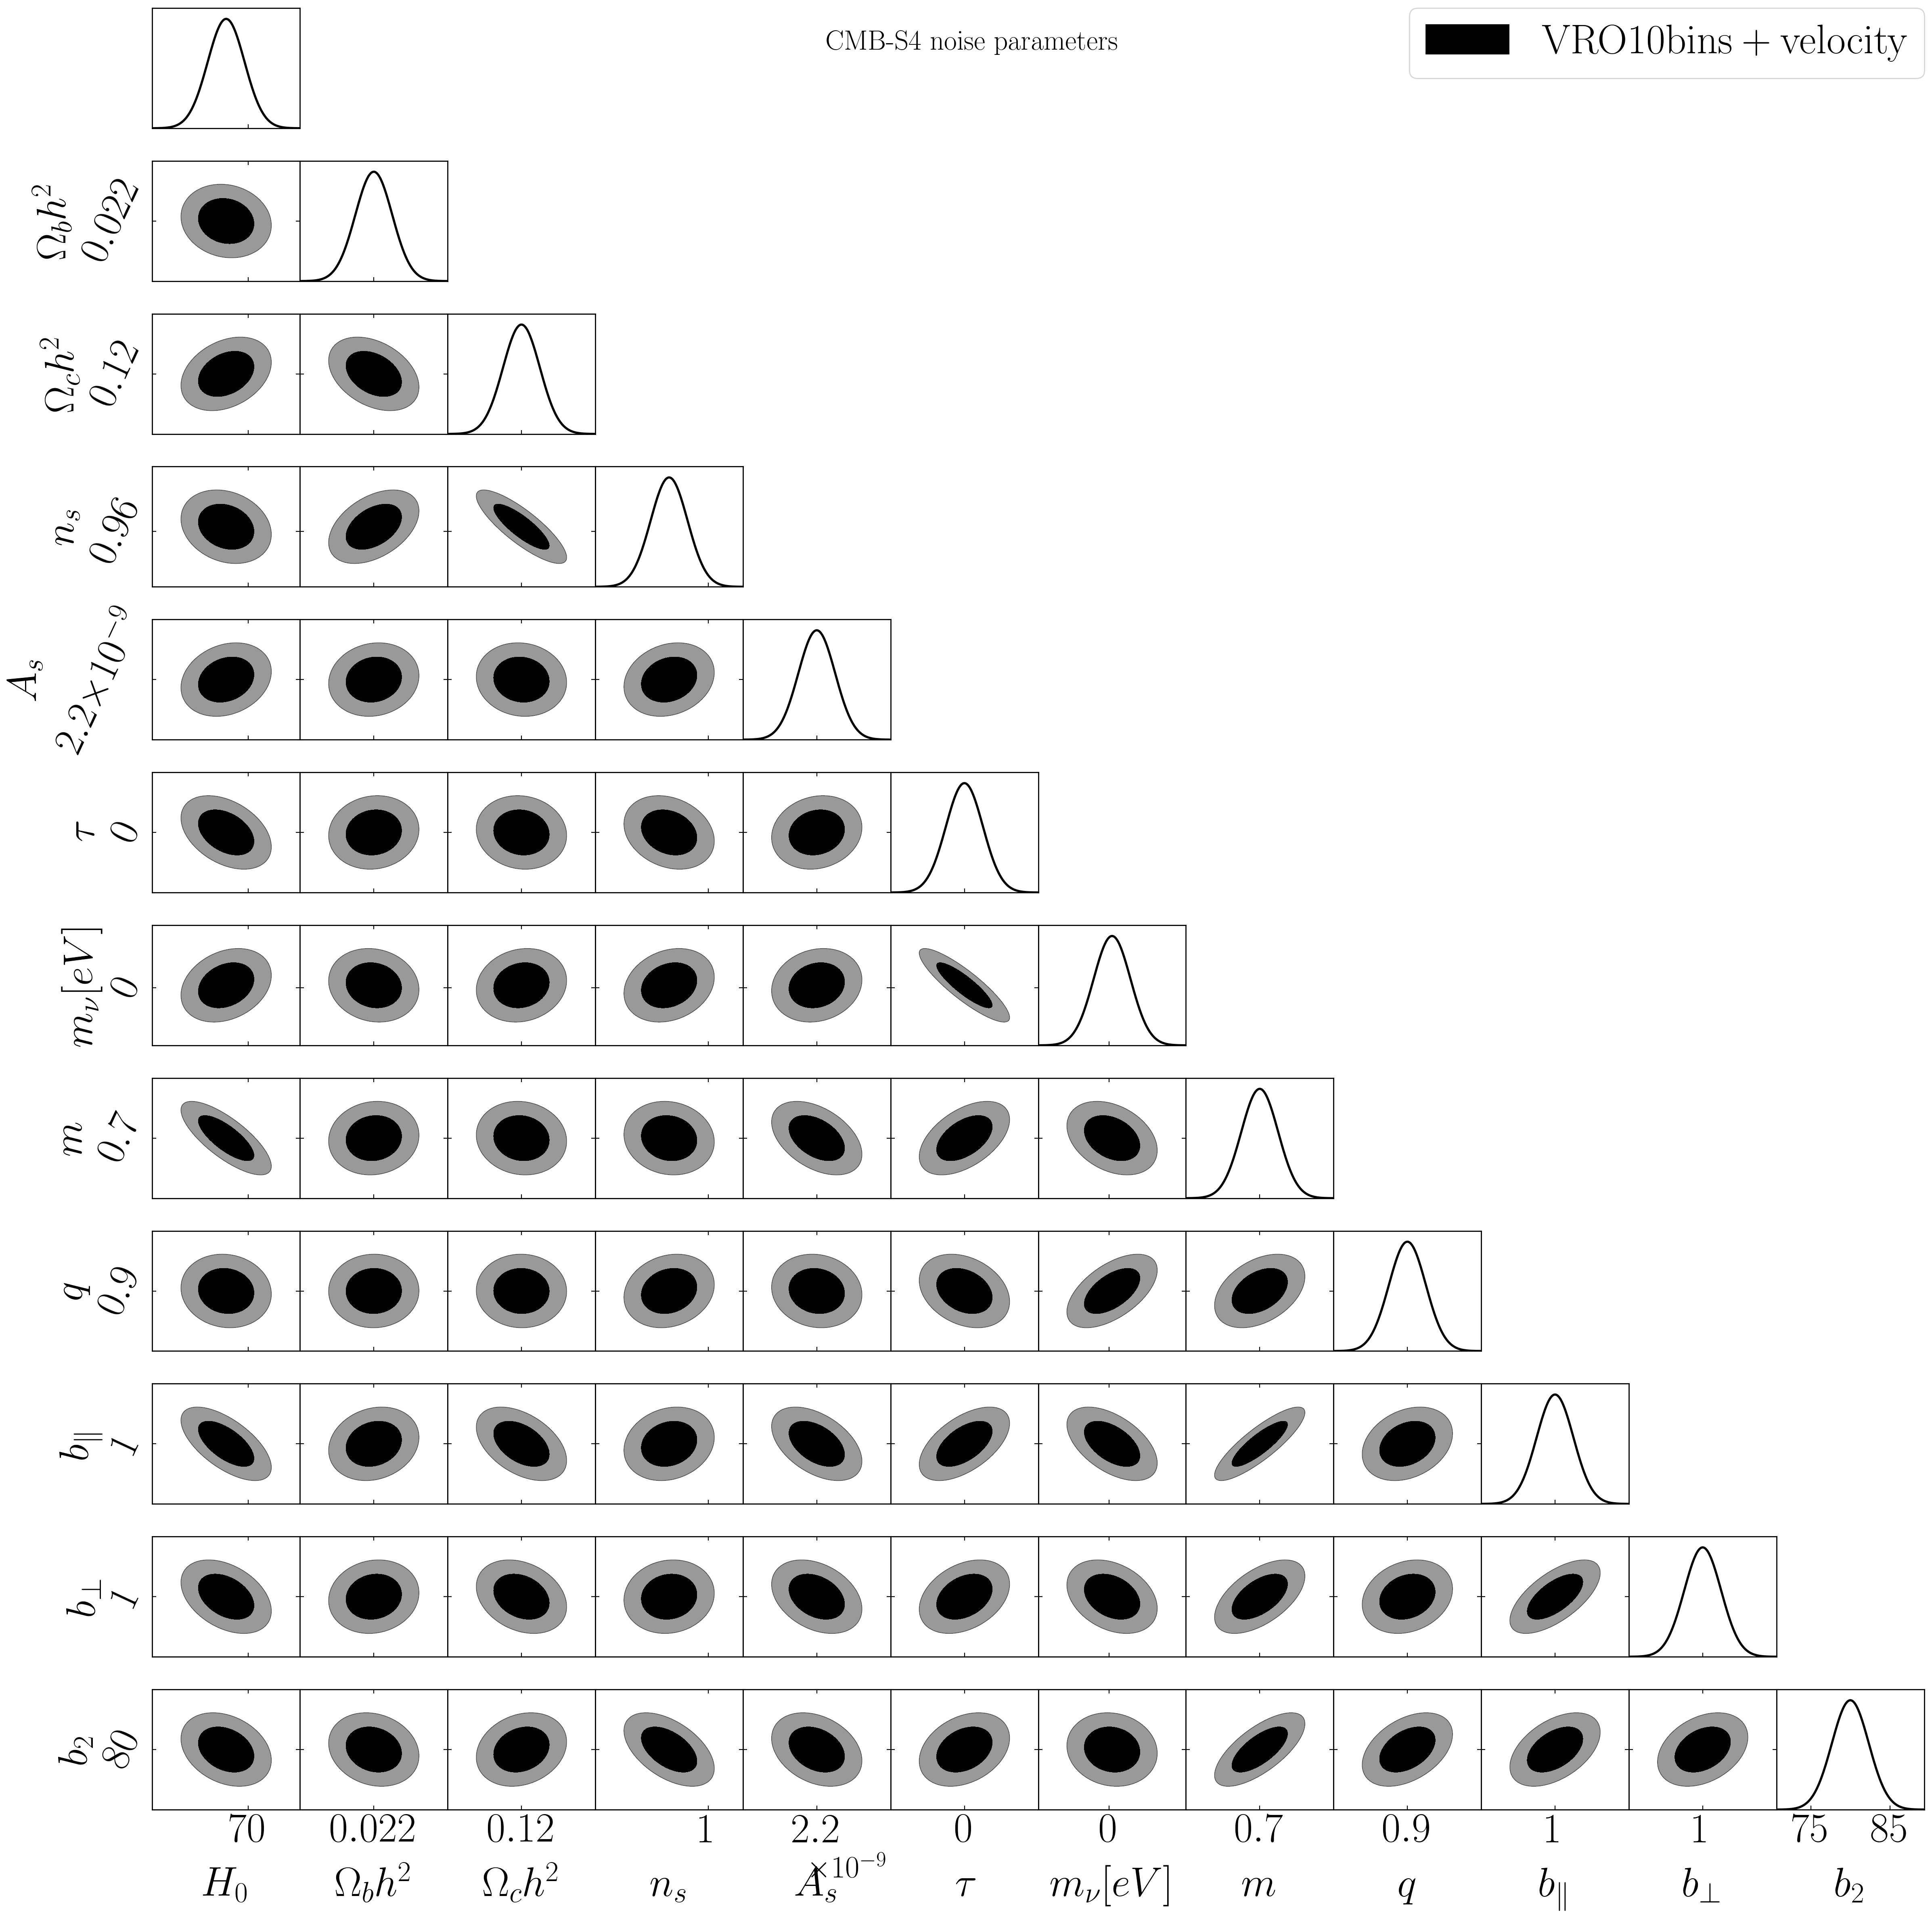

In [385]:
param_list = free_params.copy()
param_list.remove('brsd')

fiducials = np.zeros(len(param_list))
for i in range(len(param_list)):
    param = param_list[i]
    if param in cosmo_params:
        fiducials[i] = cosmo_params[param]
    else:
        fiducials[i] = bias_params[param]

names_all = [r'$H_0$',
             r'$\Omega_bh^2$',
             r'$\Omega_ch^2$',
             r'$n_s$',
             r'$A_s$',
             r'$\tau$',
             r'$m_\nu[eV]$',
             r'$m$',
             r'$q$',
             #r'$b_\mathrm{rsd}$',
             r'$b_\parallel$',
             r'$b_\perp$',
             r'$b_2$',
           ]


from getdist import plots as gp

#covmat_vx, cov_params = covariance_mat(F_bao_CMB_DT+F_vX_t[4], free_params, fixed_params, {})
#covmat_vx, cov_params = covariance_mat(F_vX_t[4], free_params, [], {})
covmat_vx, cov_params = covariance_mat(F_vX, free_params, ['brsd'], {})

plot_dist = GaussianND(fiducials, covmat_vx, names=names_all)			

settings = gp.GetDistPlotSettings()

settings.norm_prob_label = False
settings.axes_fontsize = 40
settings.legend_fontsize = 40
settings.lab_fontsize = 40

g = gp.get_subplot_plotter(settings=settings)

g.settings.figure_legend_frame = True
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14
g.settings.axis_tick_y_rotation = 65

g.triangle_plot([plot_dist], names_all, filled=True,\
    legend_labels=[r'${\rm VRO10 bins + velocity}$'],legend_loc='upper right',\
    contour_colors=['k'], line_args=[{'lw':2, 'color':'k'}], markers={'x2':0})

g.fig.suptitle("CMB-S4 noise parameters", fontsize=25)


## Plots for paper

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

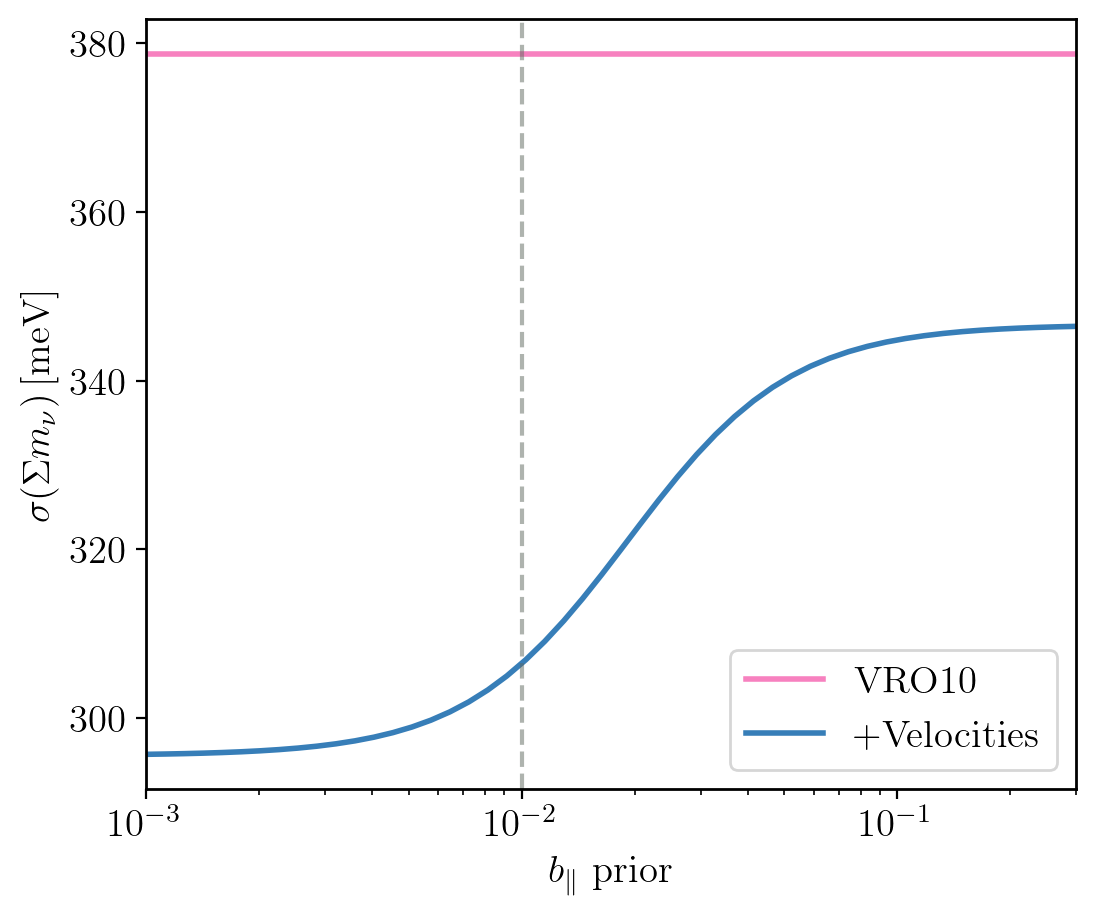

In [50]:
#bpar_pr = np.linspace(1e-4,1e-1,100)
bpar_pr = np.logspace(-3,np.log10(3e-1),50)

mnu_ind = free_params.index('mnu')
sig_mnu_gal = np.zeros(len(bpar_pr))
sig_mnu_gal_vel = np.zeros(len(bpar_pr))

for i in range(len(bpar_pr)):
    covmat_lim, cov_params = covariance_mat(F_XX, free_params, fixed_params+['brsd'], {})
    sig_mnu_gal[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_vX, free_params, ['brsd'], {'b_par':bpar_pr[i]})
    sig_mnu_gal_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(bpar_pr, sig_mnu_gal*1e3, label='VRO10', color=palette[8])
plt.plot(bpar_pr, sig_mnu_gal_vel*1e3, label='+Velocities', color=palette[5])
plt.axvline(x = 1e-2, color = palette[4], alpha=0.5, ls='--', lw=1.5)

plt.xscale('log')
plt.xlim(bpar_pr[0],bpar_pr[-1])
plt.legend()
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
#plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
#plt.ylim(60,75)

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

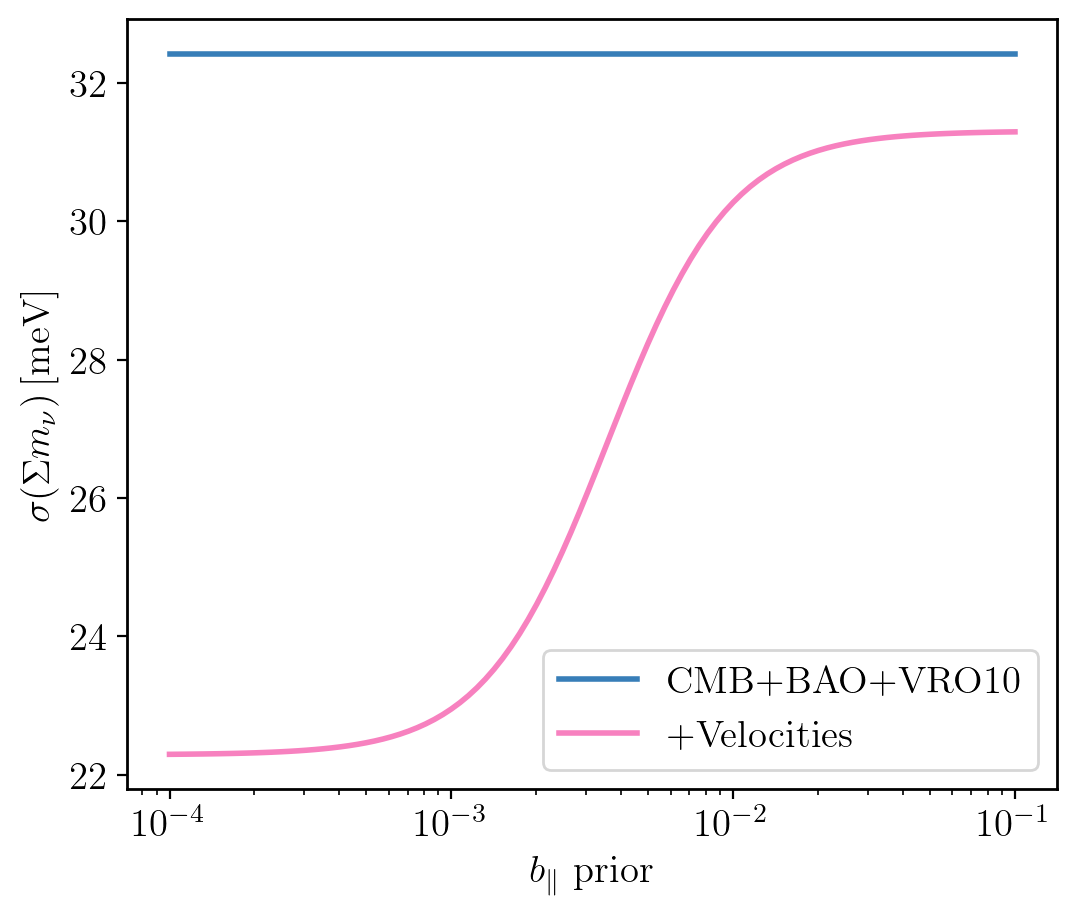

In [30]:
bpar_pr = np.logspace(np.log10(1e-4),-1,100)

mnu_ind = free_params.index('mnu')
sig_mnu_gal = np.zeros(len(bpar_pr))
sig_mnu_gal_vel = np.zeros(len(bpar_pr))

F_bao_CMB_S4_L = np.zeros((len(F_XX), len(F_XX)))
F_bao_CMB_S4_L[:7,:7] = F_bao_CMB_S4

for i in range(len(bpar_pr)):
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_S4_L+F_XX, free_params, fixed_params+['brsd'], {})
    sig_mnu_gal[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_bao_CMB_S4_L+F_vX, free_params, ['brsd'], {'b_par':bpar_pr[i]})
    sig_mnu_gal_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(bpar_pr, sig_mnu_gal*1e3, label='CMB+BAO+VRO10', color=palette[5])
plt.plot(bpar_pr, sig_mnu_gal_vel*1e3, label='+Velocities', color=palette[8])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
#plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
#plt.ylim(60,75)

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

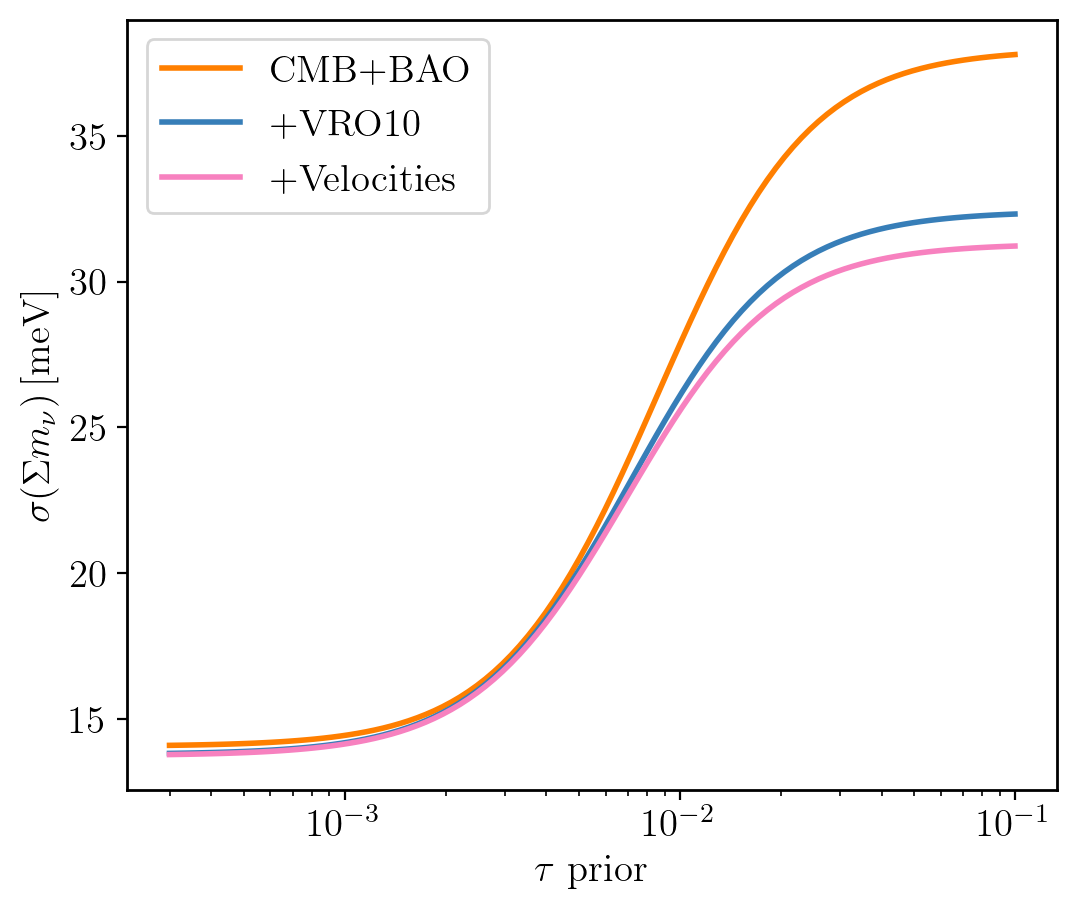

In [131]:
#bpar_pr = np.linspace(1e-4,1e-1,100)
tau_pr = np.logspace(np.log10(3e-4),-1,100)

mnu_ind = free_params.index('mnu')
sig_mnu = np.zeros(len(tau_pr))
sig_mnu_gal = np.zeros(len(tau_pr))
sig_mnu_gal_vel = np.zeros(len(tau_pr))

for i in range(len(tau_pr)):
    covmat, cov_params = covariance_mat(F_bao_CMB_S4, free_params2, [], {'tau':tau_pr[i]})
    sig_mnu[i] = np.sqrt(covmat[mnu_ind,mnu_ind])
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_S4_L+F_XX, free_params, fixed_params+['brsd'], {'tau':tau_pr[i]})
    sig_mnu_gal[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_bao_CMB_S4_L+F_vX, free_params, ['brsd'], {'tau':tau_pr[i]})
    sig_mnu_gal_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])
    

plt.plot(tau_pr, sig_mnu*1e3, label='CMB+BAO', color=palette[6])
plt.plot(tau_pr, sig_mnu_gal*1e3, label='+VRO10', color=palette[5])
plt.plot(tau_pr, sig_mnu_gal_vel*1e3, label='+Velocities', color=palette[8])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\tau$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
#plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
#plt.ylim(60,75)

Text(0.5, 1.0, 'with 1\\% prior on $b_\\parallel$')

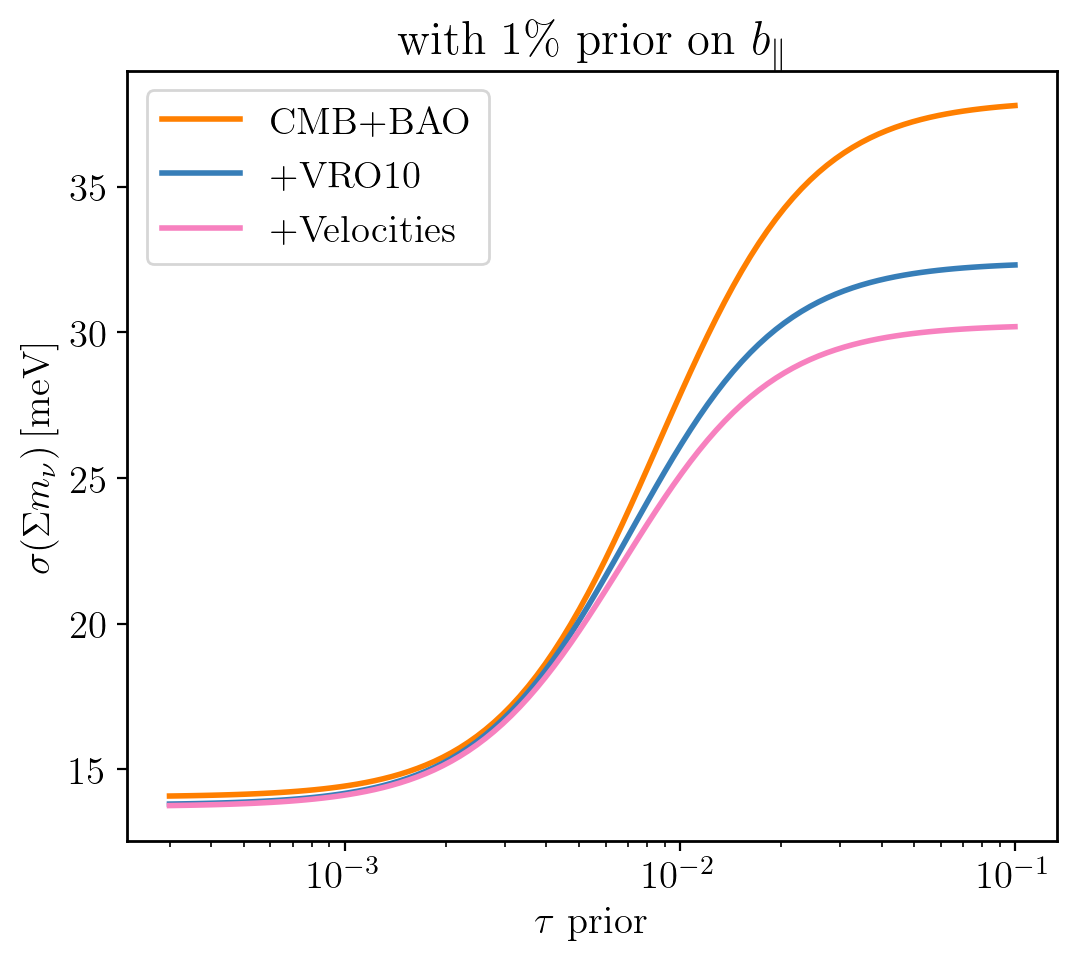

In [31]:
#bpar_pr = np.linspace(1e-4,1e-1,100)
tau_pr = np.logspace(np.log10(3e-4),-1,100)

mnu_ind = free_params.index('mnu')
sig_mnu = np.zeros(len(tau_pr))
sig_mnu_gal = np.zeros(len(tau_pr))
sig_mnu_gal_vel = np.zeros(len(tau_pr))

for i in range(len(tau_pr)):
    covmat, cov_params = covariance_mat(F_bao_CMB_S4, free_params2, [], {'tau':tau_pr[i]})
    sig_mnu[i] = np.sqrt(covmat[mnu_ind,mnu_ind])
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_S4_L+F_XX, free_params, fixed_params+['brsd'], {'tau':tau_pr[i]})
    sig_mnu_gal[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_bao_CMB_S4_L+F_vX, free_params, ['brsd'], {'tau':tau_pr[i],'b_par':0.01})
    sig_mnu_gal_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])
    

plt.plot(tau_pr, sig_mnu*1e3, label='CMB+BAO', color=palette[6])
plt.plot(tau_pr, sig_mnu_gal*1e3, label='+VRO10', color=palette[5])
plt.plot(tau_pr, sig_mnu_gal_vel*1e3, label='+Velocities', color=palette[8])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\tau$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.title(r'with 1\% prior on $b_\parallel$')
#plt.ylim(60,75)

## Vary $\Delta_T$

In [307]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr = np.zeros(len(Delta_Ts))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']

In [308]:

ARCMIN_TO_RAD = 1./60.*np.pi/180.

fsky=0.4

deltas = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 3e-1, 3e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
survey = 'VRO10'
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'm', 'q', 'brsd', 'b_par', 'b_perp', 'b2']

F_XX_t = []
F_vX_t = []

zs = np.array([0.2,0.7,1.3,1.9,2.6])
bgs = np.array([1.05,1.37,1.79,2.22,2.74])
ngs = np.array([5e-2,2e-2,6e-3,15e-4,3e-4])
vs = (np.array([5.2,43.6,75.9,89.3,119.9])*u.Gpc**3).to(u.Mpc**3)

for t in range(len(Delta_Ts)):
    
    Fz_XX=np.zeros((len(zs),len(free_params),len(free_params)))
    Fz_vX=np.zeros((len(zs),len(free_params),len(free_params)))
    for i in range(len(zs)):
        xx,vx = Fisher_mat(zs[i], cosmo_params, bias_params, free_params, deltas, k_large, mu_L, ngs[i], survey, Delta_Ts[t], vs[i])
        Fz_XX[i,:,:]=xx
        Fz_vX[i,:,:]=vx
        
    F_vX_t.append(np.sum(Fz_vX, axis=0))
    F_XX_t.append(np.sum(Fz_XX, axis=0))

    
with open(fisher_root+'F_vX_DeltaT_VRO10.pkl', 'wb') as file: 
    pickle.dump(F_vX_t, file)
    
with open(fisher_root+'F_XX_DeltaT_VRO10.pkl', 'wb') as file: 
    pickle.dump(F_XX_t, file)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:138: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 2.0 / Nc
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:166: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 3.0 / Nc ** 2.0
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:218: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 2.0 / Nc
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/fft.py:127: RuntimeWarning: invalid value encountered in divide
  uk = ukts / kts[None, None, :] / mnorm[..., None]
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/1920856202.py:89: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/1920856202.py:91: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_mu



Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_p

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of



Now simulating for (1-delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, th



Now simulating for (1+delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 



Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this i



Now simulating for (1+delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out



Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this



Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


Now simulating for (1+delta)H0, this is parameter #1



Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshift



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  16  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest fi



Now simulating for (1-delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, th

(0.01, 0.06)

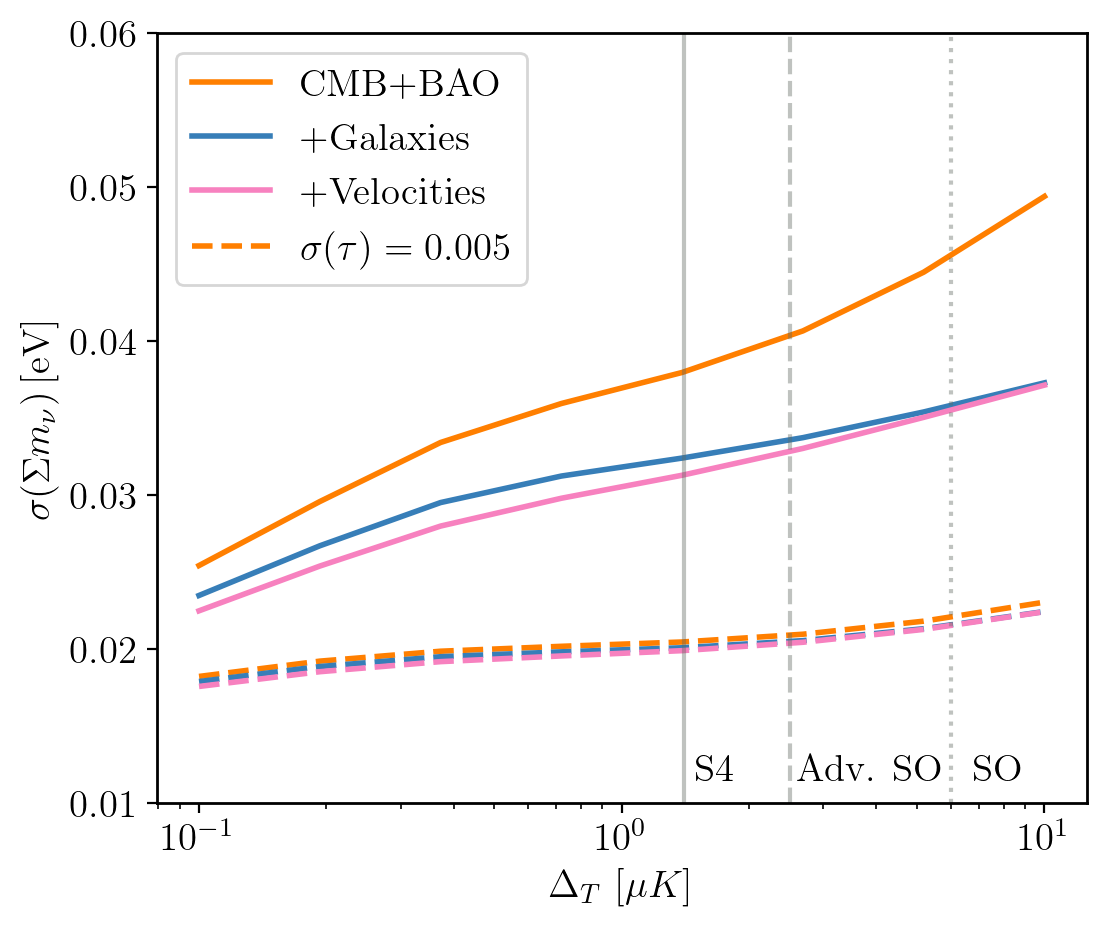

In [314]:

fixed_params = ['b_par', 'b_perp']

for t in range(len(Delta_Ts)):
    F_bao_CMB_L = np.zeros((len(free_params), len(free_params)))
    #F_S4_t = F_CMB_DT['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_CMB_DT
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_bao_CMB_L[:7,:7] = F_S4_t
    F_bao_L = np.zeros((len(free_params), len(free_params)))
    F_bao_L[:7,:7] = F_bao
    F_planck_lowell_L = np.zeros((len(free_params), len(free_params)))
    F_planck_lowell_L[:7,:7] = F_planck_lowell
    F_bao_CMB_DT = F_bao_CMB_L + F_bao_L + F_planck_lowell_L
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {})
    sig_mnu_DT[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {'tau':0.005})
    sig_mnu_DT_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+['brsd'], {})
    sig_mnu_gal_DT[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT+F_vX, free_params, ['brsd'], {})
    sig_mnu_gal_vel_DT[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+['brsd'], {'tau':0.005})
    sig_mnu_gal_DT_pr[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT+F_vX, free_params, ['brsd'], {'tau':0.005})
    sig_mnu_gal_vel_DT_pr[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])



plt.plot(Delta_Ts, sig_mnu_DT, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_DT, label='+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr, label=r'$\sigma(\tau)=0.005$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 0.011, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 0.011, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 0.011, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.ylim(0.01,0.06)



(0.01, 0.06)

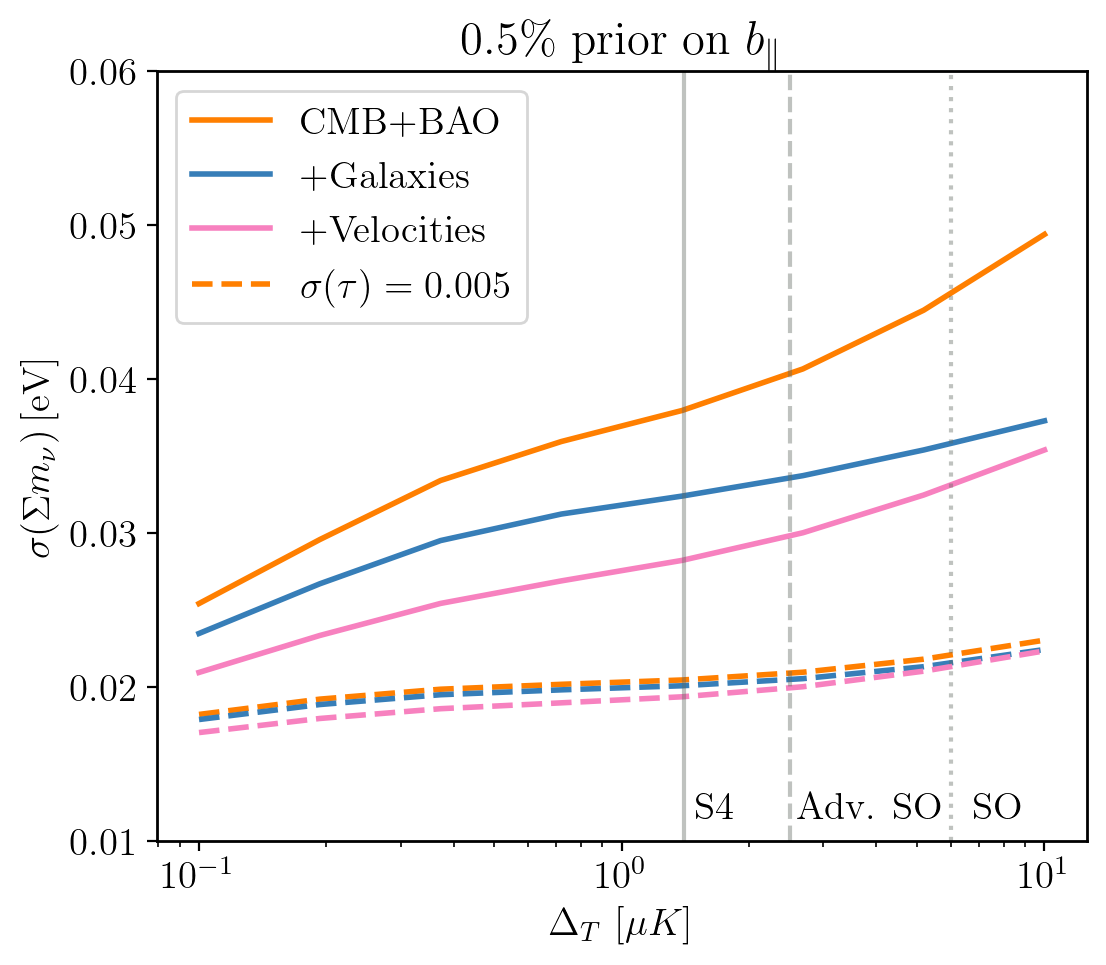

In [316]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr = np.zeros(len(Delta_Ts))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']

bpar_pr = 0.005

for t in range(len(Delta_Ts)):
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_bao_CMB_L[:7,:7] = F_S4_t
    F_bao_L = np.zeros((len(free_params), len(free_params)))
    F_bao_L[:7,:7] = F_bao
    F_planck_lowell_L = np.zeros((len(free_params), len(free_params)))
    F_planck_lowell_L[:7,:7] = F_planck_lowell
    F_bao_CMB_DT = F_bao_CMB_L + F_bao_L + F_planck_lowell_L
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {})
    sig_mnu_DT[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {'tau':0.005})
    sig_mnu_DT_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+[], {})
    sig_mnu_gal_DT[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT+F_vX, free_params, ['brsd'], {'b_par':bpar_pr})
    sig_mnu_gal_vel_DT[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+[], {'tau':0.005})
    sig_mnu_gal_DT_pr[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT+F_vX, free_params, ['brsd'], {'tau':0.005,'b_par':bpar_pr})
    sig_mnu_gal_vel_DT_pr[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])


plt.plot(Delta_Ts, sig_mnu_DT, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_DT, label='+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr, label=r'$\sigma(\tau)=0.005$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 0.011, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 0.011, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 0.011, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'0.5\% prior on $b_\parallel$')
plt.ylim(0.01,0.06)

(0.1, 0.4)

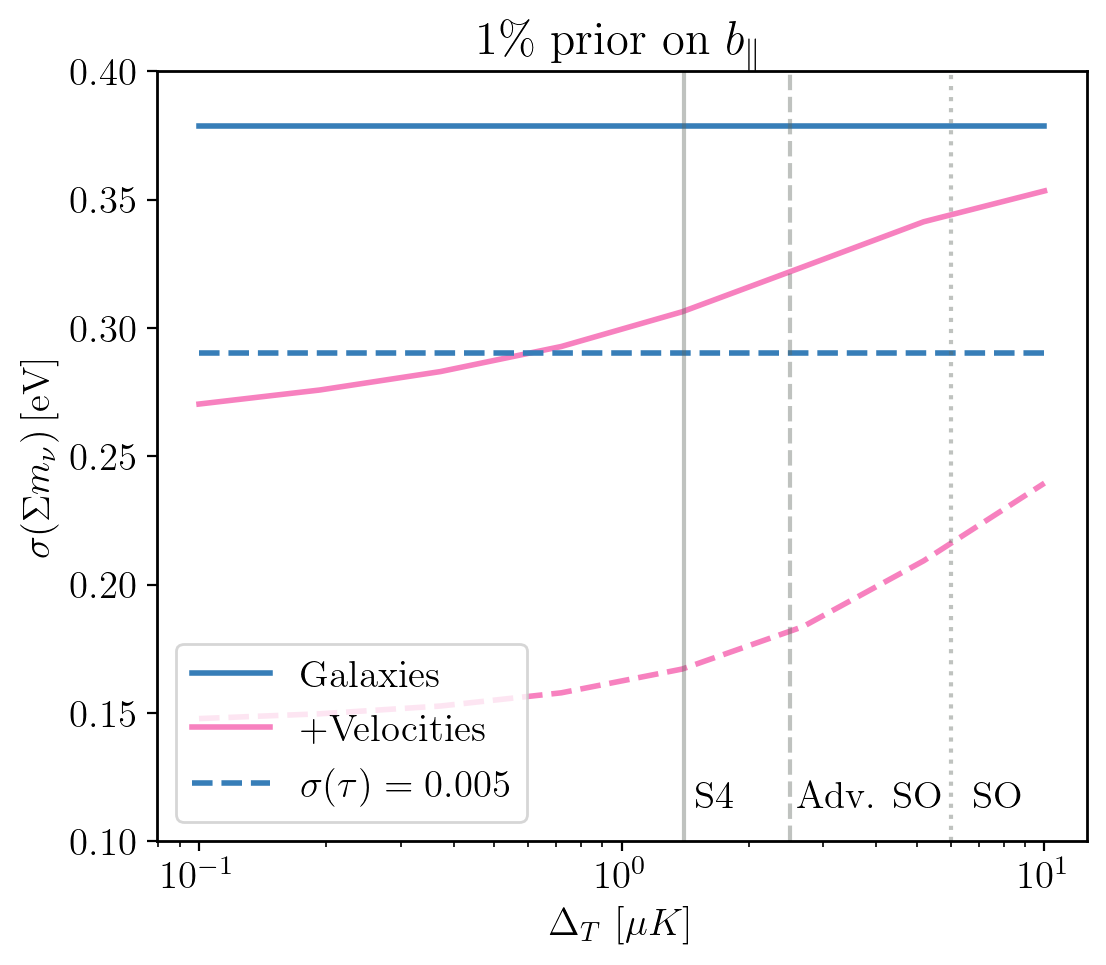

In [324]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr = np.zeros(len(Delta_Ts))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['b_par', 'b_perp']

bpar_pr = 0.01

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_XX, free_params, fixed_params+['brsd'], {})
    sig_mnu_gal_DT[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_vX, free_params, ['brsd'], {'b_par':bpar_pr})
    sig_mnu_gal_vel_DT[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_XX, free_params, fixed_params+['brsd'], {'tau':0.005})
    sig_mnu_gal_DT_pr[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_vX, free_params, ['brsd'], {'tau':0.005,'b_par':bpar_pr})
    sig_mnu_gal_vel_DT_pr[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])


plt.plot(Delta_Ts, sig_mnu_gal_DT, label='Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr, label=r'$\sigma(\tau)=0.005$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 0.11, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 0.11, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 0.11, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc=3)
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'1\% prior on $b_\parallel$')
plt.ylim(0.1,0.4)

(0.08, 0.35)

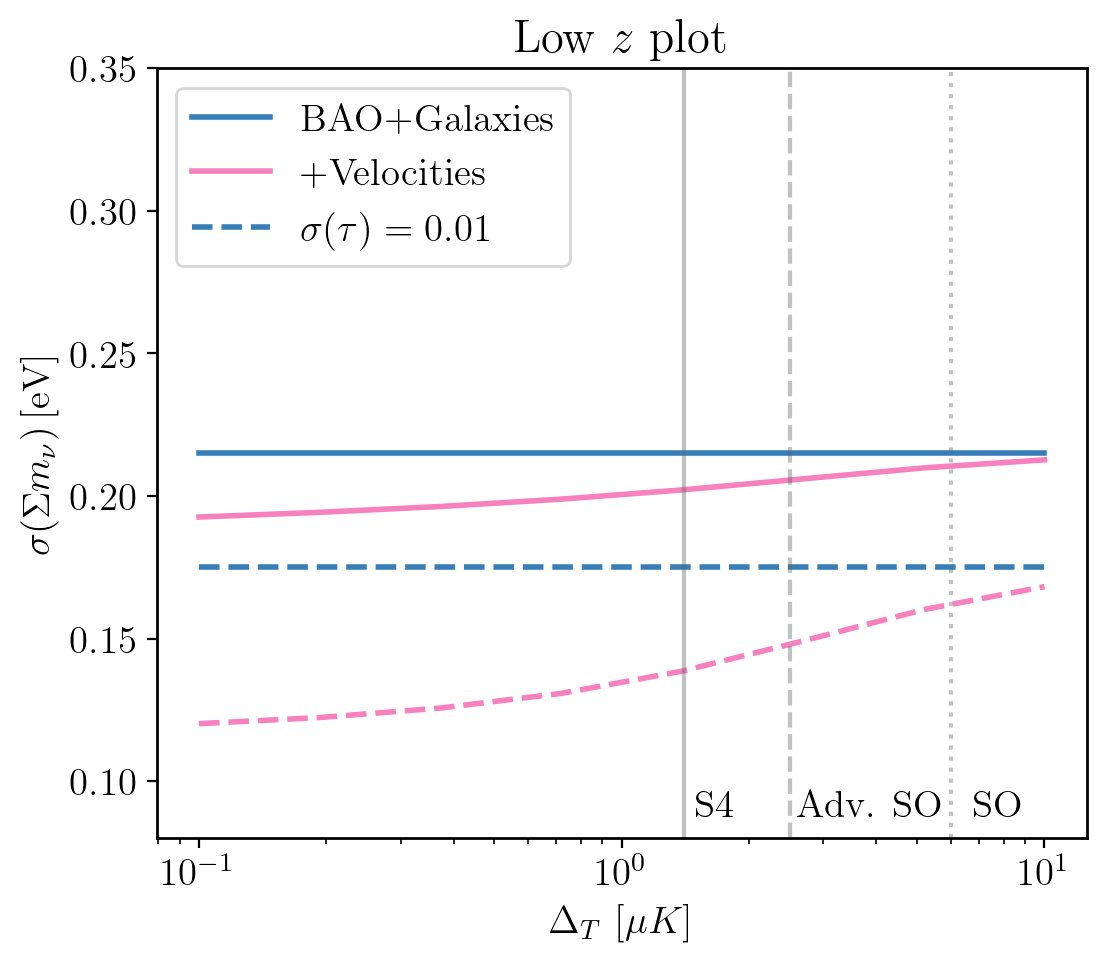

In [328]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr = np.zeros(len(Delta_Ts))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']


for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_bao_L+F_XX, free_params, fixed_params+[], {})
    sig_mnu_gal_DT[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_L+F_vX, free_params, ['brsd'], {})
    sig_mnu_gal_vel_DT[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_L+F_XX, free_params, fixed_params+[], {'tau':0.01})
    sig_mnu_gal_DT_pr[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_L+F_vX, free_params, ['brsd'], {'tau':0.01})
    sig_mnu_gal_vel_DT_pr[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])

    
plt.plot(Delta_Ts, sig_mnu_gal_DT, label='BAO+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr, label=r'$\sigma(\tau)=0.01$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 0.085, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 0.085, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 0.085, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'Low $z$ plot')
plt.ylim(0.08,0.35)

(0.01, 0.06)

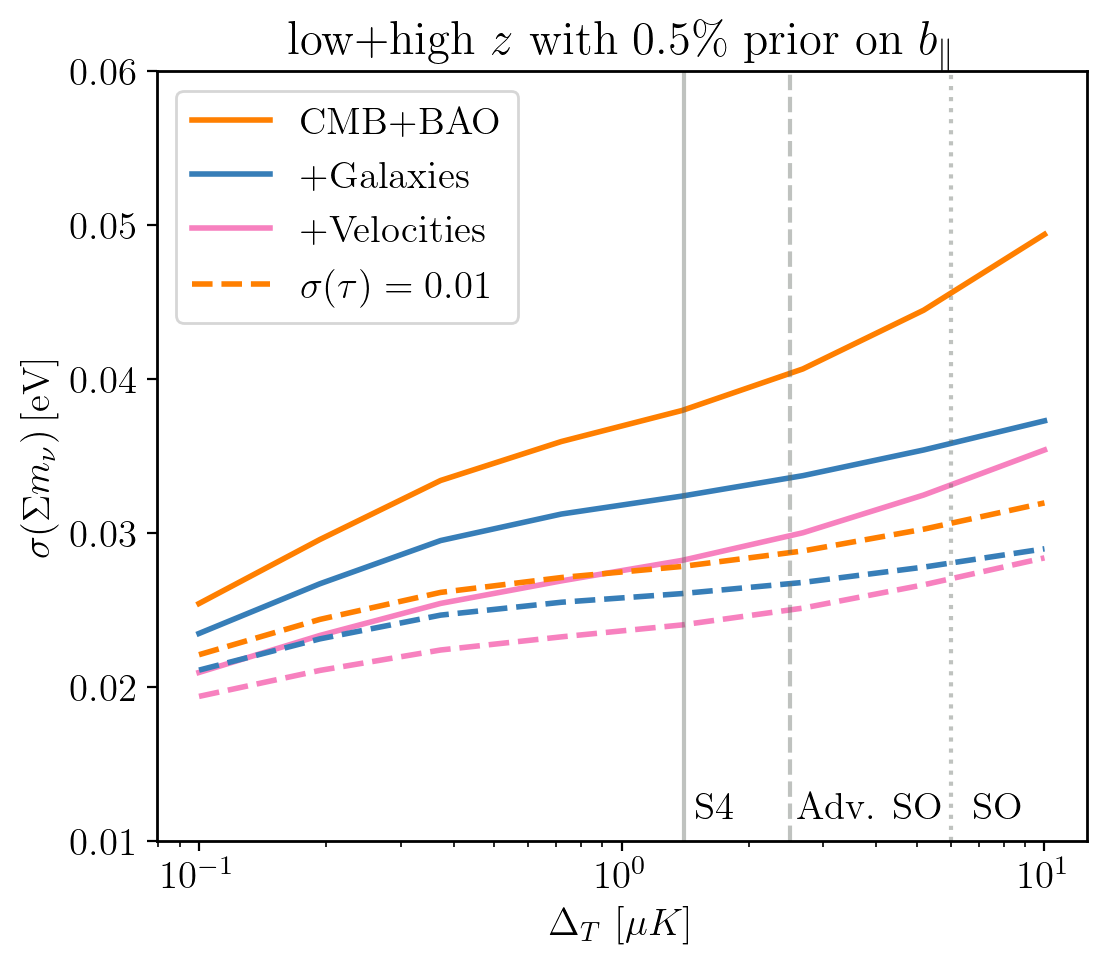

In [330]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr = np.zeros(len(Delta_Ts))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']

bpar_pr = 0.005

for t in range(len(Delta_Ts)):
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_bao_CMB_L[:7,:7] = F_S4_t
    F_bao_L = np.zeros((len(free_params), len(free_params)))
    F_bao_L[:7,:7] = F_bao
    F_planck_lowell_L = np.zeros((len(free_params), len(free_params)))
    F_planck_lowell_L[:7,:7] = F_planck_lowell
    F_bao_CMB_DT = F_bao_CMB_L + F_bao_L + F_planck_lowell_L
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {})
    sig_mnu_DT[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {'tau':0.01})
    sig_mnu_DT_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+[], {})
    sig_mnu_gal_DT[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT+F_vX, free_params, ['brsd'], {'b_par':bpar_pr})
    sig_mnu_gal_vel_DT[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+[], {'tau':0.01})
    sig_mnu_gal_DT_pr[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT+F_vX, free_params, ['brsd'], {'tau':0.01,'b_par':bpar_pr})
    sig_mnu_gal_vel_DT_pr[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_DT, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_DT, label='+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr, label=r'$\sigma(\tau)=0.01$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 0.011, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 0.011, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 0.011, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
plt.ylim(0.01,0.06)



## Vary $\theta_\mathrm{FWHM}$

In [416]:
mnu_ind = free_params.index('mnu')
sig_mnu_f = np.zeros(len(fwhms))
sig_mnu_gal_f = np.zeros(len(fwhms))
sig_mnu_gal_vel_f = np.zeros(len(fwhms))
sig_mnu_f_pr = np.zeros(len(fwhms))
sig_mnu_gal_f_pr = np.zeros(len(fwhms))
sig_mnu_gal_vel_f_pr = np.zeros(len(fwhms))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']

ARCMIN_TO_RAD = 1./60.*np.pi/180.

fsky=0.4

deltas = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 3e-1, 3e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
survey = 'VRO10'
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'm', 'q', 'brsd', 'b_par', 'b_perp', 'b2']

F_XX_t = []
F_vX_t = []

zs = np.array([0.2,0.7,1.3,1.9,2.6])
bgs = np.array([1.05,1.37,1.79,2.22,2.74])
ngs = np.array([5e-2,2e-2,6e-3,15e-4,3e-4])
vs = (np.array([5.2,43.6,75.9,89.3,119.9])*u.Gpc**3).to(u.Mpc**3)

for t in range(len(fwhms)):
    
    Fz_XX=np.zeros((len(zs),len(free_params),len(free_params)))
    Fz_vX=np.zeros((len(zs),len(free_params),len(free_params)))
    for i in range(len(zs)):
        xx,vx = Fisher_mat(zs[i], cosmo_params, bias_params, free_params, deltas, k_large, mu_L, ngs[i], survey, Delta_T_S4, fwhms[t], vs[i])
        Fz_XX[i,:,:]=xx
        Fz_vX[i,:,:]=vx
        
    F_vX_t.append(np.sum(Fz_vX, axis=0))
    F_XX_t.append(np.sum(Fz_XX, axis=0))


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:138: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 2.0 / Nc
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:166: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 3.0 / Nc ** 2.0
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/hod.py:218: RuntimeWarning: invalid value encountered in divide
  ret = Ns ** 2.0 / Nc
/Users/user1/Desktop/Codes/hmvec-ksz-dev/hmvec/fft.py:127: RuntimeWarning: invalid value encountered in divide
  uk = ukts / kts[None, None, :] / mnorm[..., None]
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_80785/2432360927.py:89: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_80785/2432360927.py:91: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_



Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_p

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of



Now simulating for (1-delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, th



Now simulating for (1+delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 



Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this i



Now simulating for (1+delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out



Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this



Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


Now simulating for (1+delta)H0, this is parameter #1



Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #13 (out of 13)
Note: redshifts have been re-sorted (earliest first)
Note: redshift



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #12 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #11 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  16  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest fi

/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_80785/3071637708.py:32: RuntimeWarning: overflow encountered in exp
  return s**2*np.exp((ell*(ell+1)*(th_FWHM**2))/(8*np.log(2)))




Now simulating for (1+delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 13)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt

(0.08, 0.35)

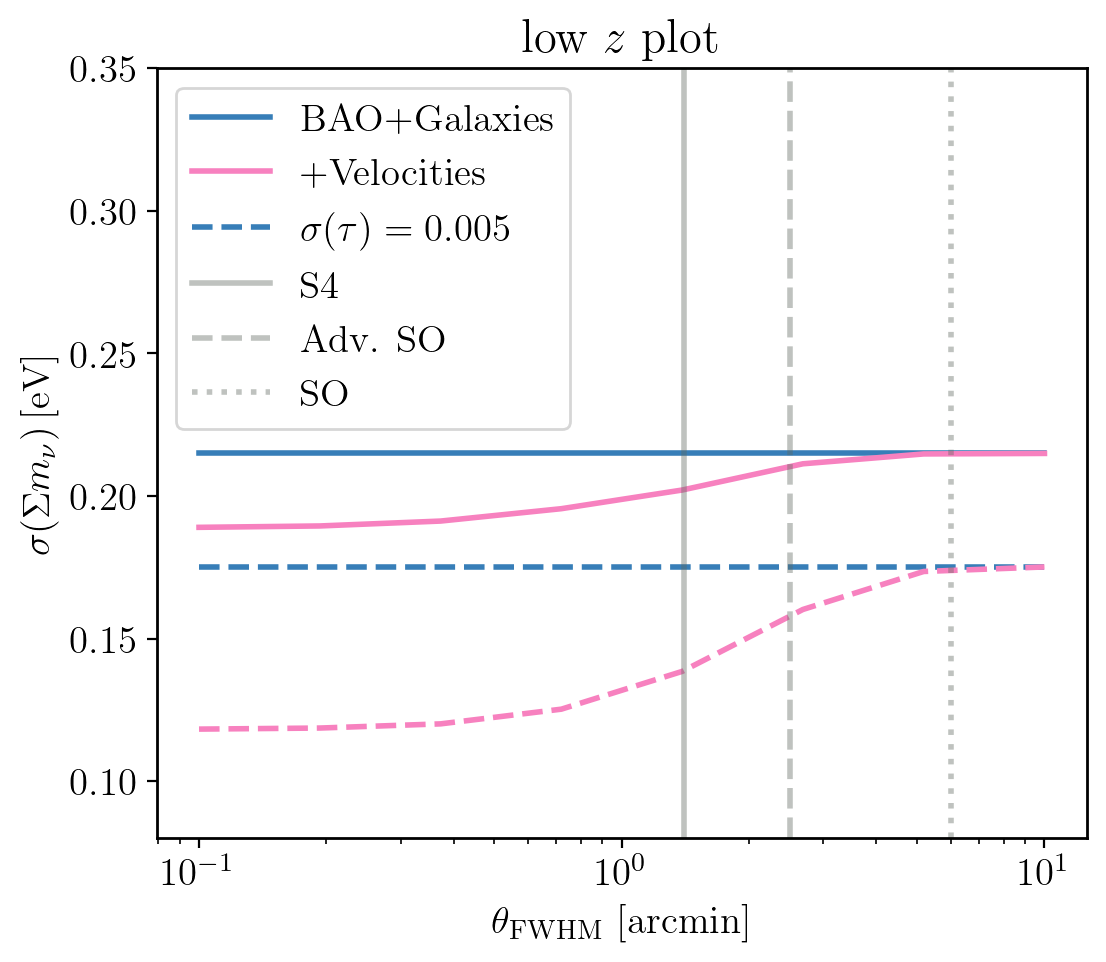

In [432]:
mnu_ind = free_params.index('mnu')
sig_mnu_f = np.zeros(len(fwhms))
sig_mnu_gal_f = np.zeros(len(fwhms))
sig_mnu_gal_vel_f = np.zeros(len(fwhms))
sig_mnu_f_pr = np.zeros(len(fwhms))
sig_mnu_gal_f_pr = np.zeros(len(fwhms))
sig_mnu_gal_vel_f_pr = np.zeros(len(fwhms))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']

bpar_pr = 1000.005

for t in range(len(fwhms)):
    F_bao_L = np.zeros((len(free_params), len(free_params)))
    F_bao_L[:7,:7] = F_bao
    
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_bao_L+F_XX, free_params, fixed_params+[], {})
    sig_mnu_gal_f[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_L+F_vX, free_params, ['brsd'], {'b_par':bpar_pr})
    sig_mnu_gal_vel_f[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_L+F_XX, free_params, fixed_params+[], {'tau':0.005})
    sig_mnu_gal_f_pr[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_L+F_vX, free_params, ['brsd'], {'tau':0.005,'b_par':bpar_pr})
    sig_mnu_gal_vel_f_pr[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_gal_f, label='BAO+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_f, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_gal_f_pr, label=r'$\sigma(\tau)=0.005$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_f_pr, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\theta_\mathrm{FWHM}$ [arcmin]')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'low $z$ plot')
plt.ylim(0.08,0.35)



(0.01, 0.06)

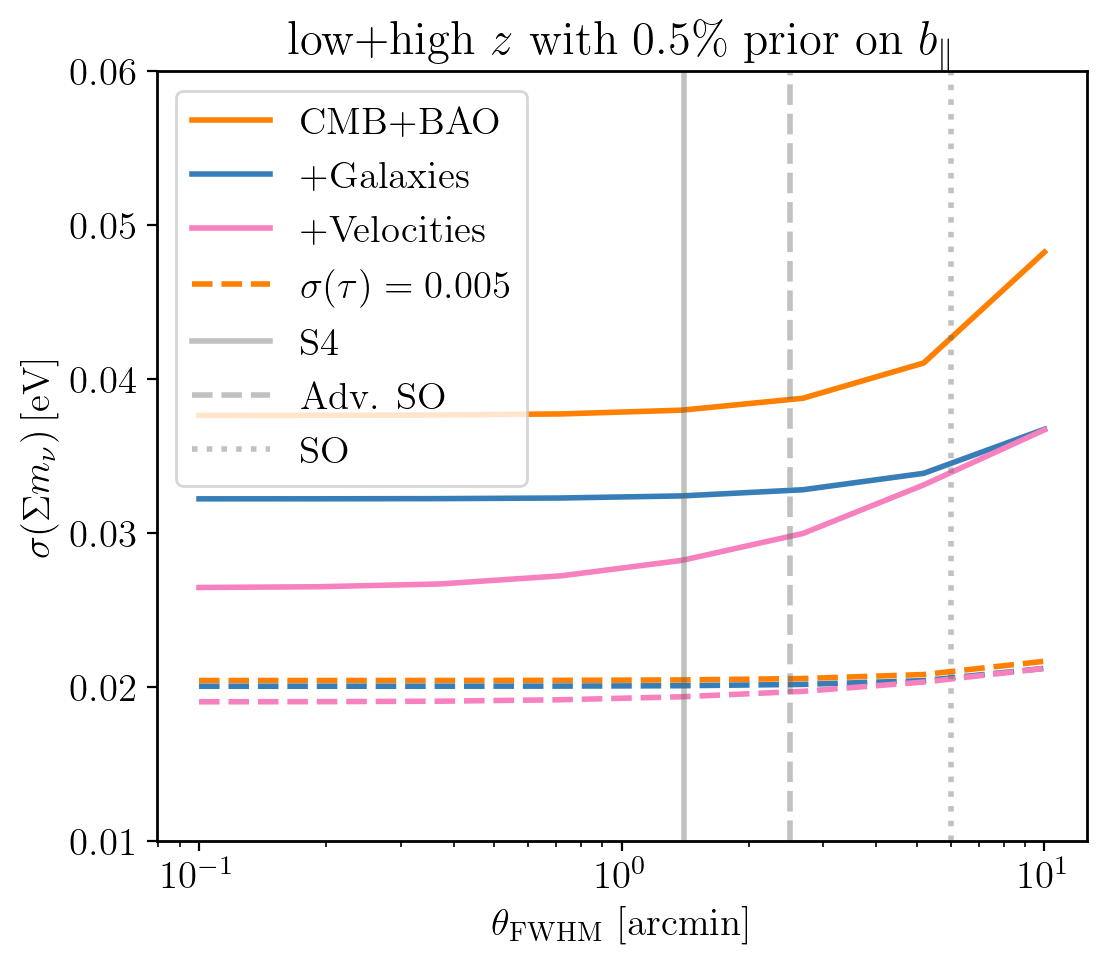

In [425]:
mnu_ind = free_params.index('mnu')
sig_mnu_f = np.zeros(len(fwhms))
sig_mnu_gal_f = np.zeros(len(fwhms))
sig_mnu_gal_vel_f = np.zeros(len(fwhms))
sig_mnu_f_pr = np.zeros(len(fwhms))
sig_mnu_gal_f_pr = np.zeros(len(fwhms))
sig_mnu_gal_vel_f_pr = np.zeros(len(fwhms))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']

bpar_pr = 0.005

for t in range(len(fwhms)):
    F_CMB_L = np.zeros((len(free_params), len(free_params)))
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_f['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_CMB_L[:7,:7] = F_S4_t
    F_bao_L = np.zeros((len(free_params), len(free_params)))
    F_bao_L[:7,:7] = F_bao
    F_planck_lowell_L = np.zeros((len(free_params), len(free_params)))
    F_planck_lowell_L[:7,:7] = F_planck_lowell
    F_bao_CMB_f = F_CMB_L + F_bao_L + F_planck_lowell_L
    cov, covp = covariance_mat(F_bao_CMB_f, free_params, bias_list, {})
    sig_mnu_f[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_f, free_params, bias_list, {'tau':0.005})
    sig_mnu_f_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_f+F_XX, free_params, fixed_params+[], {})
    sig_mnu_gal_f[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_f+F_vX, free_params, ['brsd'], {'b_par':bpar_pr})
    sig_mnu_gal_vel_f[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_f+F_XX, free_params, fixed_params+[], {'tau':0.005})
    sig_mnu_gal_f_pr[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_f+F_vX, free_params, ['brsd'], {'tau':0.005,'b_par':bpar_pr})
    sig_mnu_gal_vel_f_pr[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_f, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_f, label='+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_f, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_f_pr, label=r'$\sigma(\tau)=0.005$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_f_pr, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_f_pr, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\theta_\mathrm{FWHM}$ [arcmin]')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
plt.ylim(0.01,0.06)



(0.01, 0.06)

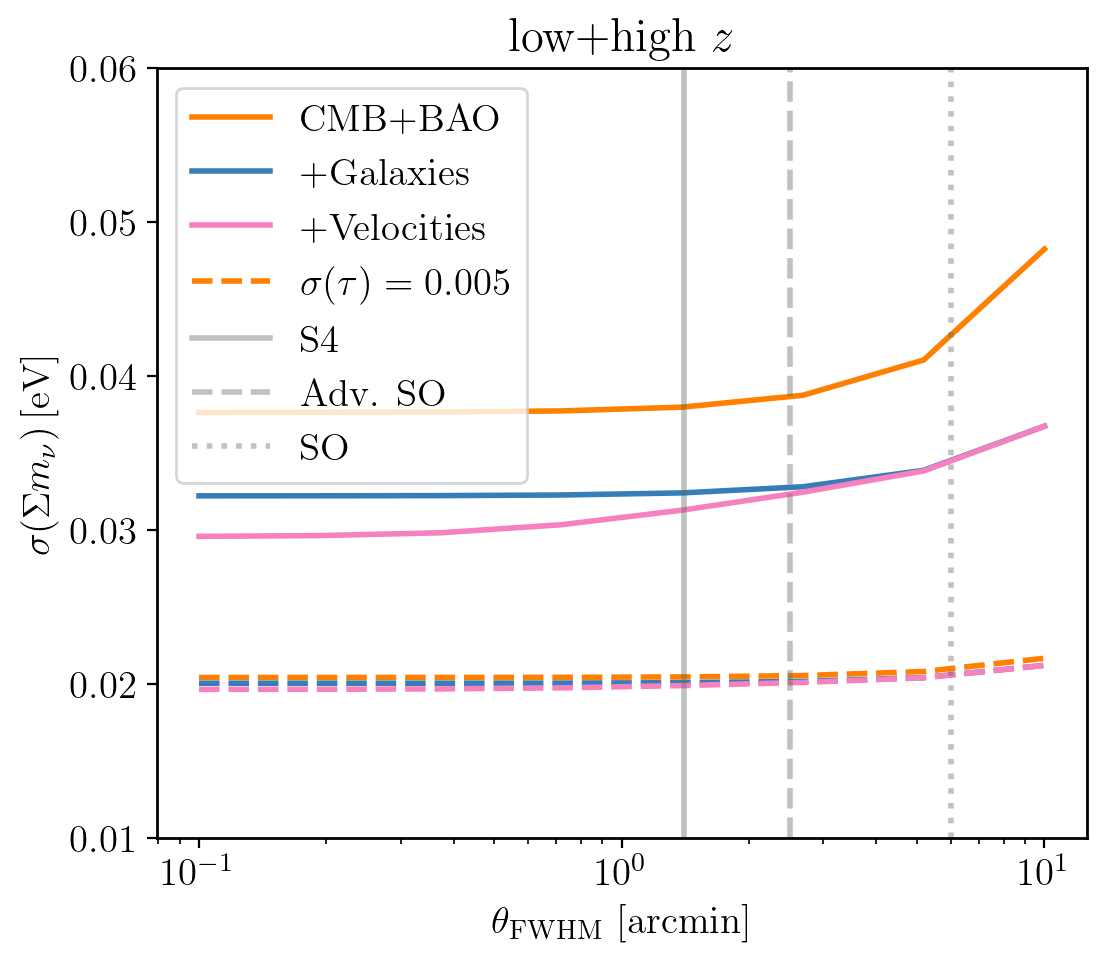

In [426]:
mnu_ind = free_params.index('mnu')
sig_mnu_f = np.zeros(len(fwhms))
sig_mnu_gal_f = np.zeros(len(fwhms))
sig_mnu_gal_vel_f = np.zeros(len(fwhms))
sig_mnu_f_pr = np.zeros(len(fwhms))
sig_mnu_gal_f_pr = np.zeros(len(fwhms))
sig_mnu_gal_vel_f_pr = np.zeros(len(fwhms))

bias_list = ['m', 'q', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']

bpar_pr = 1000.005

for t in range(len(fwhms)):
    F_CMB_L = np.zeros((len(free_params), len(free_params)))
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_f['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_CMB_L[:7,:7] = F_S4_t
    F_bao_L = np.zeros((len(free_params), len(free_params)))
    F_bao_L[:7,:7] = F_bao
    F_planck_lowell_L = np.zeros((len(free_params), len(free_params)))
    F_planck_lowell_L[:7,:7] = F_planck_lowell
    F_bao_CMB_f = F_CMB_L + F_bao_L + F_planck_lowell_L
    cov, covp = covariance_mat(F_bao_CMB_f, free_params, bias_list, {})
    sig_mnu_f[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_f, free_params, bias_list, {'tau':0.005})
    sig_mnu_f_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_f+F_XX, free_params, fixed_params+[], {})
    sig_mnu_gal_f[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_f+F_vX, free_params, ['brsd'], {'b_par':bpar_pr})
    sig_mnu_gal_vel_f[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_f+F_XX, free_params, fixed_params+[], {'tau':0.005})
    sig_mnu_gal_f_pr[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_f+F_vX, free_params, ['brsd'], {'tau':0.005,'b_par':bpar_pr})
    sig_mnu_gal_vel_f_pr[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_f, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_f, label='+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_f, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_f_pr, label=r'$\sigma(\tau)=0.005$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_f_pr, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_f_pr, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\theta_\mathrm{FWHM}$ [arcmin]')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'low+high $z$')
plt.ylim(0.01,0.06)



# Fisher for DESI

converting quantities for DESI redshift bins - taken from 2306.06307

In this analysis - need to changes the relevant "bg2" line in get_powers function!

In [19]:
h = cosmo_params['H0']/100
full_area = 14000*u.deg**2 #deg^-2
Dgrowth = interp1d(zcosmo[::-1],cosmo.get_sigma8()/cosmo.get_sigma8()[-1],kind='cubic', bounds_error=False,fill_value='extrapolate')


# bin 1 (BGS)
z1 = 0.2
bg1 = 1.34/Dgrowth(z1)
V1 = ((0.04+0.22+0.54+0.83)*u.Gpc**3/h**3).to(u.Mpc**3).value
ng1 = ((101.1+231.3+216.9+97.3)/u.deg**2*full_area/V1).value #1/Mpc^3

# bin 2 (LRG1)
z2 = 0.6
bg2 = 1.7/Dgrowth(z2)
V2 = ((1.06+1.42+1.76+2.07)*u.Gpc**3/h**3).to(u.Mpc**3).value
ng2 = ((47.5+65.6+80.0+93.2)/u.deg**2*full_area/V2).value #1/Mpc^3

# bin 3 (LRG2)
z3 = 0.95
bg3 = 1.7/Dgrowth(z3)
V3 = ((2.32+2.09+1.25)*u.Gpc**3/h**3).to(u.Mpc**3).value
ng3 = ((99.3+63.7+28.3)/u.deg**2*full_area/V3).value #1/Mpc^3

# bin 4 (ELG)
z4 = 1.35
bg4 = 0.84/Dgrowth(z4)
V4 = ((1.4+1.35+1.26+1.13+0.65)*u.Gpc**3/h**3).to(u.Mpc**3).value
ng4 = ((108.0+103.6+97.1+87.7+55.4)/u.deg**2*full_area/V4).value #1/Mpc^3

# bin 5 (Quasars)
z5 = 1.85
bg5 = 1.2/Dgrowth(z5)
V5 = ((0.17+0.16+0.14+0.13+0.10)*u.Gpc**3/h**3).to(u.Mpc**3).value
ng5 = ((12.1+11.8+11.1+10.6+9.5)/u.deg**2*full_area/V5).value #1/Mpc^3


zs_DESI = np.array([z1,z2,z3,z4,z5])
bgs_DESI = np.array([bg1,bg2,bg3,bg4,bg5])
ngs_DESI = np.array([ng1,ng2,ng3,ng4,ng5])
vs_DESI = np.array([V1,V2,V3,V4,V5])*u.Mpc**3


In [20]:
deltas = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 3e-1, 3e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]

survey = 'DESI'
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bg', 'b_par', 'b_perp', 'b2']
fixed_params=['b_par', 'b_perp']

bg_ind = free_params.index('bg')
bias_params['bg'] = bg_DESI
bias1 = bias_params.copy()

Fz_XX_DESI=np.zeros((len(zs_DESI),len(free_params),len(free_params)))
Fz_vX_DESI=np.zeros((len(zs_DESI),len(free_params),len(free_params)))
    
for i in range(len(zs_DESI)):
    bias1['bg'] = bgs_DESI[i]
    xx,vx = Fisher_mat(zs_DESI[i], cosmo_params, bias1, free_params, deltas, k_large, mu_L, ngs_DESI[i], survey, Delta_T_S4, vs_DESI[i])
    
    Fz_XX_DESI[i,:,:]=xx
    Fz_vX_DESI[i,:,:]=vx

# Just checking how it looks when I sum over the redshift bins (although it's not true because bg is different for each bin)
F_vX = np.sum(Fz_vX_DESI, axis=0)
F_XX = np.sum(Fz_XX_DESI, axis=0)


print('Galaxies:')
covmat_xx, cov_params = covariance_mat(F_XX, free_params, fixed_params, {})
print_1_sigmas(covmat_xx,cov_params)
print('\n Galaxies+kSZ:')
covmat_vx, cov_params = covariance_mat(F_vX, free_params, [], {})
print_1_sigmas(covmat_vx,cov_params)


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  15  iterations.


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_14903/672409498.py:89: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_14903/672409498.py:91: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3




Now simulating for (1+delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  17  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out o

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu)$ [eV]')

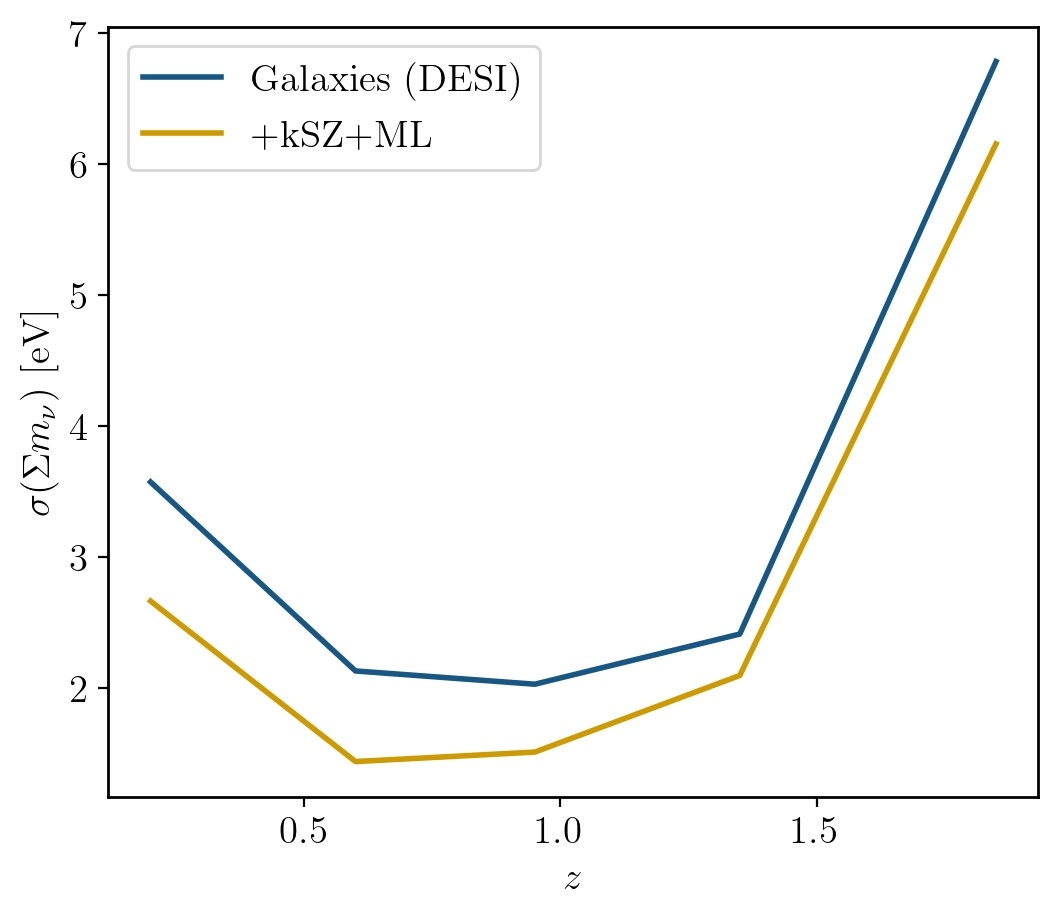

In [21]:

mnu_ind = free_params.index('mnu')
sig_mnu_DESI_bins = np.zeros(len(zs_DESI))
sig_mnu_DESI_kSZ_bins = np.zeros(len(zs_DESI))
for i in range(len(zs_DESI)):
    covmat_gal_z, cov_params = covariance_mat(Fz_XX_DESI[i], free_params, fixed_params+['b2'], {})
    sig_mnu_DESI_bins[i] = np.sqrt(covmat_gal_z[mnu_ind,mnu_ind])
    covmat_gal_kSZ_z, cov_params = covariance_mat(Fz_vX_DESI[i], free_params, [], {})
    sig_mnu_DESI_kSZ_bins[i] = np.sqrt(covmat_gal_kSZ_z[mnu_ind,mnu_ind])

plt.plot(zs_DESI, sig_mnu_DESI_bins, label='Galaxies (DESI)')
plt.plot(zs_DESI, sig_mnu_DESI_kSZ_bins, label='+kSZ+ML')
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$\sigma(\Sigma m_\nu)$ [eV]')

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu)$ [eV]')

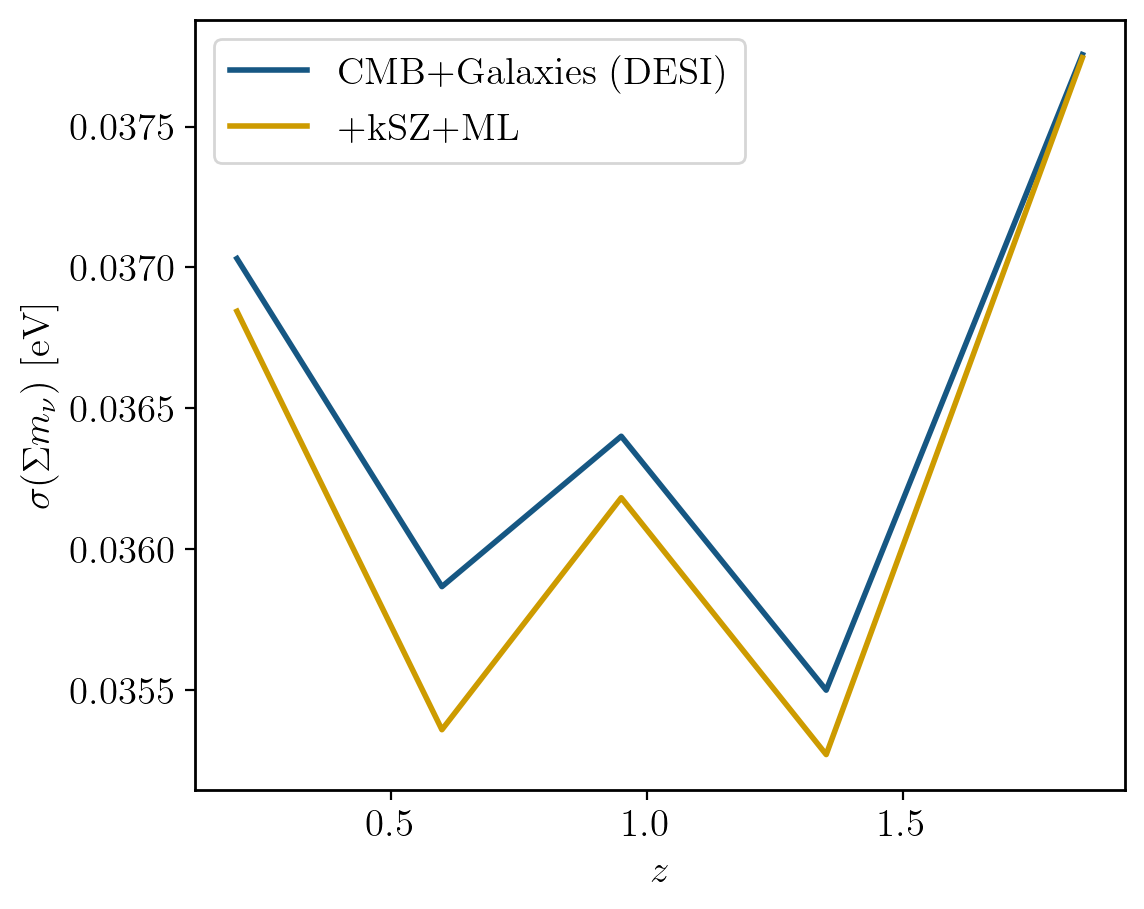

In [22]:
F_bao_CMB_S4_L = np.zeros((len(Fz_XX_DESI[0]), len(Fz_XX_DESI[0])))
F_bao_CMB_S4_L[:7,:7] = F_bao_CMB_S4

mnu_ind = free_params.index('mnu')
sig_mnu_DESI_bins = np.zeros(len(zs_DESI))
sig_mnu_DESI_kSZ_bins = np.zeros(len(zs_DESI))
for i in range(len(zs_DESI)):
    covmat_gal_z, cov_params = covariance_mat(F_bao_CMB_S4_L+Fz_XX_DESI[i], free_params, fixed_params, {})
    sig_mnu_DESI_bins[i] = np.sqrt(covmat_gal_z[mnu_ind,mnu_ind])
    covmat_gal_kSZ_z, cov_params = covariance_mat(F_bao_CMB_S4_L+Fz_vX_DESI[i], free_params, [], {})
    sig_mnu_DESI_kSZ_bins[i] = np.sqrt(covmat_gal_kSZ_z[mnu_ind,mnu_ind])

plt.plot(zs_DESI, sig_mnu_DESI_bins, label='CMB+Galaxies (DESI)')
plt.plot(zs_DESI, sig_mnu_DESI_kSZ_bins, label='+kSZ+ML')
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$\sigma(\Sigma m_\nu)$ [eV]')

In [23]:
# Now doing the process of marginalizing bg for each bin and then summing everything

bg_ind = free_params.index('bg')
Fz_XX_DESI2 = np.zeros((len(zs_DESI),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
Fz_vX_DESI2 = np.zeros((len(zs_DESI),len(free_params)-1,len(free_params)-1))

for i in range(len(zs_DESI)):
    
    cov_xx_DESI, cov_params2 = covariance_mat(Fz_XX_DESI[i], free_params, fixed_params, {})
    cov_xx_DESI = np.delete(cov_xx_DESI, bg_ind, axis=0)
    cov_xx_DESI = np.delete(cov_xx_DESI, bg_ind, axis=1)
    Fz_XX_DESI2[i,:,:] = np.linalg.inv(cov_xx_DESI)
    
    cov_vx_DESI, cov_params = covariance_mat(Fz_vX_DESI[i], free_params, [], {})
    #cov_vx_DESI, cov_params = covariance_mat(Fz_vX_DESI[i], free_params, [], {'b_par':100000}) #this line prevents the nans
    cov_vx_DESI = np.delete(cov_vx_DESI, bg_ind, axis=0)
    cov_vx_DESI = np.delete(cov_vx_DESI, bg_ind, axis=1)
    Fz_vX_DESI2[i,:,:] = np.linalg.inv(cov_vx_DESI)


F_vX_DESI = np.sum(Fz_vX_DESI2, axis=0)
F_XX_DESI = np.sum(Fz_XX_DESI2, axis=0)

cov_params3 = cov_params2.copy()
cov_params3.remove('bg')

free_params3 = cov_params.copy()
free_params3.remove('bg')

print('Galaxies:')
covmat_xx, cov_params = covariance_mat(F_XX_DESI, cov_params3, [], {})
print_1_sigmas(covmat_xx,cov_params)
print('\n Galaxies+kSZ:')
covmat_vx, cov_params = covariance_mat(F_vX_DESI, free_params3, [], {})
print_1_sigmas(covmat_vx,cov_params)

Galaxies:


1-sigma of H0 is 4.374317167384551
1-sigma of ombh2 is 0.0004404918531204798
1-sigma of omch2 is 0.0020908495323708524
1-sigma of ns is 0.02478123095972379
1-sigma of As is 9.499141204038277e-10
1-sigma of tau is 379.5469650611125
1-sigma of mnu is 0.6812321655616563
1-sigma of b2 is 6.5408730240963715

 Galaxies+kSZ:


1-sigma of H0 is 2.2798747639503727
1-sigma of ombh2 is 0.0004164528715734846
1-sigma of omch2 is 0.0019845945042378196
1-sigma of ns is 0.015850438995851035
1-sigma of As is 1.908398414544462e-10
1-sigma of tau is 123.44880054724457
1-sigma of mnu is 0.5698953212828655
1-sigma of b_par is 0.024196066202423008
1-sigma of b_perp is 0.0844839647441318
1-sigma of b2 is 2.2808628901930765


### Vary $\Delta_T$ for DESI

In [102]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr_DESI = np.zeros(len(Delta_Ts))

bias_list = ['bg', 'b_par', 'b_perp', 'b2']

#bias_params['bg'] = bg_DESI
bias1 = bias_params.copy()

fsky=0.4

deltas = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 3e-1, 3e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
survey = 'DESI'
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bg', 'b_par', 'b_perp', 'b2']
fixed_params=['b_par', 'b_perp']

F_XX_t_DESI = []
F_vX_t_DESI = []


for t in range(len(Delta_Ts)):
    
    Fz_XX_DESI = np.zeros((len(zs_DESI),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
    Fz_vX_DESI = np.zeros((len(zs_DESI),len(free_params)-1,len(free_params)-1))
    for i in range(len(zs_DESI)):
        bias1['bg'] = bgs_DESI[i]
        xx,vx = Fisher_mat(zs_DESI[i], cosmo_params, bias1, free_params, deltas, k_large, mu_L, ngs_DESI[i], survey, Delta_Ts[t], vs_DESI[i])
        
        cov_xx_DESI, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
        cov_xx_DESI = np.delete(cov_xx_DESI, bg_ind, axis=0)
        cov_xx_DESI = np.delete(cov_xx_DESI, bg_ind, axis=1)
        Fz_XX_DESI[i,:,:] = np.linalg.inv(cov_xx_DESI)

        cov_vx_DESI, cov_params = covariance_mat(vx, free_params, [], {})
        cov_vx_DESI = np.delete(cov_vx_DESI, bg_ind, axis=0)
        cov_vx_DESI = np.delete(cov_vx_DESI, bg_ind, axis=1)
        Fz_vX_DESI[i,:,:] = np.linalg.inv(cov_vx_DESI)

    F_vX_t_DESI.append(np.sum(Fz_vX_DESI, axis=0))
    F_XX_t_DESI.append(np.sum(Fz_XX_DESI, axis=0))
    

cov_params3 = cov_params2.copy()
cov_params3.remove('bg')

free_params3 = free_params.copy()
free_params3.remove('bg')


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  15  iterations.


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/1162831189.py:89: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/1162831189.py:91: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3




Now simulating for (1+delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  17  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out o



Now simulating for (1+delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  18  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out



Now simulating for (1-delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted 



Now simulating for (1+delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (



Now simulating for (1-delta)As, this is parameter #5 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_p



Now simulating for (1+delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bg, th



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)

Bisection search converged in  17  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 11)
Note: redshifts have been re-sorte



Now simulating for (1+delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  18  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 



Now simulating for (1-delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  16  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out



Now simulating for (1+delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #11 (out of 11)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have b



Now simulating for (1-delta)tau, this is parameter #6 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b_par, this is parameter #9 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_perp, this is parameter #10 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-de



Now simulating for (1+delta)As, this is parameter #5 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bg, this is parameter #8 (out of 11)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b_par,

(0.1, 0.7)

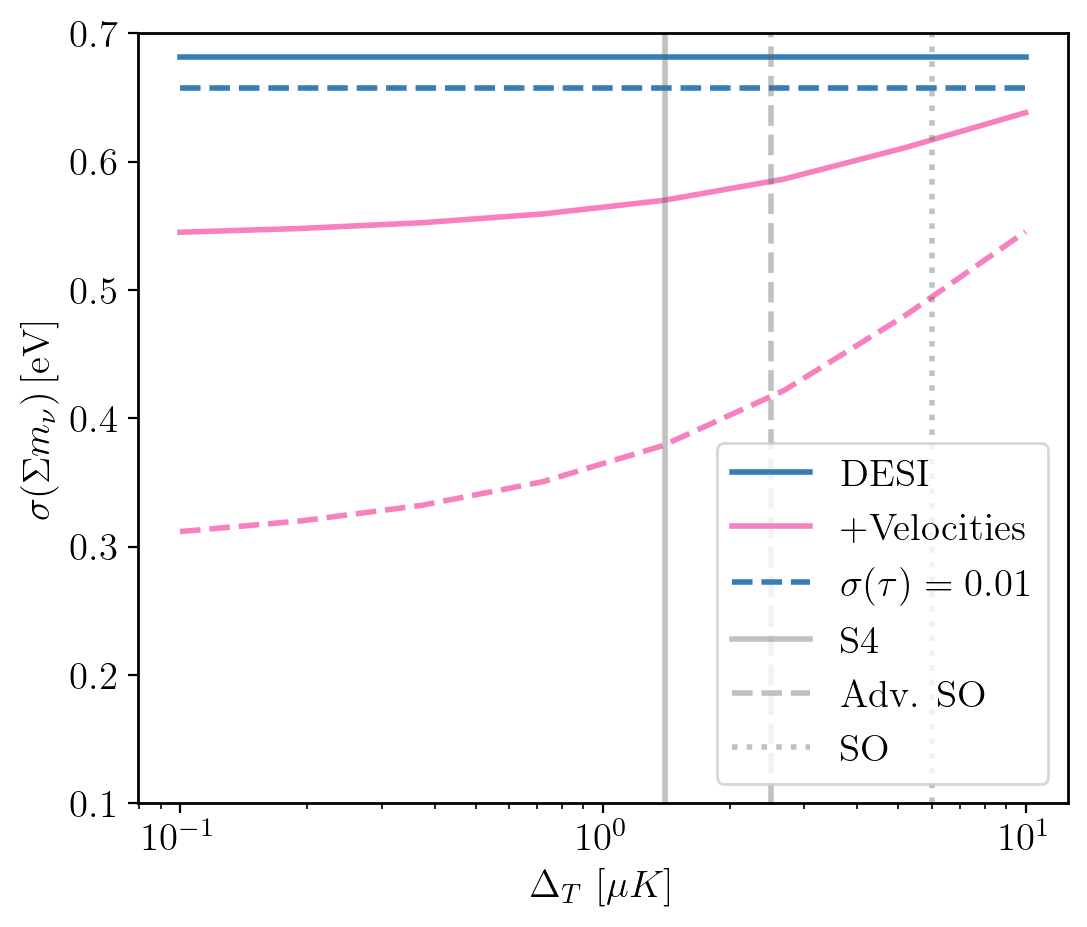

In [112]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr_DESI = np.zeros(len(Delta_Ts))

bias_list = ['bg', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']

bpar_pr = 1000.005

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_t_DESI[t]
    F_XX = F_XX_t_DESI[t]
    
    covmat_gal, cov_params = covariance_mat(F_XX, cov_params3, fixed_params+[], {})
    sig_mnu_gal_DT_DESI[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_vX, free_params3, [], {})
    sig_mnu_gal_vel_DT_DESI[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_XX, cov_params3, fixed_params+[], {'tau':0.01})
    sig_mnu_gal_DT_pr_DESI[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_vX, free_params3, [], {'tau':0.01})
    sig_mnu_gal_vel_DT_pr_DESI[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_gal_DT_DESI, label='DESI', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_DESI, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr_DESI, label=r'$\sigma(\tau)=0.01$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr_DESI, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
#plt.title(r'low+high $z$')
plt.ylim(0.1,0.7)



(0.1, 0.4)

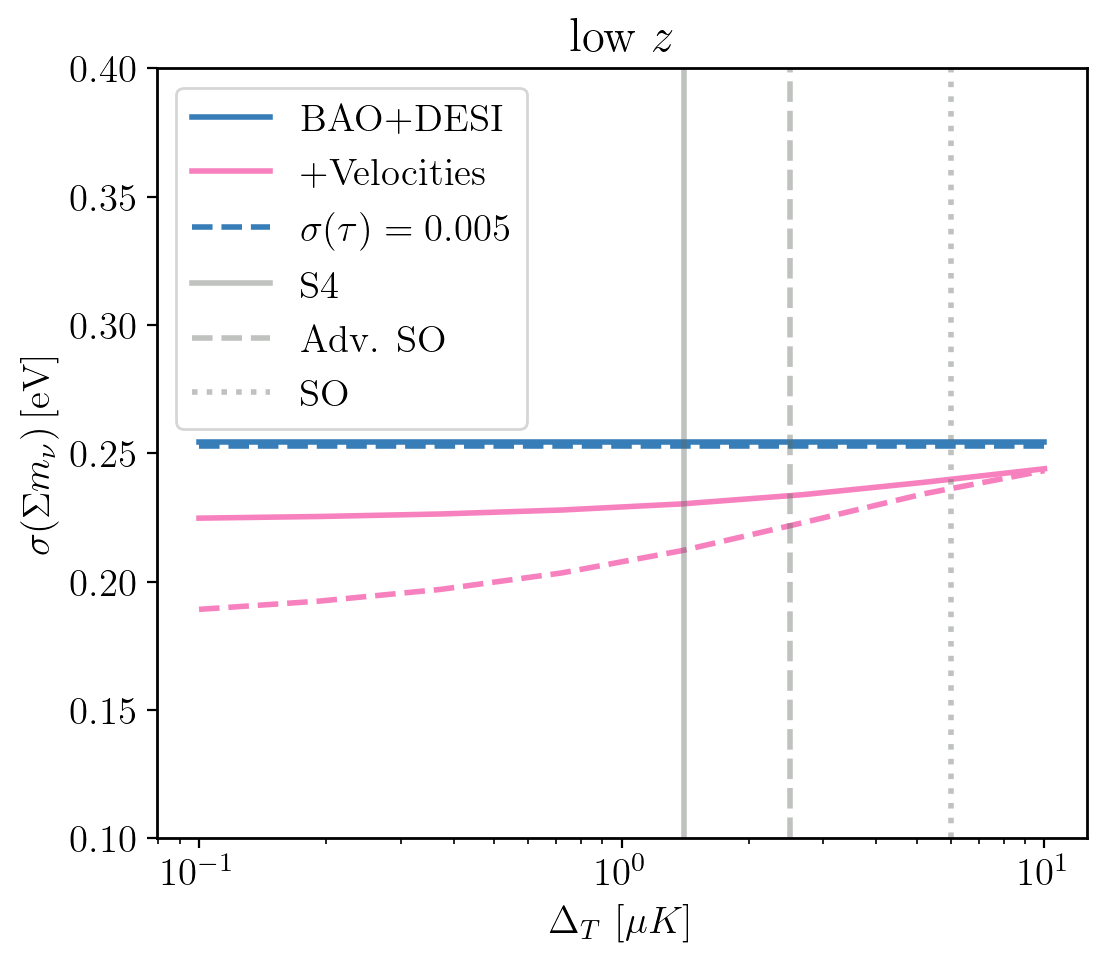

In [116]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr_DESI = np.zeros(len(Delta_Ts))

bias_list = ['bg', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']

bpar_pr = 1000.005

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_t_DESI[t]
    F_XX = F_XX_t_DESI[t]
    
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L2[:7,:7] = F_bao
    
    covmat_gal, cov_params = covariance_mat(F_bao_L1+F_XX, cov_params3, fixed_params+[], {})
    sig_mnu_gal_DT_DESI[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_L2+F_vX, free_params3, [], {})
    sig_mnu_gal_vel_DT_DESI[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_L1+F_XX, cov_params3, fixed_params+[], {'tau':0.01})
    sig_mnu_gal_DT_pr_DESI[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_L2+F_vX, free_params3, [], {'tau':0.01})
    sig_mnu_gal_vel_DT_pr_DESI[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_gal_DT_DESI, label='BAO+DESI', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_DESI, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr_DESI, label=r'$\sigma(\tau)=0.005$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr_DESI, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'low $z$')
plt.ylim(0.1,0.4)



(0.01, 0.06)

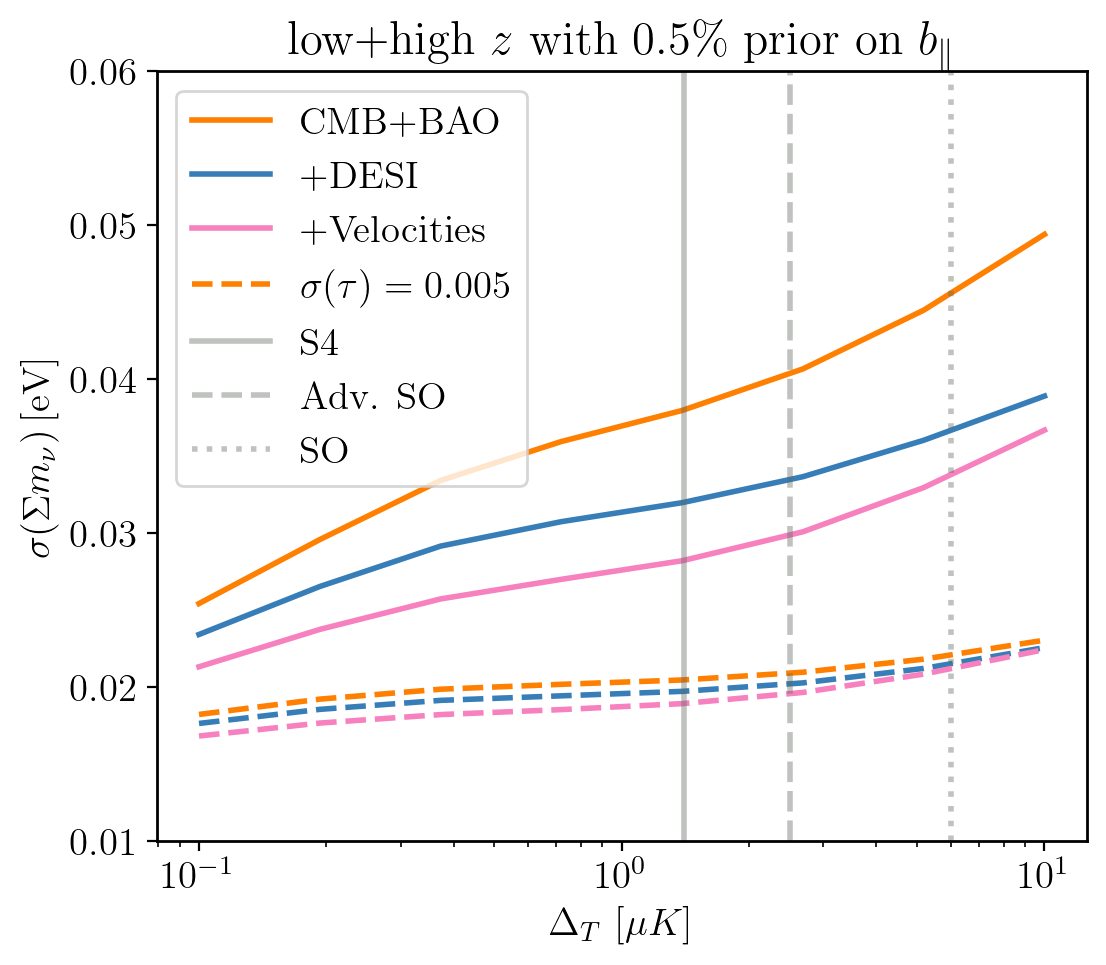

In [114]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr_DESI = np.zeros(len(Delta_Ts))

bias_list = ['bg', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']

bpar_pr = 0.005

for t in range(len(Delta_Ts)):
    F_vX = F_vX_t_DESI[t]
    F_XX = F_XX_t_DESI[t]
    
    F_CMB_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_CMB_L2 = np.zeros((len(F_vX), len(F_vX)))
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_CMB_L1[:7,:7] = F_S4_t
    F_CMB_L2[:7,:7] = F_S4_t
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2[:7,:7] = F_bao
    F_planck_lowell_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_planck_lowell_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_planck_lowell_L1[:7,:7] = F_planck_lowell
    F_planck_lowell_L2[:7,:7] = F_planck_lowell
    F_bao_CMB_DT1 = F_CMB_L1 + F_bao_L1 + F_planck_lowell_L1
    F_bao_CMB_DT2 = F_CMB_L2 + F_bao_L2 + F_planck_lowell_L2
    cov, covp = covariance_mat(F_bao_CMB_DT2, free_params3, bias_list, {})
    sig_mnu_DT_DESI[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT2, free_params3, bias_list, {'tau':0.005})
    sig_mnu_DT_pr_DESI[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params3, fixed_params+[], {})
    sig_mnu_gal_DT_DESI[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, free_params3, [], {'b_par':bpar_pr})
    sig_mnu_gal_vel_DT_DESI[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params3, fixed_params+[], {'tau':0.005})
    sig_mnu_gal_DT_pr_DESI[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, free_params3, [], {'tau':0.005,'b_par':bpar_pr})
    sig_mnu_gal_vel_DT_pr_DESI[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
                
        
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_DT_DESI, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_DT_DESI, label='+DESI', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_DESI, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr_DESI, label=r'$\sigma(\tau)=0.005$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr_DESI, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr_DESI, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
plt.ylim(0.01,0.06)



(0.01, 0.06)

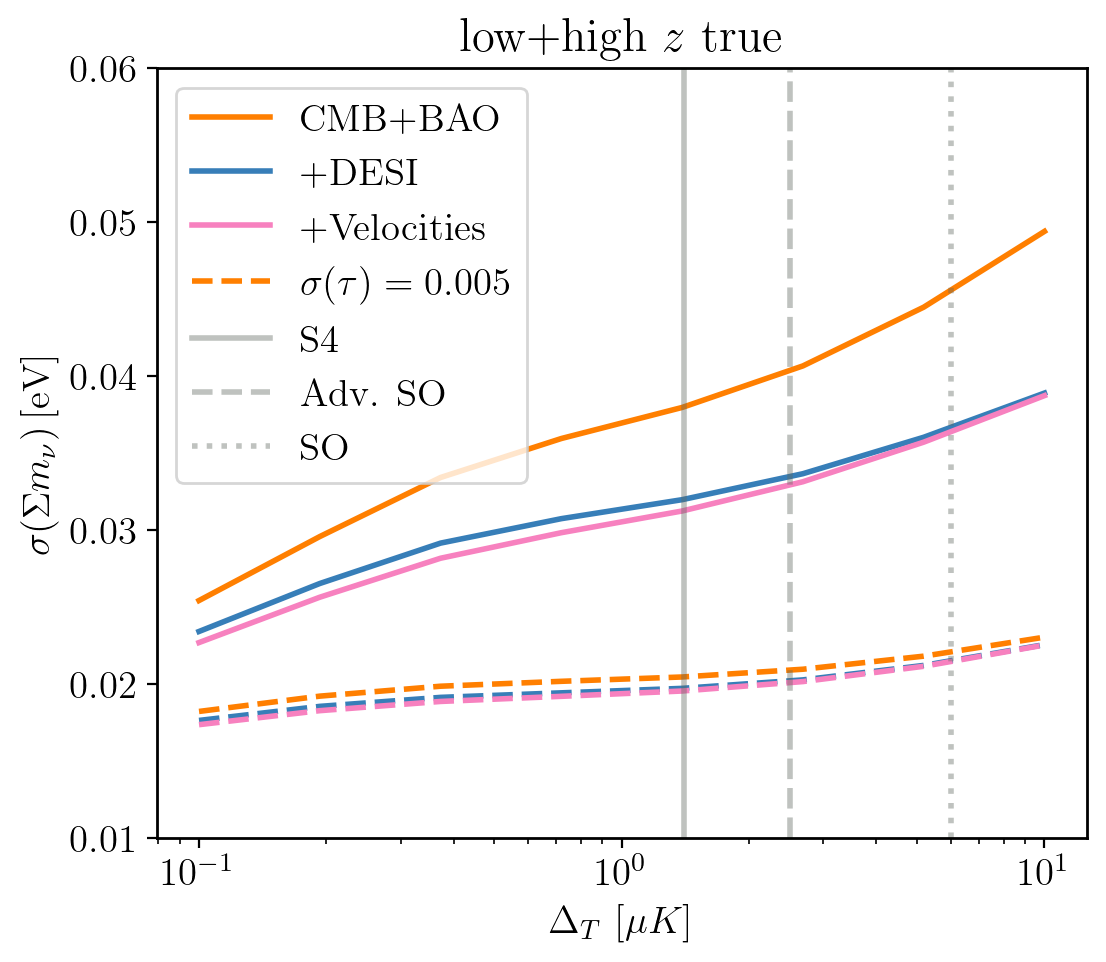

In [115]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_DESI = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr_DESI = np.zeros(len(Delta_Ts))
sig_mnu_gal_vel_DT_pr_DESI = np.zeros(len(Delta_Ts))

bias_list = ['bg', 'brsd', 'b_par', 'b_perp', 'b2']
fixed_params = ['brsd', 'b_par', 'b_perp']

bpar_pr = 1000.005

for t in range(len(Delta_Ts)):
    F_vX = F_vX_t_DESI[t]
    F_XX = F_XX_t_DESI[t]
    
    F_CMB_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_CMB_L2 = np.zeros((len(F_vX), len(F_vX)))
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_CMB_L1[:7,:7] = F_S4_t
    F_CMB_L2[:7,:7] = F_S4_t
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2[:7,:7] = F_bao
    F_planck_lowell_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_planck_lowell_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_planck_lowell_L1[:7,:7] = F_planck_lowell
    F_planck_lowell_L2[:7,:7] = F_planck_lowell
    F_bao_CMB_DT1 = F_CMB_L1 + F_bao_L1 + F_planck_lowell_L1
    F_bao_CMB_DT2 = F_CMB_L2 + F_bao_L2 + F_planck_lowell_L2
    cov, covp = covariance_mat(F_bao_CMB_DT2, free_params3, bias_list, {})
    sig_mnu_DT_DESI[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT2, free_params3, bias_list, {'tau':0.005})
    sig_mnu_DT_pr_DESI[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params3, fixed_params+[], {})
    sig_mnu_gal_DT_DESI[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, free_params3, [], {})
    sig_mnu_gal_vel_DT_DESI[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params3, fixed_params+[], {'tau':0.005})
    sig_mnu_gal_DT_pr_DESI[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, free_params3, [], {'tau':0.005})
    sig_mnu_gal_vel_DT_pr_DESI[t] = np.sqrt(covmat_gal_vel[mnu_ind,mnu_ind])
                
        
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_DT_DESI, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_DT_DESI, label='+DESI', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_DESI, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr_DESI, label=r'$\sigma(\tau)=0.005$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr_DESI, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_vel_DT_pr_DESI, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'low+high $z$ true')
plt.ylim(0.01,0.06)



## Seperate kSZ and ML

In [ ]:
#%% Calculate the reconstructed noise N_vv
def Rec_noise2(Z, cosmo_params, k_large, mu_L, bg, ng, survey, Delta_T):
    if survey == 'VRO10':
        sigma_phot = lambda z: 0.03*(1+z)
    elif survey == 'DESI':
        sigma_phot = lambda z: 0*(1+z)
    else:
        raise KeyError(f"{survey} is not a valid galaxy survey for this code!")
    nkS = 300
    nz = 101
    nmu = len(mu_L)
    k_small = np.linspace(1,5,nkS) # Mpc^-1
    mu_S = -(k_large[np.newaxis,:,np.newaxis]*np.ones((nkS,nkL,nmu))/k_small[:,np.newaxis,np.newaxis]*np.ones((nkS,nkL,nmu))) * mu_L[np.newaxis,np.newaxis,:]*np.ones((nkS,nkL,nmu))
    Mh = np.logspace(8,15,200) # Msun
    zcosmo = np.linspace(0.,15.,nz)
    cosmo_1 = cosmo_params.copy()
    cosmo_1.pop('f_NL')
    camb_pars = camb.set_params(**cosmo_1)
    camb_pars.set_matter_power(redshifts=list(zcosmo))
    cosmo = camb.get_results(camb_pars)
    H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value # 1/Mpc    
    a = lambda z: 1/(1+z)
    T_CMB = ((camb_pars.TCMB* u.K).to(u.uK)).value # muK
    chi_star = lambda z: cosmo.comoving_radial_distance(z) # Mpc
    ell = lambda z,kS: chi_star(z) * kS
    gal_profile = hod.Leauthaud12_HOD
    elec_profile = 'electron'
    b1=None # linear biases, we add from the outside 
    b2=None # linear biases, we add from the outside 
    m_integrand=False # if False, the output is Pk integrated in Mh, otherwise you get the integrand in dMh
    rsd=False # RSD, we add from the outside
    fog=False # FoG, we add from the outside
    hcos_ksmall = hm.HaloModel([Z],k_small,Mh,params=cosmo_params)
    hcos_ksmall.add_hod("g",family=gal_profile,ngal=ng+np.asarray([Z])*0.,corr="max")
    hcos_ksmall.add_battaglia_profile("electron",family="AGN",xmax=20,nxs=5000)
    pgg_1h_ksmall = hcos_ksmall.get_power_1halo(name='g', name2=None, m_integrand=m_integrand,fog=fog)[0] # Mpc^3
    pgg_2h_ksmall = hcos_ksmall.get_power_2halo(name='g',name2=None,b1_in=b1,b2_in=b2,m_integrand=m_integrand,rsd=rsd,fog=fog)[0] # Mpc^3
    pge_1h_ksmall = hcos_ksmall.get_power_1halo(name='g', name2 = elec_profile, m_integrand=m_integrand,fog=fog)[0] # Mpc^3
    pge_2h_ksmall = hcos_ksmall.get_power_2halo(name='g',name2=elec_profile,b1_in=b1,b2_in=b2,m_integrand=m_integrand,rsd=rsd,fog=fog)[0] # Mpc^3
    fgrowth = hcos_ksmall.get_fgrowth(fog=False, vectorize_mu=True)[0]
    resize_ksmall = k_small[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pgg = (pgg_1h_ksmall+pgg_2h_ksmall)[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_ell_ksmall = chi_star(Z) * k_small[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pge = (pge_1h_ksmall+pge_2h_ksmall)[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    P_gg_ksmall = (1 + mu_S**2*fgrowth/bg)**2 * (resize_pgg) # Mpc^3
    W_phot_ksmall = np.exp(-mu_S**2*resize_ksmall**2*sigma_phot(Z)**2/2/H(Z)**2)
    P_gg_obs_ksmall = W_phot_ksmall**2 * P_gg_ksmall + 1/ng # Mpc^3
    P_ge_ksmall = W_phot_ksmall*(1 + mu_S**2*fgrowth/bg) * (resize_pge) 
#     TT_total_for_S4 = np.loadtxt('./CMB+kSZ_Cls/tt_total_power_s4_new_12.txt') # From Selim
#     lvec = TT_total_for_S4[:,0]
#     Cl_TT = interp1d(lvec,TT_total_for_S4[:,1],bounds_error=False,fill_value=0.) # muK^2
#     Cltot_noise = Cl_TT(resize_ell_ksmall)
    s = Delta_T *u.arcmin.to(u.radian)
    fwhm = 1.4 *u.arcmin.to(u.radian)
    N_ell=CMB_noise(resize_ell_ksmall, s, fwhm)
    Cltot_noise=Cl_tot(resize_ell_ksmall)+N_ell
    
    xe = 1 # ionization fraction
    gasfrac = 0.9 # fraction of baryons in gas form, use default
    Yp = camb_pars.YHe # primordial He abundance
    ne0 = ksz.ne0_shaw(ombh2=cosmo_params['ombh2'],gasfrac=gasfrac,Yp=Yp) # m^-3 # mean free electron density at z = 0
    Kstar = lambda z: -ksz.ksz_radial_function(z, camb_pars.ombh2, Yp) # muK / Mpc
    itgrnd = resize_ksmall * (P_ge_ksmall**2 / P_gg_obs_ksmall) / Cltot_noise # Mpc^-1 muK^-2
    mask = np.isinf(itgrnd)
    itgrnd[mask] = 0.
    integral = np.trapz(itgrnd, x=k_small, axis=0) # Mpc / muK^2
    Nvv_par = (chi_star(Z)/ Kstar(Z))**2 * 2*np.pi / integral # Mpc^3
    N_vv_kSZ = (mu_L[np.newaxis,:]*np.ones((nkL,nmu)))**-2 * Nvv_par

    T_CMB=2.7260 #K
    T_CMB_uK=T_CMB*1e6 #uK
    # get potential Pk (non linearities included) - CAMB results is already multiplied by k^4
    interp_Pphiphi = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=zcosmo[-1], nz_step=150, zs=None, kmax=max(k_small), nonlinear=True,var1=camb.model.Transfer_Weyl, var2=camb.model.Transfer_Weyl, hubble_units=False, 
                                                        k_hunit=False, return_z_k=False, k_per_logint=None, log_interp=False,  extrap_kmax=True).P  # Mpc^3
    omegam = (camb_pars.ombh2 + camb_pars.omch2 + camb_pars.omnuh2) / (camb_pars.H0 / 100) ** 2
    rhoM0 = 3*omegam*H(0.)**2 # Mpc^-2
    # potential Pk , change of units
    use_Pphiphi_ksmall = (interp_Pphiphi(use_z,k_small)/k_small**4)[:,np.newaxis,np.newaxis]*np.ones((nkS,nkL,nmu)) # Mpc^3
    noise_pot = ((1+use_z)*rhoM0/2)**2/((resize_ksmall)**4 * bg**2*ng * W_phot_ksmall**2)  # Mpc^3
    # observed potential
    use_Ppot_ob = use_Pphiphi_ksmall + noise_pot # Mpc^3
    itgrnd_ML = (resize_ksmall)**3 * (use_Pphiphi_ksmall**2 / use_Ppot_ob) / Cltot_noise # muK^-2
    mask = np.isinf(itgrnd_ML)
    itgrnd_ML[mask] = 0
    integral_ML = np.trapz(itgrnd_ML, x=k_small, axis=0) # 1 / Mpc / muK^2
    new_resize_muL = mu_L[np.newaxis,:]*np.ones((nkL,nmu))
    new_resize_kL = k_large[:,np.newaxis]*np.ones((nkL,nmu))
    # noise on the transverse velocity potential (T_CMB factor to cancel the uK units from Cls)
    N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
    Nvv_perp = (new_resize_kL)**2 * N_perp_Vpot # v = grad pot so in Fourier you get v = k*pot
    N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3

    return N_vv_kSZ, N_vv_ML
    
    

#%% Calculate power spectra
def get_powers2(Z, cosmo_params, bias_params, k_large, mu):
    nmu = len(mu)
    nkL = len(k_large)
    nz = 101
    zcosmo = np.linspace(0.,15.,nz)
    cosmo_1 = cosmo_params.copy()
    cosmo_1.pop('f_NL')
    camb_pars = camb.set_params(**cosmo_1)
    camb_pars.set_matter_power(redshifts=list(zcosmo))
    cosmo = camb.get_results(camb_pars)
    H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value # 1/Mpc
    fgrowth = interp1d(zcosmo[::-1],cosmo.get_fsigma8()/cosmo.get_sigma8(),kind='cubic', bounds_error=False,fill_value='extrapolate')(Z)
    # get linear matter Pk
    interp_Pmm_linear = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=zcosmo[-1], nz_step=150,zs=None, kmax=max(k_large), nonlinear=False,var1=camb.model.Transfer_nonu, var2=camb.model.Transfer_nonu, hubble_units=False, 
    k_hunit=False, return_z_k=False, k_per_logint=None, log_interp=False,  extrap_kmax=False).P # Mpc^3

    resize_klarge = k_large[:,np.newaxis]*np.ones((nkL,nmu))
    resize_mu = mu[np.newaxis,:]*np.ones((nkL,nmu))
    resize_Pmm = interp_Pmm_linear(Z,k_large)[:,np.newaxis]*np.ones((nkL,nmu))
    RSD = bias_params['brsd']*fgrowth*resize_mu**2
    #bg2 = bias_params['bg']+bias_params['b2']*resize_klarge**2
    bg2 = (bias_params['m']*Z+bias_params['q'])+bias_params['b2']*resize_klarge**2

    a = lambda z: 1/(1+z)
    b_v = fgrowth * a(Z) * H(Z) / resize_klarge
    bv = bias_params['bv'] * b_v
    
    Pgg = (bg2 + RSD)**2 * resize_Pmm
    Pvv = bv**2 * resize_Pmm
    Pgv = bv * (bg2 + RSD) * resize_Pmm
    
    return Pgg, Pgv, Pvv


#%% Calculate noise power spectra
def get_noises2(Z, cosmo_params, k_large, mu_L, bg, ng, survey, Delta_T):
    if survey == 'VRO10':
        sigma_phot = lambda z: 0.03*(1+z)
    elif survey == 'DESI':
        sigma_phot = lambda z: 0*(1+z)
    else:
        raise KeyError(f"{survey} is not a valid galaxy survey for this code!")
    nz = 101
    zcosmo = np.linspace(0.,15.,nz)
    cosmo_1 = cosmo_params.copy()
    cosmo_1.pop('f_NL')
    camb_pars = camb.set_params(**cosmo_1)
    camb_pars.set_matter_power(redshifts=list(zcosmo))
    cosmo = camb.get_results(camb_pars)
    H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value # 1/Mpc
    a = lambda z: 1/(1+z)
    fgrowth = interp1d(zcosmo[::-1],cosmo.get_fsigma8()/cosmo.get_sigma8(),kind='cubic', bounds_error=False,fill_value='extrapolate')(Z)

    resize_muL = mu_L[np.newaxis,:]*np.ones((nkL,nmu))
    resize_klarge = k_large[:,np.newaxis]*np.ones((nkL,nmu))
    W_phot_klarge = np.exp(-resize_muL**2*resize_klarge**2*sigma_phot(Z)**2/2/H(Z)**2)
    Ngg = 1/ W_phot_klarge**2 / ng
    
    Nvv_kSZ, Nvv_ML = Rec_noise2(Z, cosmo_params, k_large, mu_L, bg, ng, survey, Delta_T)
    
    return Ngg, Nvv_kSZ, Nvv_ML



#%% Calculate derivatives of power spectra
def derivs2(Z, cosmo0, bias0, free_params, deltas, k, mu):
    nmu = len(mu)
    nk = len(k)
    #bv = M.bv
    d_Pgg = np.zeros((len(free_params), nk, nmu))
    d_Pgv = np.zeros((len(free_params), nk, nmu))
    d_Pvv = np.zeros((len(free_params), nk, nmu))
    param_values = np.zeros(len(free_params))
    for free_param_ind, free_param in enumerate(free_params):
        if free_param in cosmo0:
            param_values[free_param_ind] = cosmo0[free_param]
        elif free_param in bias0:
            param_values[free_param_ind] = bias0[free_param]
        else:
            raise KeyError(f"{free_param} is not a valid parameters for this code!")
            
    for i, param in enumerate(free_params):
        delta = deltas[i]
        param_value = param_values[i]
        if param in cosmo0:
            cosmo_p = cosmo0.copy()
            cosmo_n = cosmo0.copy()
            if not cosmo0[param] == 0.:
                cosmo_p[param] = cosmo0[param]*(1.+delta)
                cosmo_n[param] = cosmo0[param]*(1.-delta)
            else:
                cosmo_p[param] = delta
                cosmo_n[param] = -delta
            print('\n\nNow simulating for (1+delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            Pgg_p, Pgv_p, Pvv_p = get_powers2(Z, cosmo_p, bias0, k_large, mu_L)
            print('\n\nNow simulating for (1-delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            Pgg_n, Pgv_n, Pvv_n = get_powers2(Z, cosmo_n, bias0, k_large, mu_L)
        else:
            bias_p = bias0.copy()
            bias_n = bias0.copy()
            if not bias0[param] == 0.:
                bias_p[param] = bias0[param]*(1.+delta)
                bias_n[param] = bias0[param]*(1.-delta)
            else:
                bias_p[param] = delta
                bias_n[param] = -delta
            print('\n\nNow simulating for (1+delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            Pgg_p, Pgv_p, Pvv_p = get_powers2(Z, cosmo0, bias_p, k_large, mu_L)
            print('\n\nNow simulating for (1-delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            Pgg_n, Pgv_n, Pvv_n = get_powers2(Z, cosmo0, bias_n, k_large, mu_L)
        if not param_value == 0.:
            d_Pgg[i] = (Pgg_p - Pgg_n)/(2*param_value*delta)
            d_Pgv[i] = (Pgv_p - Pgv_n)/(2*param_value*delta)
            d_Pvv[i] = (Pvv_p - Pvv_n)/(2*param_value*delta)
        else:
            d_Pgg[i] = (Pgg_p - Pgg_n)/(2*delta)
            d_Pgv[i] = (Pgv_p - Pgv_n)/(2*delta)
            d_Pvv[i] = (Pvv_p - Pvv_n)/(2*delta)
    return d_Pgg, d_Pgv, d_Pvv
    
    
    
def Fisher_mat2(Z, cosmo0, bias0, free_params, deltas, k, mu, ng, survey, Delta_T, vol):
    k_grid=np.meshgrid(mu, k)[1]
    bg = bias0['m']*Z+bias0['q']
    Pgg, Pgv, Pvv = get_powers2(Z, cosmo0, bias0, k, mu)
    Ngg, Nvv_kSZ, Nvv_ML = get_noises2(Z, cosmo0, k, mu, bg, ng, survey, Delta_T)
    d_Pgg, d_Pgv, d_Pvv = derivs2(Z, cosmo0, bias0, free_params, deltas, k, mu)
    S=np.zeros((len(k),len(mu),2,2))
    S[:,:,0,0]=Pvv; S[:,:,0,1]=Pgv; S[:,:,1,0]=Pgv; S[:,:,1,1]=Pgg;
    N_kSZ=np.zeros((len(k),len(mu),2,2))
    N_kSZ[:,:,0,0]=Nvv_kSZ; N_kSZ[:,:,1,1]=Ngg;
    N_ML=np.zeros((len(k),len(mu),2,2))
    N_ML[:,:,0,0]=Nvv_ML; N_ML[:,:,1,1]=Ngg;
    C_kSZ = S+N_kSZ
    C_ML = S+N_ML
    C_inv_kSZ = np.linalg.inv(C_kSZ)
    C_inv_ML = np.linalg.inv(C_ML)
    F_gg=np.zeros((len(free_params), len(free_params)))
    F_gv_kSZ=np.zeros((len(free_params), len(free_params)))
    F_gv_ML=np.zeros((len(free_params), len(free_params)))
    F_vv_kSZ=np.zeros((len(free_params), len(free_params)))
    F_vv_ML=np.zeros((len(free_params), len(free_params)))
    for a in range(len(free_params)):
        d_Pgg_a=d_Pgg[a,:,:]; d_Pgv_a=d_Pgv[a,:,:]; d_Pvv_a=d_Pvv[a,:,:];
        for b in range(len(free_params)):
            d_Pgg_b=d_Pgg[b,:,:]; d_Pgv_b=d_Pgv[b,:,:]; d_Pvv_b=d_Pvv[b,:,:];
            dC_a=np.zeros((len(k),len(mu),2,2))
            dC_a[:,:,0,0]=d_Pvv_a; dC_a[:,:,0,1]=d_Pgv_a; dC_a[:,:,1,0]=d_Pgv_a; dC_a[:,:,1,1]=d_Pgg_a;
            dC_b=np.zeros((len(k),len(mu),2,2))
            dC_b[:,:,0,0]=d_Pvv_b; dC_b[:,:,0,1]=d_Pgv_b; dC_b[:,:,1,0]=d_Pgv_b; dC_b[:,:,1,1]=d_Pgg_b;
    
               
            int_F_gv_kSZ=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(np.trace(np.matmul(dC_a, np.matmul(C_inv_kSZ, np.matmul(dC_b, C_inv_kSZ))), axis1=2, axis2=3))
            F_gv_kSZ[a,b]=integrate.simps(integrate.simps(int_F_gv_kSZ, mu, axis=1), k)
            F_gv_kSZ[b,a]=F_gv_kSZ[a,b]
            
            int_F_gv_ML=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(np.trace(np.matmul(dC_a, np.matmul(C_inv_ML, np.matmul(dC_b, C_inv_ML))), axis1=2, axis2=3))
            F_gv_ML[a,b]=integrate.simps(integrate.simps(int_F_gv_ML, mu, axis=1), k)
            F_gv_ML[b,a]=F_gv_ML[a,b]
            
            int_F_gg=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(d_Pgg_a*d_Pgg_b)*((1./(Pgg+Ngg))**2)
            F_gg[a,b]=integrate.simps(integrate.simps(int_F_gg, mu, axis=1), k)
            F_gg[b,a]=F_gg[a,b]
            
            int_F_vv_kSZ=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(d_Pvv_a*d_Pvv_b)*((1./(Pvv+Nvv_kSZ))**2)
            F_vv_kSZ[a,b]=integrate.simps(integrate.simps(int_F_vv_kSZ, mu, axis=1), k)
            F_vv_kSZ[b,a]=F_vv_kSZ[a,b]
            
            int_F_vv_ML=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(d_Pvv_a*d_Pvv_b)*((1./(Pvv+Nvv_ML))**2)
            F_vv_ML[a,b]=integrate.simps(integrate.simps(int_F_vv_ML, mu, axis=1), k)
            F_vv_ML[b,a]=F_vv_ML[a,b]
            
    
    return F_gg, F_gv_kSZ, F_gv_ML, F_vv_kSZ, F_vv_ML


In [136]:
bias_params

{'m': 0.7,
 'q': 0.9,
 'brsd': 1.0,
 'b_par': 1.0,
 'b_perp': 1.0,
 'b2': 80.0,
 'bv': 1.0,
 'bg': 1.5}

In [275]:

deltas = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 3e-1, 3e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
survey = 'VRO10'
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'm', 'q', 'brsd', 'b2', 'bv']
fixed_params=['bv']
fix_biases=['m', 'q', 'brsd', 'b2']

xx,vx_ksz,vx_ml,vv_ksz,vv_ml = Fisher_mat2(use_z, cosmo_params, bias_params, free_params, deltas, k_large, mu_L, nsources_VRO10, survey, Delta_T_S4, vol_VRO10)


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  15  iterations.


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_80785/1540730000.py:89: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_80785/1540730000.py:91: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3




Now simulating for (1+delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt

In [276]:
print('\n Galaxies:')
covmat_xx, cov_params = covariance_mat(xx, free_params, fixed_params, {})
print_1_sigmas(covmat_xx,cov_params)
print('\n Galaxies+kSZ:')
covmat_vx_ksz, cov_params = covariance_mat(vx_ksz, free_params, [], {})
print_1_sigmas(covmat_vx_ksz,cov_params)
print('\n Galaxies+ML:')
covmat_vx_ml, cov_params = covariance_mat(vx_ml, free_params, [], {})
print_1_sigmas(covmat_vx_ml,cov_params)
print('\n Velocity kSZ:')
covmat_vv_ksz, cov_params = covariance_mat(vv_ksz, free_params, fix_biases, {})
print_1_sigmas(covmat_vv_ksz,cov_params)
print('\n Velocity ML:')
covmat_vv_ml, cov_params = covariance_mat(vv_ml, free_params, fix_biases, {})
print_1_sigmas(covmat_vv_ml,cov_params)



 Galaxies:


1-sigma of H0 is 568.527934411705
1-sigma of ombh2 is 0.0005120858740547665
1-sigma of omch2 is 0.0024509255620374214
1-sigma of ns is 0.037883488186372716
1-sigma of As is nan
1-sigma of tau is 498.1741171413577
1-sigma of mnu is 0.9004912263129725
1-sigma of m is 53518.11766484485
1-sigma of q is 93820.02788237447
1-sigma of brsd is nan
1-sigma of b2 is nan

 Galaxies+kSZ:


1-sigma of H0 is 565.0536968139332
1-sigma of ombh2 is 0.0005083096972091758
1-sigma of omch2 is 0.002417965746999196
1-sigma of ns is 0.03418620736252089
1-sigma of As is 0.00019224633603539556
1-sigma of tau is 497.7896308847746
1-sigma of mnu is 0.8611693596279039
1-sigma of m is nan
1-sigma of q is nan
1-sigma of brsd is 43692.34928589433
1-sigma of b2 is 3495387.929068004
1-sigma of bv is 43692.34912100604

 Galaxies+ML:


1-sigma of H0 is 568.1162132592501
1-sigma of ombh2 is 0.0005116381132504759
1-sigma of omch2 is 0.0024468289357226264
1-sigma of ns is 0.037518782669351054
1-sigma of As is 

/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_80785/1405122994.py:355: RuntimeWarning: invalid value encountered in sqrt
  sigmas[param] = np.sqrt(cov_mat[ind,ind])


With redshfit binning

In [277]:
deltas = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 3e-1, 3e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]

survey = 'VRO10'
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'm', 'q', 'brsd', 'b2', 'bv']
fixed_params=['bv']
fix_biases=['m', 'q', 'brsd', 'b2']


zs = np.array([0.2,0.7,1.3,1.9,2.6])
bgs = np.array([1.05,1.37,1.79,2.22,2.74])
ngs = np.array([5e-2,2e-2,6e-3,15e-4,3e-4])
vs = (np.array([5.2,43.6,75.9,89.3,119.9])*u.Gpc**3).to(u.Mpc**3)
bias1 = bias_params.copy()

Fz_XX=np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vX_kSZ=np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vX_ML=np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vv_kSZ=np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vv_ML=np.zeros((len(zs),len(free_params),len(free_params)))
for i in range(len(zs)):
    
    xx,vx_ksz,vx_ml,vv_ksz,vv_ml = Fisher_mat2(use_z, cosmo_params, bias_params, free_params, deltas, k_large, mu_L, nsources_VRO10, survey, Delta_T_S4, vol_VRO10)
    Fz_XX[i,:,:]=xx
    Fz_vX_kSZ[i,:,:]=vx_ksz
    Fz_vX_ML[i,:,:]=vx_ml
    Fz_vv_kSZ[i,:,:]=vv_ksz
    Fz_vv_ML[i,:,:]=vv_ml


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  15  iterations.


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_80785/1540730000.py:89: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_80785/1540730000.py:91: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3




Now simulating for (1+delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest

In [279]:
F_vX_kSZ = np.sum(Fz_vX_kSZ, axis=0)
F_vX_ML = np.sum(Fz_vX_ML, axis=0)
F_XX = np.sum(Fz_XX, axis=0)
F_vv_kSZ = np.sum(Fz_vv_kSZ, axis=0)
F_vv_ML = np.sum(Fz_vv_ML, axis=0)


print('\n Galaxies:')
covmat_xx, cov_params = covariance_mat(F_XX, free_params, fixed_params+['brsd'], {})
print_1_sigmas(covmat_xx,cov_params)
print('\n Galaxies+kSZ:')
covmat_vx_ksz, cov_params = covariance_mat(F_vX_kSZ, free_params, ['brsd'], {})
print_1_sigmas(covmat_vx_ksz,cov_params)
print('\n Galaxies+ML:')
covmat_vx_ml, cov_params = covariance_mat(F_vX_ML, free_params, ['brsd'], {})
print_1_sigmas(covmat_vx_ml,cov_params)
print('\n Velocity kSZ:')
covmat_vv_ksz, cov_params = covariance_mat(F_vv_kSZ, free_params, fix_biases+['brsd'], {})
print_1_sigmas(covmat_vv_ksz,cov_params)
print('\n Velocity ML:')
covmat_vv_ml, cov_params = covariance_mat(F_vv_ML, free_params, fix_biases+['brsd'], {})
print_1_sigmas(covmat_vv_ml,cov_params)



 Galaxies:


1-sigma of H0 is 254.2534228467512
1-sigma of ombh2 is 0.00022901176494413358
1-sigma of omch2 is 0.0010960872331322656
1-sigma of ns is 0.016942010966146604
1-sigma of As is 7.817751613142996e-09
1-sigma of tau is 222.7902381519221
1-sigma of mnu is 0.40271191903919695
1-sigma of m is 48264.622579921874
1-sigma of q is 48264.62252685287
1-sigma of b2 is 103.86061936245088

 Galaxies+kSZ:


1-sigma of H0 is 252.69969615584787
1-sigma of ombh2 is 0.00022732300731640728
1-sigma of omch2 is 0.0010813471556823193
1-sigma of ns is 0.015288536714424391
1-sigma of As is 7.761022914550515e-09
1-sigma of tau is 222.61829061969433
1-sigma of mnu is 0.3851266456801836
1-sigma of m is 77302.0485516383
1-sigma of q is 77302.04874393709
1-sigma of b2 is 103.12851950813534
1-sigma of bv is 1.1740098381661341

 Galaxies+ML:


1-sigma of H0 is 254.0692944966761
1-sigma of ombh2 is 0.00022881152022189227
1-sigma of omch2 is 0.0010942551659477856
1-sigma of ns is 0.01677890969711328
1-sigma

In [138]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ksz_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ml_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ksz_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ml_DT_pr2 = np.zeros(len(Delta_Ts))

bias_list = ['m', 'q', 'brsd', 'bv', 'b2']

In [140]:

fsky=0.4

deltas = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 3e-1, 3e-1, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
survey = 'VRO10'
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'm', 'q', 'brsd', 'bv', 'b2']

F_XX_t = []
F_vX_kSZ_t = []
F_vX_ML_t = []

zs = np.array([0.2,0.7,1.3,1.9,2.6])
bgs = np.array([1.05,1.37,1.79,2.22,2.74])
ngs = np.array([5e-2,2e-2,6e-3,15e-4,3e-4])
vs = (np.array([5.2,43.6,75.9,89.3,119.9])*u.Gpc**3).to(u.Mpc**3)

for t in range(len(Delta_Ts)):
    
    Fz_XX=np.zeros((len(zs),len(free_params),len(free_params)))
    Fz_vX_kSZ=np.zeros((len(zs),len(free_params),len(free_params)))
    Fz_vX_ML=np.zeros((len(zs),len(free_params),len(free_params)))
    for i in range(len(zs)):
        xx,vx_ksz,vx_ml,_,_ = Fisher_mat2(zs[i], cosmo_params, bias_params, free_params, deltas, k_large, mu_L, ngs[i], survey, Delta_Ts[t], vs[i])
        Fz_XX[i,:,:]=xx
        Fz_vX_kSZ[i,:,:]=vx_ksz
        Fz_vX_ML[i,:,:]=vx_ml
        
    F_vX_kSZ_t.append(np.sum(Fz_vX_kSZ, axis=0))
    F_vX_ML_t.append(np.sum(Fz_vX_ML, axis=0))
    F_XX_t.append(np.sum(Fz_XX, axis=0))


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  13  iterations.


/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/1540730000.py:89: RuntimeWarning: divide by zero encountered in divide
  N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
/var/folders/pb/nsnb7p4s50b74pxw65k1hh9c0000gp/T/ipykernel_1261/1540730000.py:91: RuntimeWarning: divide by zero encountered in power
  N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3




Now simulating for (1+delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest



Now simulating for (1+delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this 

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  15  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest fi



Now simulating for (1+delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sor



Now simulating for (1-delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  14  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of



Now simulating for (1-delta)m, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, 



Now simulating for (1+delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, thi



Now simulating for (1-delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  17  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out o



Now simulating for (1+delta)m, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, th



Now simulating for (1-delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Bisection search converged in  16  iterations.


Now simulating for (1+delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 



Now simulating for (1-delta)mnu, this is parameter #7 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)m, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)m, this is parameter #8 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)q, this is parameter #9 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)brsd, this is parameter #10 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv, th



Now simulating for (1+delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)bv, this is parameter #11 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)b2, this is parameter #12 (out of 12)
Note: redshifts have been re-sorted (earliest first)


(0.1, 0.4)

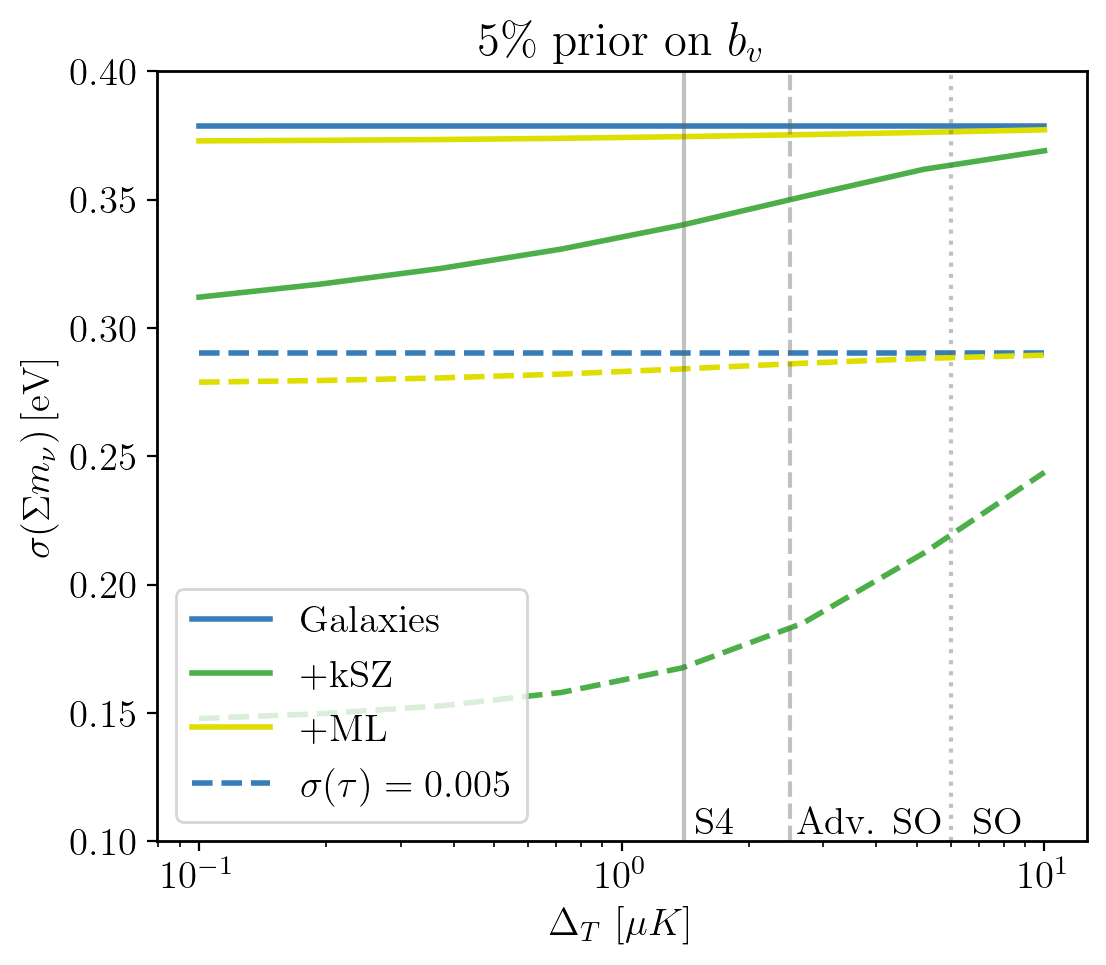

In [175]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ksz_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ml_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ksz_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ml_DT_pr2 = np.zeros(len(Delta_Ts))

bias_list = ['m', 'q', 'brsd', 'bv', 'b2']
fixed_params = ['bv']

for t in range(len(Delta_Ts)):
                
    F_vX_kSZ = F_vX_kSZ_t[t]
    F_vX_ML = F_vX_ML_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_XX, free_params, fixed_params+['brsd'], {})
    sig_mnu_gal_DT2[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_ksz, cov_params = covariance_mat(F_vX_kSZ, free_params, ['brsd'], {'bv':0.05})
    sig_mnu_gal_ksz_DT2[t] = np.sqrt(covmat_gal_ksz[mnu_ind,mnu_ind])
    covmat_gal_ml, cov_params = covariance_mat(F_vX_ML, free_params, ['brsd'], {'bv':0.05})
    sig_mnu_gal_ml_DT2[t] = np.sqrt(covmat_gal_ml[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_XX, free_params, fixed_params+['brsd'], {'tau':0.005})
    sig_mnu_gal_DT_pr2[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_ksz, cov_params = covariance_mat(F_vX_kSZ, free_params, ['brsd'], {'tau':0.005,'bv':0.05})
    sig_mnu_gal_ksz_DT_pr2[t] = np.sqrt(covmat_gal_ksz[mnu_ind,mnu_ind])
    covmat_gal_ml, cov_params = covariance_mat(F_vX_ML, free_params, ['brsd'], {'tau':0.005,'bv':0.05})
    sig_mnu_gal_ml_DT_pr2[t] = np.sqrt(covmat_gal_ml[mnu_ind,mnu_ind])


#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_gal_DT2, label='Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_ksz_DT2, label='+kSZ', color=palette[7])
plt.plot(Delta_Ts, sig_mnu_gal_ml_DT2, label='+ML', color=palette[13])
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr2, label=r'$\sigma(\tau)=0.005$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_ksz_DT_pr2, color=palette[7], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_ml_DT_pr2, color=palette[13], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 0.1, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 0.1, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 0.1, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)

plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'5\% prior on $b_v$')
plt.ylim(0.1,0.4)




In [287]:

fixed_params = ['bv']

for t in range(len(Delta_Ts)):
    F_bao_CMB_L = np.zeros((len(free_params), len(free_params)))
    #F_S4_t = F_CMB_DT['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_CMB_DT
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_bao_CMB_L[:7,:7] = F_S4_t
    F_bao_L = np.zeros((len(free_params), len(free_params)))
    F_bao_L[:7,:7] = F_bao
    F_planck_lowell_L = np.zeros((len(free_params), len(free_params)))
    F_planck_lowell_L[:7,:7] = F_planck_lowell
    F_bao_CMB_DT = F_bao_CMB_L + F_bao_L + F_planck_lowell_L
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {})
    sig_mnu_DT2[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT, free_params, bias_list, {'tau':0.005})
    sig_mnu_DT_pr2[t] = np.sqrt(cov[mnu_ind,mnu_ind])
                
    F_vX_kSZ = F_vX_kSZ_t[t]
    F_vX_ML = F_vX_ML_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+['brsd'], {})
    sig_mnu_gal_DT2[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_ksz, cov_params = covariance_mat(F_bao_CMB_DT+F_vX_kSZ, free_params, ['brsd'], {})
    sig_mnu_gal_ksz_DT2[t] = np.sqrt(covmat_gal_ksz[mnu_ind,mnu_ind])
    covmat_gal_ml, cov_params = covariance_mat(F_bao_CMB_DT+F_vX_ML, free_params, ['brsd'], {})
    sig_mnu_gal_ml_DT2[t] = np.sqrt(covmat_gal_ml[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_bao_CMB_DT+F_XX, free_params, fixed_params+['brsd'], {'tau':0.005})
    sig_mnu_gal_DT_pr2[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_ksz, cov_params = covariance_mat(F_bao_CMB_DT+F_vX_kSZ, free_params, ['brsd'], {'tau':0.005})
    sig_mnu_gal_ksz_DT_pr2[t] = np.sqrt(covmat_gal_ksz[mnu_ind,mnu_ind])
    covmat_gal_ml, cov_params = covariance_mat(F_bao_CMB_DT+F_vX_ML, free_params, ['brsd'], {'tau':0.005})
    sig_mnu_gal_ml_DT_pr2[t] = np.sqrt(covmat_gal_ml[mnu_ind,mnu_ind])


(0.01, 0.06)

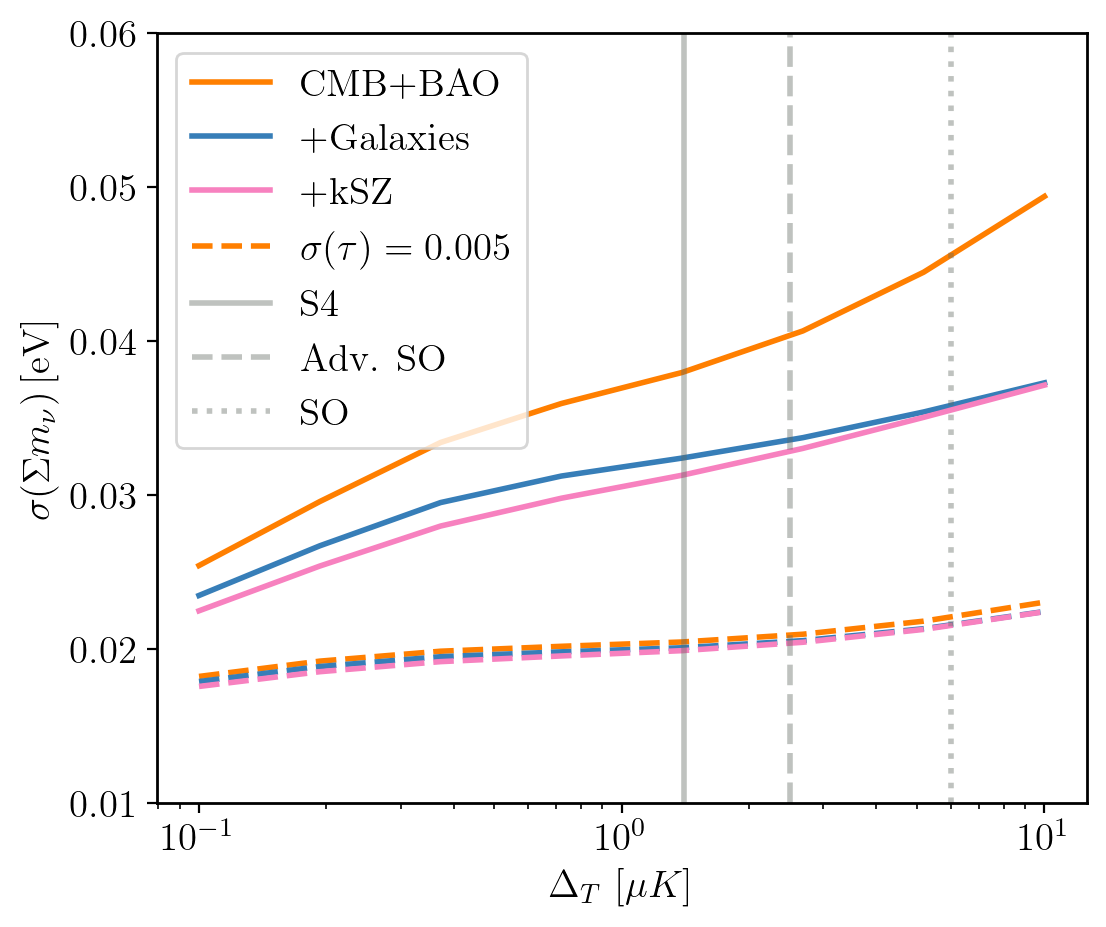

In [289]:
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_DT2, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_DT2, label='+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_ksz_DT2, label='+kSZ', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr2, label=r'$\sigma(\tau)=0.005$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr2, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_ksz_DT_pr2, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.ylim(0.01,0.06)



(0.01, 0.06)

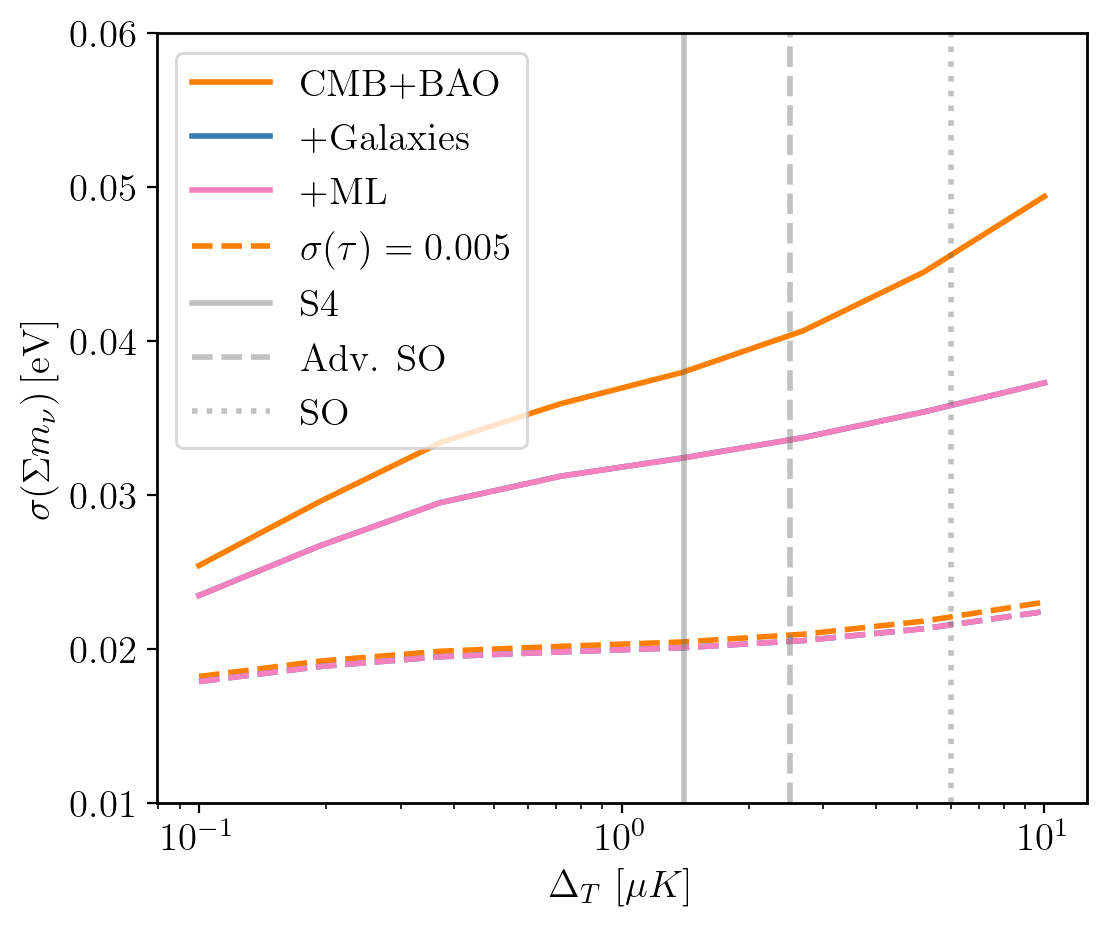

In [291]:
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_DT2, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_gal_DT2, label='+Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_ml_DT2, label='+ML', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr2, label=r'$\sigma(\tau)=0.005$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr2, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_ml_DT_pr2, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.ylim(0.01,0.06)


In [293]:
mnu_ind = free_params.index('mnu')
sig_mnu_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ksz_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ml_DT2 = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ksz_DT_pr2 = np.zeros(len(Delta_Ts))
sig_mnu_gal_ml_DT_pr2 = np.zeros(len(Delta_Ts))

bias_list = ['m', 'q', 'brsd', 'bv', 'b2']
fixed_params = ['bv']

for t in range(len(Delta_Ts)):
                
    F_vX_kSZ = F_vX_kSZ_t[t]
    F_vX_ML = F_vX_ML_t[t]
    F_XX = F_XX_t[t]
    
    covmat_gal, cov_params = covariance_mat(F_XX, free_params, fixed_params+['brsd'], {})
    sig_mnu_gal_DT2[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_ksz, cov_params = covariance_mat(F_vX_kSZ, free_params, ['brsd'], {'bv':0.01})
    sig_mnu_gal_ksz_DT2[t] = np.sqrt(covmat_gal_ksz[mnu_ind,mnu_ind])
    covmat_gal_ml, cov_params = covariance_mat(F_vX_ML, free_params, ['brsd'], {'bv':0.01})
    sig_mnu_gal_ml_DT2[t] = np.sqrt(covmat_gal_ml[mnu_ind,mnu_ind])
    
    covmat_gal, cov_params = covariance_mat(F_XX, free_params, fixed_params+['brsd'], {'tau':0.005})
    sig_mnu_gal_DT_pr2[t] = np.sqrt(covmat_gal[mnu_ind,mnu_ind])
    covmat_gal_ksz, cov_params = covariance_mat(F_vX_kSZ, free_params, ['brsd'], {'tau':0.005,'bv':0.01})
    sig_mnu_gal_ksz_DT_pr2[t] = np.sqrt(covmat_gal_ksz[mnu_ind,mnu_ind])
    covmat_gal_ml, cov_params = covariance_mat(F_vX_ML, free_params, ['brsd'], {'tau':0.005,'bv':0.01})
    sig_mnu_gal_ml_DT_pr2[t] = np.sqrt(covmat_gal_ml[mnu_ind,mnu_ind])


(0.1, 0.4)

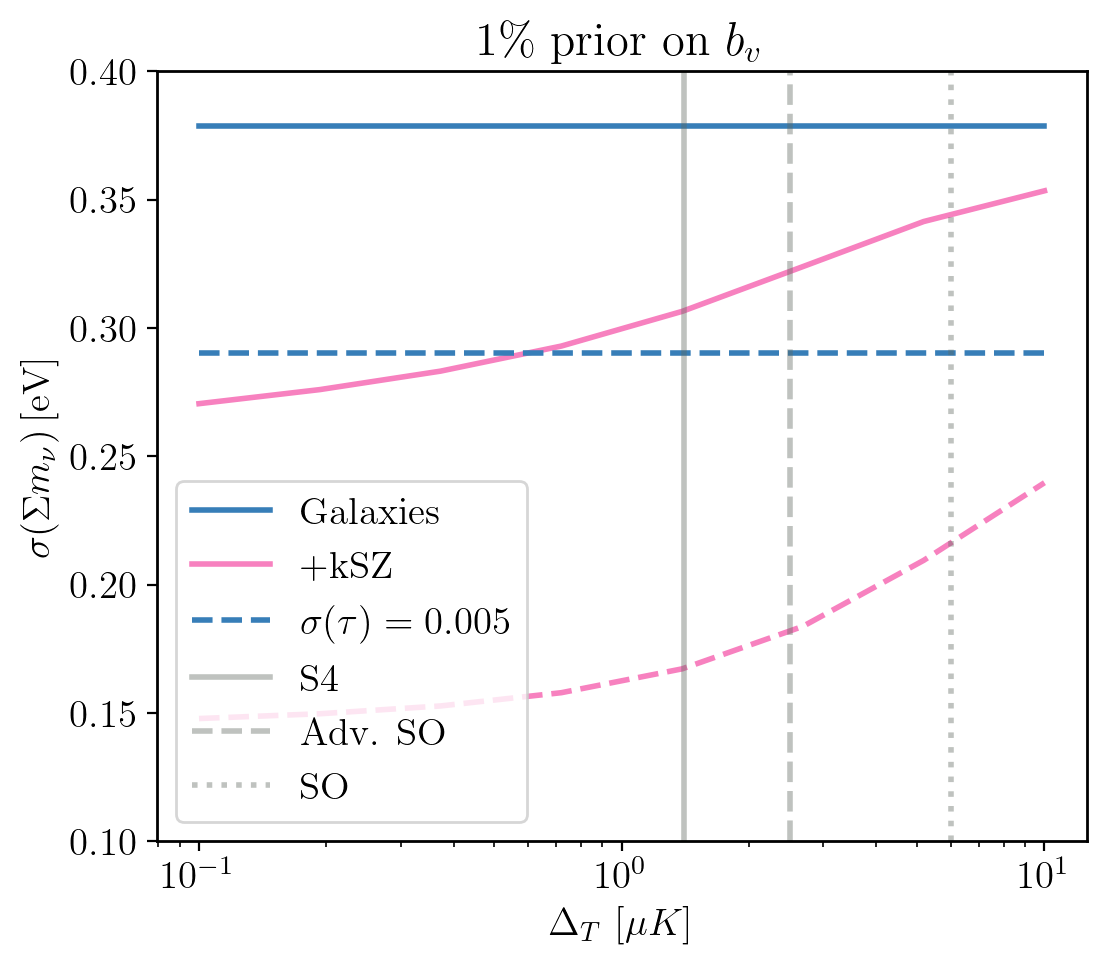

In [296]:
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_gal_DT2, label='Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_ksz_DT2, label='+kSZ', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr2, label=r'$\sigma(\tau)=0.005$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_ksz_DT_pr2, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'1\% prior on $b_v$')
plt.ylim(0.1,0.4)




(0.1, 0.4)

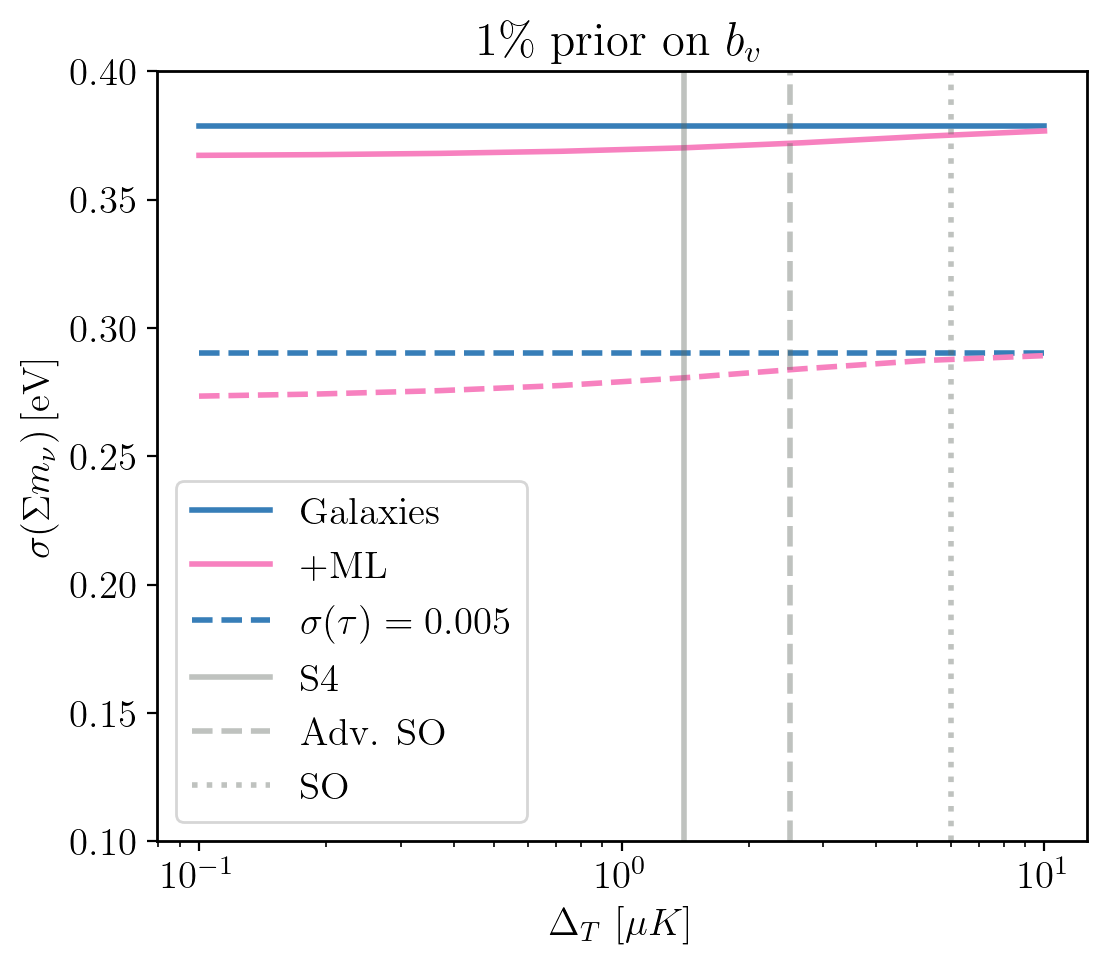

In [297]:
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_gal_DT2, label='Galaxies', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_gal_ml_DT2, label='+ML', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_gal_DT_pr2, label=r'$\sigma(\tau)=0.005$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_gal_ml_DT_pr2, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], label = 'S4', alpha=0.4)
plt.axvline(x = 2.5, color = palette[4], label = 'Adv. SO', alpha=0.4, ls='--')
plt.axvline(x = 6., color = palette[4], label = 'SO', alpha=0.4, ls=':')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[eV]}$')
plt.title(r'1\% prior on $b_v$')
plt.ylim(0.1,0.4)


